# Configuration

In [1]:
%load_ext autoreload
%load_ext tensorboard
%autoreload 2

In [2]:
import os
import pickle
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import tensorflow.keras as keras
from deep_dss.helpers import *
import treecorr
import warnings

warnings.filterwarnings(action='once')

# Run on GPU.
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
# Defaults
plt.rcParams.update({
'lines.color':'black',
'font.family':'serif',
'font.weight':'normal',
'text.color':'black',
'text.usetex': True,
'axes.edgecolor':'black',
'axes.linewidth':1.0,
'axes.titlesize':'x-large',
'axes.labelsize':'x-large',
'axes.labelcolor':'black',
'xtick.labelsize':'x-large',
'xtick.minor.width':1.0,
'xtick.major.width':1.0,
'ytick.major.size':7,
'ytick.minor.size':4,
'ytick.major.pad':8,
'ytick.minor.pad':8,
'ytick.labelsize':'x-large',
'ytick.minor.width':1.0,
'ytick.major.width':1.0,
'legend.numpoints':1,
'legend.fontsize':'x-large',
'legend.shadow':False,
'legend.frameon':False})

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
config = "k"
channels = 1
noiseless_m = False
noiseless_kg = False
rand_bias = False
mixed_bias = False
gaussian = False

order = 2
nside = 1024

val_set = "TEST"

exp_name = "spherenn-v3-simple-noisy-fixed-kappa"
num_id = 2
checkpoint_path = "../checkpoints/spherenn/{0}/{0}-{1}".format(exp_name, num_id)
checkpoint_dir = "../checkpoints/spherenn/{0}".format(exp_name)
# !mkdir $checkpoint_dir
log_dir = "../log/{0}".format(exp_name)
# !mkdir $log_dir
fig_dir = "../figures/{0}".format(exp_name)
# !mkdir $fig_dir

In [5]:
def num_cosmologies(dataset):
    if dataset == "TRAINLITE":
        return 16
    if dataset == "TESTLITE":
        return 4
    if dataset == "TEST":
        return 21
    return 45

def generate_reshaped_data(dataset):
    print("Generating data for {0}!".format(dataset))
    num_cosmos = num_cosmologies(dataset)
    data = split_count_and_lensing_maps_by_dataset(dataset, config=config, noiseless_m=noiseless_m,
                                                  noiseless_kg=noiseless_kg, rand_bias=rand_bias, 
                                                  mixed_bias=mixed_bias, gaussian=gaussian)
    data["x"] = np.reshape(data["x"], (12*(order**2)*num_cosmos, (nside//order)**2, channels))
    data["y"] = np.reshape(data["y"], (12*(order**2)*num_cosmos, 1, 1))
    return data

In [6]:
def build_model():
    return keras.Sequential([
        keras.Input(shape=(262144, channels)),
        keras.layers.Conv1D(64, 4, strides=4, activation='relu'),
        keras.layers.Conv1D(128, 4, strides=4, activation='relu'),
        keras.layers.Conv1D(256, 4, strides=4, activation='relu'),
        keras.layers.Conv1D(256, 4, strides=4, activation='relu'),
        keras.layers.Conv1D(256, 4, strides=4, activation='relu'),
        keras.layers.Conv1D(256, 4, strides=4, activation='relu'),
        keras.layers.Conv1D(256, 4, strides=4, activation='relu'),
        keras.layers.Conv1D(256, 4, strides=4, activation='relu'),
        keras.layers.Conv1D(1, 4, strides=4, activation='relu'),
    ])

def load_model():
    model = build_model()
    model.load_weights(checkpoint_path+"-Q4")
    return model

# Loading Model and Data

In [7]:
model = load_model()

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 65536, 64)         320       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16384, 128)        32896     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4096, 256)         131328    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 256)         262400    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 256, 256)          262400    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 64, 256)           262400    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 16, 256)           2

In [9]:
data = generate_reshaped_data("TEST")

Generating data for TEST!


/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 1024
  warnings.warn("NSIDE = {0:d}".format(nside))
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site

# Filters and Feature Maps

tf.Tensor(
[[-0.03110749  0.05438457]
 [-0.0722216   0.04607024]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.04790588  0.07021927]
 [-0.06742653 -0.08943107]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.03017805 -0.09324887]
 [ 0.01293431  0.01112013]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.06304254 -0.04127043]
 [ 0.08193431 -0.05567977]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.04590622  0.03607458]
 [-0.08688962  0.05839708]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[0.0556964  0.03218145]
 [0.02580247 0.03897709]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.06558294 -0.07037746]
 [-0.02179967  0.01496752]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.07252717 -0.04342808]
 [ 0.04449828 -0.08419039]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.08239309 -0.09036761]
 [-0.06689796  0.01563629]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.0608304   0.03830338]
 [ 0.00172052 -0.03450405]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.09347541 -0.00153189]
 [ 0.0

<ipython-input-27-b3ff76675e4d>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.matshow(tf.reshape(weights[:,i,j], [2,2]).numpy())


tf.Tensor(
[[-0.0559974  -0.04645891]
 [ 0.03259057  0.0020225 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.00058569 -0.08550565]
 [-0.02168877  0.0344427 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.08304108  0.04422612]
 [ 0.00021001  0.00097928]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.02982727 -0.07321945]
 [-0.04636582 -0.00964133]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.04833828 -0.0206345 ]
 [-0.0805989   0.02494875]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.02437826 -0.05864362]
 [ 0.08508826 -0.08126806]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.03062694  0.05896349]
 [ 0.03041757 -0.03858878]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.02640781  0.07287116]
 [-0.02191823 -0.01008407]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.07839729  0.02959004]
 [-0.08920915  0.0431485 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.05296312  0.05142691]
 [ 0.01788501 -0.01479235]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.03790744  0.07173858]
 [

tf.Tensor(
[[ 0.04161236 -0.00649934]
 [ 0.04965748 -0.02694996]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.04467283 -0.02481465]
 [ 0.07374407 -0.08392457]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.01908126 -0.00076474]
 [ 0.06730469 -0.0252307 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.0663183  -0.02427462]
 [ 0.04679802 -0.10952427]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.00880825 -0.03889687]
 [-0.10392192 -0.09057851]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.09555145 -0.03605978]
 [-0.03965613  0.05343324]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.00649788 -0.08106788]
 [ 0.05278471 -0.04725397]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.0514119  -0.08910891]
 [ 0.07461887 -0.03305697]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.08621744 -0.09472579]
 [-0.05792809 -0.09975406]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[0.07104323 0.0552295 ]
 [0.06279401 0.07698175]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.0051498  -0.05724412]
 [-0.0

tf.Tensor(
[[-0.01136798 -0.01279636]
 [-0.0133084   0.02369087]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.00339375 -0.0374478 ]
 [-0.07375439 -0.00738258]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.00163766 -0.09788461]
 [-0.00744305  0.02283515]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.02477857 -0.01210367]
 [-0.05196511 -0.04510212]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.00840506 -0.0134383 ]
 [ 0.04930367 -0.04494062]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.00300686 -0.07439631]
 [ 0.05670366 -0.06026584]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.03245665 -0.10301594]
 [-0.03937675  0.04787169]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.11252839 -0.01938441]
 [ 0.09809171 -0.0715296 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.07869134  0.03961219]
 [ 0.01592737  0.00266325]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.00963217  0.05386539]
 [ 0.06042295 -0.02865461]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.10462618 -0.08512738]
 [

tf.Tensor(
[[-0.03646937 -0.09844004]
 [ 0.04803779  0.05300377]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.04705548  0.01810276]
 [ 0.04971801  0.07809081]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.07309956 -0.08651046]
 [ 0.06175859  0.05803818]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.06307611 -0.03510987]
 [ 0.03220757  0.05438523]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.06746988  0.05487233]
 [ 0.04365447 -0.04263598]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.05730974 -0.04323879]
 [-0.08898597  0.06029148]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.06520588  0.08075873]
 [ 0.02305401 -0.05584076]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.05336209 -0.04190154]
 [-0.0594697   0.01508414]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.07058991 -0.1080492 ]
 [ 0.08406413 -0.00399291]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.07353558  0.01243904]
 [ 0.06920779 -0.00307626]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.05739217 -0.07270279]
 [

tf.Tensor(
[[ 0.07409435  0.05155124]
 [ 0.03638456 -0.0837079 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.03716328 -0.00036765]
 [ 0.02606193 -0.03808627]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.04525008 -0.02164625]
 [-0.01648443  0.03093718]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.03250928  0.02130595]
 [-0.00291708 -0.0662756 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.05692932  0.01125745]
 [ 0.07404747 -0.00206409]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.01296141  0.07001243]
 [-0.03655243 -0.02623123]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.02901437  0.03888781]
 [ 0.04080731  0.00248231]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.02476945  0.0473058 ]
 [ 0.0639952  -0.05566582]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.06007975  0.05569149]
 [-0.09459454 -0.05532477]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.05967282  0.0684097 ]
 [ 0.01343738 -0.06629575]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.06630883  0.05518038]
 [

tf.Tensor(
[[-0.01456569 -0.00114382]
 [ 0.06030473 -0.08720909]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.00975523 -0.0389267 ]
 [ 0.03289998 -0.04471372]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.01432711  0.06331877]
 [-0.02667003  0.04105296]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.06551952 -0.08632846]
 [ 0.00812829  0.04259872]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.00157844 -0.05336476]
 [ 0.01006692 -0.07940317]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.07069323  0.06384602]
 [-0.03035457 -0.0222863 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.08709953 -0.08445777]
 [-0.06070691 -0.05532401]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.0463344   0.06273393]
 [-0.00450867  0.03798322]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.06663454 -0.0044313 ]
 [-0.02713091  0.00249771]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.03374429 -0.0440179 ]
 [ 0.03125838 -0.0033949 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.02093211 -0.02887653]
 [

tf.Tensor(
[[ 0.07036053  0.04356083]
 [ 0.03599317 -0.00363302]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.05290527  0.02915268]
 [-0.0253814   0.01483656]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.02798517  0.04965467]
 [-0.03971164  0.04761165]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.10077403 -0.07252252]
 [ 0.03012038  0.00037267]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[0.05510828 0.00702888]
 [0.05188796 0.02957265]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.06505325  0.01710736]
 [-0.04350165 -0.02386361]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.02814963 -0.10160173]
 [ 0.00466493  0.03583606]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.08079028 -0.03404152]
 [-0.04674711  0.02365057]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.03421224  0.03554856]
 [ 0.00132684 -0.01289074]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.02936921  0.07422815]
 [-0.08088425 -0.06436238]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.05453756  0.04290951]
 [ 0.0

tf.Tensor(
[[ 0.00993786  0.03538721]
 [-0.00435426  0.05424206]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.01191544  0.05262834]
 [-0.02438     0.06486353]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.05798005 -0.01247595]
 [ 0.00180007  0.0796408 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.00442428  0.00308899]
 [-0.07272921 -0.03820434]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.0111056  -0.00242898]
 [ 0.02885539 -0.02959914]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.02685723 -0.07690065]
 [-0.05258    -0.09108897]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.05909874  0.05169174]
 [ 0.032687   -0.02764046]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.08350157 -0.04324837]
 [-0.00085407  0.01978539]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.05877386 -0.08494367]
 [-0.04580006 -0.04433077]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.03257082 -0.05731699]
 [ 0.02449168 -0.01619251]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.01384353 -0.04829228]
 [

tf.Tensor(
[[-0.03946488 -0.03903896]
 [ 0.05003397 -0.07885757]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.03681114 -0.05101859]
 [ 0.0242376   0.08484876]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.01663119 -0.08530922]
 [ 0.07524636  0.01312676]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.08161738  0.02750033]
 [-0.06567428  0.02083131]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.09122147  0.10876085]
 [-0.00281668  0.009348  ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.07597256 -0.02020814]
 [ 0.0364588  -0.02758754]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.00404604  0.01517697]
 [ 0.06994802 -0.08154198]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.05440798  0.00785992]
 [-0.04467631 -0.06666303]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.03293323 -0.08449166]
 [-0.02851696 -0.05690251]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.03812496 -0.04530556]
 [ 0.03111631 -0.01025498]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.0255405  -0.00660501]
 [

tf.Tensor(
[[ 0.01770322  0.06789335]
 [ 0.02201385 -0.02493161]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.08011927 -0.06191987]
 [ 0.03687874  0.01967161]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.06352557 -0.04120527]
 [-0.06580066 -0.00229373]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.0782749   0.05576224]
 [-0.02371543 -0.10623367]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[0.03381836 0.05552724]
 [0.04727606 0.03628817]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.03379393  0.05573603]
 [-0.10345189  0.06395496]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.0218477  -0.04849176]
 [-0.00393207  0.05038915]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.01948843 -0.03312382]
 [ 0.00230798  0.06805503]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.04627294 -0.00109101]
 [ 0.0372261  -0.07835877]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.03625385 -0.00844829]
 [ 0.03904221  0.06942655]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.01868892 -0.0384514 ]
 [-0.0

 [ 0.07120155 -0.05234562]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.04544268 -0.0153053 ]
 [-0.05099857 -0.08820623]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.05677222 -0.01262355]
 [ 0.06442152 -0.00582857]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.03645074  0.00586436]
 [-0.00637046 -0.05833134]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.05179479  0.07594675]
 [-0.00194204 -0.03291077]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.02607677 -0.09560864]
 [ 0.08644629  0.02056182]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.07330418 -0.00458918]
 [ 0.05001052 -0.07585842]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.06914399 -0.07304227]
 [-0.06022172  0.05230915]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.00676873  0.00677907]
 [ 0.08404742 -0.03811323]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.03343243 -0.01074383]
 [-0.08206356  0.09387296]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.04528356  0.03967105]
 [ 0.03775201 -0.07548055]], shape=(2, 2

tf.Tensor(
[[-0.06613272  0.06514628]
 [-0.03578518  0.07383286]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.06178843 -0.0187604 ]
 [-0.01049893  0.02668435]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.04629305 -0.00731306]
 [-0.07852416 -0.06830995]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.05452682 -0.04300625]
 [ 0.04196034 -0.05219091]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.00097034 -0.00336729]
 [-0.02065913 -0.05977075]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.05234583 -0.04903809]
 [-0.07982913 -0.07141166]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.09121844 -0.05682766]
 [ 0.02579805  0.00646645]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.04380889  0.06053275]
 [ 0.05237637 -0.03315358]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.08928982 -0.07740414]
 [-0.06605539 -0.03775998]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.07073763  0.05638067]
 [-0.07014652  0.03863946]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.01433306 -0.04073805]
 [

tf.Tensor(
[[ 0.06475032  0.05504825]
 [-0.02056635 -0.05082314]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.02242788  0.01314221]
 [-0.0262182   0.04097226]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.04704896  0.07693803]
 [-0.08643279 -0.04810671]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.08724798  0.00948178]
 [ 0.00579294 -0.05105826]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.06263122 -0.09646612]
 [-0.04337393 -0.05279251]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.00461085  0.02403519]
 [ 0.03299442 -0.0976025 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.04698641 -0.04675578]
 [ 0.05522495  0.06255886]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[0.04857911 0.00102109]
 [0.04216641 0.05560691]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.01261718 -0.06924565]
 [ 0.05376343  0.02037022]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.05741946  0.00598336]
 [-0.06023942 -0.09243783]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.06760388 -0.01824231]
 [ 0.0

tf.Tensor(
[[-0.09969214 -0.11536209]
 [ 0.02185552 -0.03728323]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.00719406 -0.06392632]
 [-0.04111197  0.05510539]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.07626072  0.01686168]
 [-0.08013829  0.02282307]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.0473326  -0.06395565]
 [-0.00593538 -0.01182604]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.07277636 -0.05175225]
 [-0.06495391 -0.06887716]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.05829253 -0.00882685]
 [ 0.01795139 -0.04696297]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.04869258  0.06516461]
 [ 0.05125199 -0.04282194]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.08075373 -0.06868993]
 [ 0.0411205  -0.09567206]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[0.03970459 0.08182552]
 [0.05933305 0.03761413]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.04196341 -0.03858913]
 [ 0.04078489 -0.00640565]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.06148979 -0.05299357]
 [ 0.0

 [-0.08310685  0.02041355]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.02218609 -0.01345638]
 [-0.01681927 -0.01929831]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.07601515  0.01273139]
 [ 0.00810182 -0.08378933]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.00044876 -0.05200352]
 [ 0.02488239 -0.03536077]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.07220449 -0.05462296]
 [ 0.01080407 -0.07024401]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.02193273 -0.00712084]
 [-0.03410382 -0.03480174]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[0.025146   0.05118969]
 [0.02285306 0.00855459]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.06928856  0.04258018]
 [-0.02597325 -0.07454424]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.03068921  0.05923689]
 [-0.01158268  0.02200896]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.03375452  0.05625051]
 [ 0.01781531  0.00153184]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.0665922  -0.03310569]
 [-0.01353877 -0.0450974 ]], shape=(2, 2), d

tf.Tensor(
[[-0.00651323  0.0485568 ]
 [ 0.03944334  0.05655615]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.08291418  0.06257477]
 [ 0.08289251 -0.06500719]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.03146838 -0.06223016]
 [ 0.05047727  0.019437  ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[0.05753236 0.00466753]
 [0.02955382 0.00177333]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[0.04237421 0.0096258 ]
 [0.06187485 0.02975146]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.04519788  0.07536119]
 [ 0.07562067 -0.00496029]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.08539234 -0.00634414]
 [-0.03091428 -0.05569291]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.03835525 -0.05616948]
 [-0.03553898  0.06763317]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.0367102   0.0482911 ]
 [-0.03577842 -0.02925199]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.10554207 -0.03997445]
 [-0.09075487 -0.03341329]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.01389534  0.07283302]
 [ 0.07177

tf.Tensor(
[[-0.0613245  -0.03506539]
 [ 0.0915316   0.05577875]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.02358833  0.09413754]
 [ 0.00281995 -0.01767882]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.04405119  0.03741968]
 [-0.02220111  0.02193188]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.02878206  0.00725707]
 [ 0.00930066 -0.04758835]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.03368125  0.06631989]
 [ 0.03727192  0.0261774 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.0346422   0.02775028]
 [ 0.07971857  0.02612623]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.06995763 -0.08146124]
 [-0.09983331  0.00347593]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.00396591  0.01912414]
 [-0.05759757  0.04274196]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.01450849  0.0416793 ]
 [-0.01929385 -0.08112637]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.08049493  0.05653016]
 [-0.0072325   0.0334101 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.07624346  0.05567115]
 [

tf.Tensor(
[[-0.05996532  0.05344405]
 [-0.06515221  0.04237853]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.05051005 -0.06816781]
 [-0.00142165  0.01643862]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.02468753 -0.05166337]
 [ 0.0563902  -0.04587361]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.07858204  0.00030311]
 [ 0.03101591  0.02394019]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.02311324  0.00014103]
 [-0.04059035 -0.07944142]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.03552406 -0.0627198 ]
 [ 0.04206503  0.03964445]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.02574974  0.02088284]
 [ 0.0677966  -0.07469814]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.03710227 -0.03061193]
 [ 0.04279274 -0.09962006]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.02913621  0.02086663]
 [-0.03138144 -0.09763652]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.01185338 -0.05327068]
 [ 0.04021399 -0.08257307]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.08926111  0.04481585]
 [

 [0.00742753 0.01006762]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.03535159 -0.03493046]
 [ 0.00659555 -0.05844839]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.00379916 -0.04046866]
 [ 0.02098842  0.04859959]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.08030432  0.04722452]
 [ 0.02779383 -0.06017539]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.02047343  0.03242718]
 [-0.09271919  0.04805651]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.04693012 -0.02279938]
 [ 0.05250076 -0.05847844]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.00181903  0.03105403]
 [-0.09651385  0.03052324]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.04374065  0.0359281 ]
 [-0.03796229  0.0765394 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.07748184  0.02623767]
 [-0.05879878 -0.02110655]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.06047297  0.07446151]
 [ 0.0532308  -0.04231854]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.04871465  0.06868244]
 [-0.00847426  0.08168352]], shape=(2, 2),

tf.Tensor(
[[ 0.04972727  0.00840603]
 [-0.03931177  0.01024444]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.05955985  0.03754346]
 [ 0.00954683 -0.0896938 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[0.01566977 0.06900095]
 [0.01198626 0.0843064 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.06874982  0.01089663]
 [-0.08681139 -0.04570496]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.02553135 -0.10153492]
 [ 0.02280317  0.08330852]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.09050367 -0.0865007 ]
 [ 0.08066795  0.05778315]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.08529767  0.0640086 ]
 [-0.07332297 -0.03930669]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.04046081 -0.05310939]
 [ 0.00878458 -0.08969185]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.0391554   0.04493258]
 [-0.02283001  0.01509696]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.06134587  0.03954227]
 [ 0.04308695 -0.08113706]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.05786836  0.03713211]
 [ 0.0

tf.Tensor(
[[-0.08414374 -0.09979232]
 [ 0.02246044 -0.08898459]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.01710568 -0.00391951]
 [-0.10381512  0.03579649]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.08806112 -0.00187717]
 [ 0.0506309   0.0750009 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.00492466  0.01787741]
 [-0.0648769   0.08238016]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.03418569 -0.07143231]
 [ 0.01986553 -0.03333654]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.02334485 -0.03315092]
 [-0.07137232  0.05126179]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.11080851 -0.00218342]
 [-0.05583068 -0.09720225]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.07397645  0.06177532]
 [-0.04624393  0.04757845]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.03963009 -0.03859705]
 [-0.01411568 -0.10764227]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.00296671 -0.00310646]
 [-0.04599486  0.0081502 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.06044803  0.03752867]
 [

tf.Tensor(
[[ 0.02192825 -0.07385723]
 [ 0.05164868  0.00879307]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.07652378 -0.0067726 ]
 [ 0.06217549 -0.01930834]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.02295658  0.00289108]
 [ 0.05547049  0.07516132]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.04177099 -0.01422279]
 [-0.00360942 -0.0253897 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.08245656 -0.05934265]
 [-0.00524931 -0.07812407]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.08461223  0.03512772]
 [-0.08347169 -0.03828301]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.08603047  0.01024545]
 [-0.05116813 -0.00398807]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.00261008 -0.07771059]
 [ 0.04302099  0.07791623]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[4.6746526e-02 3.4173403e-02]
 [5.2186914e-02 6.8006280e-05]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.04044687 -0.01784458]
 [ 0.07545663 -0.00101906]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.02808869  0.0533

tf.Tensor(
[[ 0.00833465  0.05553198]
 [-0.06190015 -0.05274402]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.02955546 -0.09298138]
 [-0.03013004  0.02997512]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.0036363  -0.06874937]
 [-0.04855304  0.0975813 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.02869458 -0.02587323]
 [-0.08231651 -0.04589364]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.00919542  0.03172241]
 [ 0.00927065  0.04232613]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.07595234 -0.0501343 ]
 [-0.03822432 -0.0450603 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.00403904  0.03463759]
 [-0.09279493 -0.07842005]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.02102443  0.06972732]
 [-0.09043474 -0.07915904]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.01214372  0.07715312]
 [ 0.02889294 -0.03313844]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.02962507 -0.02397543]
 [-0.08067785 -0.0361633 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.06425353 -0.0241718 ]
 [

tf.Tensor(
[[-0.06209666 -0.06922279]
 [ 0.03720088  0.0169377 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.04902161  0.04578629]
 [-0.02546253 -0.0083012 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.00336691 -0.02328006]
 [-0.06255101  0.0231586 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.00488894 -0.03356772]
 [-0.02317118 -0.08307831]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.02831587  0.04438804]
 [-0.06005424 -0.0873804 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.04834779 -0.02709745]
 [-0.00176262 -0.08208249]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.07447105  0.02652455]
 [ 0.088737    0.01494515]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.04402545 -0.07494825]
 [-0.03088027  0.06208234]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.0630386  -0.07477503]
 [ 0.00714219 -0.06272035]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.031748    0.06916907]
 [-0.09655276  0.03221891]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.06925121 -0.01559083]
 [

tf.Tensor(
[[ 0.03584641 -0.06454148]
 [-0.02268549 -0.06294356]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.01128279  0.03352721]
 [ 0.03534192  0.04616174]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.01916426  0.07485343]
 [-0.00431613 -0.07594454]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.05464037  0.05125304]
 [-0.04845288 -0.00461915]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.01762373  0.07352599]
 [-0.05698059 -0.06075111]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.08900031  0.00250457]
 [ 0.00612946  0.03156976]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.10235499  0.05266054]
 [ 0.00119354  0.01492115]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.06486699  0.06828555]
 [-0.08886199 -0.0839276 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.0515359   0.01905661]
 [-0.00380606  0.06334066]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.0133505  -0.08746176]
 [-0.05321516 -0.07312928]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.01464515  0.07189652]
 [

 [-0.02156793 -0.06388378]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.00766858 -0.07590392]
 [-0.04273041  0.03741277]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.01129742 -0.00767708]
 [ 0.05713103 -0.05643176]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.05403315  0.01731565]
 [-0.08684961 -0.09908327]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.02906234  0.04314368]
 [-0.0771607   0.01226335]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.07523055 -0.08759018]
 [-0.02913051  0.0854874 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.04188602 -0.01054994]
 [ 0.06456886 -0.0744875 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.04352367 -0.04274453]
 [-0.03596525  0.02614166]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.0975196  -0.05374802]
 [-0.08958353 -0.06687044]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.00685488  0.01762597]
 [-0.06479897  0.02423993]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.0423694  -0.04518462]
 [-0.05322521  0.08299118]], shape=(2, 2

 [-0.05752785  0.0247399 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[0.0068424  0.02285393]
 [0.04950906 0.01872306]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.0510948  -0.00503678]
 [ 0.07306093 -0.04297241]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.09006245 -0.04989995]
 [ 0.01264274 -0.058132  ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.01409972 -0.00098762]
 [-0.0003568   0.06758659]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.06817218  0.04826054]
 [-0.08169342  0.04310854]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.05933832  0.05276869]
 [-0.09523648 -0.03346236]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.00325769  0.04071198]
 [-0.0322035  -0.08240652]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.03358238 -0.06343664]
 [-0.0290889   0.05143078]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.09549097 -0.03994462]
 [ 0.07072759  0.02440374]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.04179658 -0.083049  ]
 [-0.07805955 -0.03995952]], shape=(2, 2), d

 [-0.05895115  0.06357715]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.07794467  0.04039153]
 [-0.00651671  0.04387937]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.04605759 -0.01800875]
 [-0.05292644 -0.00486824]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.09308009  0.04952042]
 [-0.09298824 -0.054582  ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.04232776 -0.00862498]
 [-0.03994605 -0.02744141]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.11265361 -0.08429298]
 [-0.04808485  0.00172134]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.00526873 -0.02852274]
 [ 0.00074498 -0.04690747]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.03336686 -0.07604171]
 [ 0.01023794  0.01064347]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.02356896 -0.04505373]
 [-0.0496526   0.01557451]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.03601308  0.0524882 ]
 [-0.05998619  0.06366789]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.05585859  0.03968811]
 [-0.07605945 -0.08274782]], shape=(2, 2

 [-0.0696552  -0.10957435]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.08449154 -0.00826239]
 [-0.0392012  -0.00034911]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.10633633  0.00707045]
 [-0.02473759  0.05591129]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.01952068  0.06811526]
 [ 0.02813896 -0.01917119]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.02684584  0.01797408]
 [-0.01589205 -0.07662866]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.0293849  -0.03339002]
 [ 0.056537    0.06017599]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.02466805  0.06139179]
 [ 0.04323673 -0.00111016]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.00796365  0.02332969]
 [-0.06593957 -0.01366862]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[0.04448811 0.00411595]
 [0.07105501 0.05948278]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.08193836  0.03207845]
 [-0.00416762 -0.067434  ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.05609464  0.06799398]
 [-0.06991996  0.04573401]], shape=(2, 2), d

tf.Tensor(
[[ 0.01128874 -0.09954666]
 [-0.05543981  0.03665024]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.05843902 -0.09344655]
 [ 0.04448618 -0.01609414]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.0830689  -0.04052056]
 [-0.01896405  0.08606837]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.0008735   0.03563737]
 [-0.06755035  0.04628417]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.04526546  0.03027089]
 [-0.0631558  -0.02388483]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.03482472  0.01987436]
 [-0.05171484  0.0056032 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.04044072 -0.07021181]
 [ 0.03901671  0.00333765]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.05560534 -0.01444583]
 [ 0.04100933 -0.00485608]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.02693571 -0.05791989]
 [-0.08669029  0.06914213]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.06686761  0.01625445]
 [-0.09199575 -0.0424553 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.04854409 -0.03929005]
 [

tf.Tensor(
[[-0.10822523 -0.09538496]
 [ 0.05882682  0.03634748]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.08300897 -0.01338862]
 [ 0.01432455  0.05589219]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.01096565 -0.05375959]
 [ 0.0675633  -0.01878384]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[0.07817555 0.06034248]
 [0.01833135 0.05654291]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[0.01377115 0.03304171]
 [0.07534284 0.02280916]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[0.08287194 0.02520023]
 [0.02721392 0.02317099]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.06112539  0.07575532]
 [ 0.04137081  0.00761267]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.06553295 -0.10940215]
 [-0.05621031  0.05386606]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.08081201 -0.02490914]
 [-0.05327129  0.04623841]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.09831458  0.0588625 ]
 [ 0.03045276  0.07471108]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.05868046  0.00736491]
 [-0.06267385 

 [-0.03905967 -0.11310691]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.05524871  0.03071754]
 [-0.0508281  -0.0650191 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.02701222 -0.00382315]
 [-0.02653209  0.02858734]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.09280729 -0.07930893]
 [-0.05231531  0.05544902]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.01109356 -0.09298962]
 [-0.07204223 -0.0383207 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.07379626 -0.07796484]
 [-0.0746857  -0.06296053]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.00278368 -0.05937126]
 [ 0.03866346  0.02557425]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.00050324 -0.02270028]
 [-0.05629499 -0.07496326]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.05237545  0.0428054 ]
 [-0.05030541  0.03964656]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.03873437  0.02345563]
 [ 0.01535054  0.07321265]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.023239   -0.06249554]
 [-0.00878407 -0.09172962]], shape=(2, 2

tf.Tensor(
[[-0.02207167 -0.05846452]
 [-0.08518068  0.0383149 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.07488182  0.01196032]
 [-0.03979648 -0.09093197]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.04787998  0.01497455]
 [ 0.05117622 -0.03612403]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.04804872 -0.07824489]
 [ 0.01649834  0.00037203]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.06814725 -0.0237953 ]
 [-0.06021118  0.02229737]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.05735355  0.03303082]
 [-0.05104282  0.02921499]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.05059454  0.07076857]
 [-0.001542    0.05563806]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.01186666  0.06653372]
 [ 0.00272995 -0.02672324]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.03656926 -0.08102814]
 [-0.04081453 -0.10605451]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.02511392 -0.07452125]
 [ 0.03909723  0.01824351]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[0.06586584 0.0769983 ]
 [0.

tf.Tensor(
[[-0.02405173  0.02888234]
 [-0.0224498  -0.00592812]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.0764934  -0.02038373]
 [-0.07045945 -0.00183733]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.03428952  0.02493052]
 [ 0.04727218 -0.0788914 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.07984991 -0.06930108]
 [ 0.02567413 -0.0210519 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.04874508  0.00013605]
 [ 0.02003788  0.03830841]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.0649194   0.0389701 ]
 [-0.06622738  0.05527263]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.08447933 -0.06225199]
 [ 0.0007569  -0.04536472]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.03979722 -0.08465564]
 [-0.10236    -0.02555702]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.02389004  0.00780925]
 [ 0.06956332  0.0297248 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.03058882 -0.0150417 ]
 [ 0.04751642  0.03578315]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.07370958  0.00846846]
 [

tf.Tensor(
[[-0.07222091  0.06372564]
 [-0.06571256 -0.04925337]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.00578107 -0.02133028]
 [-0.01111427 -0.03486471]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.09078123  0.05601194]
 [ 0.03079913  0.06157587]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.05302313  0.06834662]
 [ 0.00211534 -0.00173722]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.04330246 -0.04922974]
 [-0.07241142 -0.03693433]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.0199523  -0.06803823]
 [-0.01708113  0.04483973]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[0.00892387 0.02716274]
 [0.05489676 0.00396614]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.09192929  0.08161832]
 [ 0.04581668 -0.0603803 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.05624344  0.04287454]
 [-0.08684353 -0.007848  ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.08426918  0.06965736]
 [ 0.10006561 -0.05638784]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.02481361 -0.04815768]
 [-0.0

tf.Tensor(
[[ 0.01467407 -0.02714035]
 [-0.04924396 -0.01458341]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.07907953 -0.01927649]
 [ 0.04503804  0.06381302]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.059574   -0.09385079]
 [-0.04580725  0.04226416]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.01443895 -0.07763992]
 [ 0.00285923 -0.00715418]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.02404335 -0.07219961]
 [-0.0605479   0.05186151]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[0.03139491 0.02334087]
 [0.01795003 0.03382417]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.04686063 -0.00940091]
 [-0.04031582  0.03393881]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.01917646  0.03210134]
 [ 0.04044862 -0.00511227]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.03116414  0.01216198]
 [-0.02484607  0.072321  ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.00792019 -0.05393669]
 [-0.00880395 -0.02416129]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.03830729  0.03218753]
 [-0.0

tf.Tensor(
[[-0.08244465  0.01546227]
 [ 0.07782909 -0.08615094]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.01398292  0.05565466]
 [ 0.01709428  0.01293313]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.07164228 -0.08560748]
 [-0.01215229  0.00923884]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.09835233 -0.11413019]
 [ 0.00881107  0.07311141]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.05014637 -0.05440277]
 [ 0.02665443  0.02400242]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.08176175 -0.01701173]
 [ 0.00716307  0.02300126]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.07500566 -0.00043547]
 [ 0.03725453  0.04465199]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.04951425 -0.0757065 ]
 [-0.05031297  0.02660971]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.02298463 -0.09685846]
 [-0.02353719  0.0625096 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.07800886  0.04634953]
 [-0.05051935 -0.02380388]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[0.00246761 0.03902151]
 [0.

tf.Tensor(
[[ 0.06858289  0.03432524]
 [-0.03391289  0.04544335]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.07919072  0.04229672]
 [ 0.05062392  0.04582711]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.02124293 -0.03415008]
 [-0.09258693 -0.00229319]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[0.02092811 0.03809949]
 [0.00128464 0.06588797]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.06130007 -0.05326192]
 [-0.01639452  0.01247651]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.10229327 -0.10222213]
 [ 0.08420274 -0.00892989]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.04660128  0.03915561]
 [-0.03633222 -0.03980261]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.02017102 -0.07158872]
 [ 0.01206325  0.05495   ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.0818403  -0.05846942]
 [-0.10412522 -0.07506805]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.07890271 -0.000807  ]
 [-0.10050098  0.06532063]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.10796492  0.05303686]
 [-0.1

tf.Tensor(
[[-0.0812962   0.05292356]
 [-0.00624622 -0.03962863]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.01822498 -0.08289818]
 [-0.0640139   0.06865388]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[0.03843822 0.07124491]
 [0.04149256 0.07490902]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.05063683  0.08408803]
 [-0.06476717  0.01027728]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.00990424  0.00092311]
 [-0.06541722 -0.01512393]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.05988551 -0.01092737]
 [-0.00861293 -0.05859835]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.03654953 -0.0111526 ]
 [ 0.03993724  0.06021589]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.07799938 -0.04537709]
 [ 0.00757108 -0.07396067]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[0.05993385 0.00314829]
 [0.00545068 0.08029068]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.02517366 -0.05510263]
 [-0.07347044 -0.00999337]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.05282554 -0.07838147]
 [ 0.01303

tf.Tensor(
[[0.02356118 0.06305113]
 [0.01176889 0.07149263]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.12569241 -0.01531118]
 [ 0.07488842 -0.03557115]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.02104879 -0.07547276]
 [ 0.01669719 -0.00233802]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.04218548 -0.07060529]
 [-0.08667573 -0.00407146]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.0388183   0.06764245]
 [ 0.01149922 -0.00705843]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.03722662  0.02199222]
 [-0.09022052 -0.01047406]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.02525076 -0.01131259]
 [-0.03392132 -0.06520762]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.01901692  0.01674733]
 [-0.04939584  0.07577316]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.03201241 -0.02012682]
 [-0.05957308 -0.04653081]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.06401042 -0.09604862]
 [-0.04161718 -0.00197395]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.03364762  0.00138752]
 [-0.1

 [ 0.05057711  0.02286695]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[0.05386454 0.04004485]
 [0.04267827 0.05469196]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.08609232 -0.00601001]
 [-0.03528647  0.03177898]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.05072054 -0.06870478]
 [-0.05660918  0.0880231 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.03565142 -0.05772865]
 [-0.01839004  0.07519507]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.0672001   0.0349532 ]
 [-0.01535248  0.03441096]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.04616537 -0.02956818]
 [-0.04607924 -0.04420729]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.01489081 -0.06439257]
 [ 0.06412617  0.06781161]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.02048941 -0.08925432]
 [-0.08757012  0.02183128]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.02929248  0.07791262]
 [ 0.05095111 -0.07398397]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.04406727 -0.02448813]
 [-0.06895015 -0.03159787]], shape=(2, 2), d

tf.Tensor(
[[ 0.00333494 -0.09968129]
 [-0.05474146  0.00223606]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.04615885 -0.00527822]
 [-0.07224449  0.04088064]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.0213938   0.01603875]
 [-0.03825946 -0.08417873]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.1117167  -0.12004208]
 [-0.01075566  0.05860911]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.04905445 -0.02031924]
 [-0.08740641 -0.0708243 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.00208945 -0.0590859 ]
 [-0.03316211 -0.02983792]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.04115335 -0.09571596]
 [-0.01850269 -0.0556982 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.00108358  0.03608286]
 [-0.05748508 -0.08847388]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.04328307 -0.00407185]
 [-0.06883182 -0.06357449]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.06609473  0.06273974]
 [-0.06522593 -0.05679313]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.05577611  0.00734886]
 [

tf.Tensor(
[[-0.0577307  -0.07048999]
 [-0.07476025  0.00162009]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.01109789 -0.06086487]
 [-0.09871177 -0.01784486]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.0280971  -0.01695304]
 [-0.05054125  0.04242546]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[0.03598538 0.03570773]
 [0.04471236 0.03058668]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.00115787  0.06473368]
 [ 0.05912499 -0.08008489]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.06297518  0.00466401]
 [-0.07210688 -0.02480799]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.00434755  0.06676593]
 [ 0.02683055 -0.08978114]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.02929591  0.06584111]
 [ 0.05077994 -0.03095382]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.01906257 -0.02872973]
 [-0.08107021  0.01706242]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[0.02068177 0.03578977]
 [0.02187059 0.02021776]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.11654932 -0.08394311]
 [-0.04048

tf.Tensor(
[[ 0.0224562  -0.08543472]
 [ 0.06366108 -0.01376748]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.07216885 -0.00569005]
 [-0.05420631 -0.07159213]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.01743527  0.04538858]
 [ 0.02993041 -0.08140147]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.00132657 -0.01050553]
 [-0.08688658  0.01739923]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.07098626 -0.00896765]
 [-0.01013994 -0.00187953]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.03292583  0.06753801]
 [ 0.03957028 -0.01765284]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.06217939  0.05936442]
 [ 0.07077072 -0.07705037]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.07146292 -0.0008185 ]
 [ 0.00720718 -0.0201291 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.02378331  0.04333008]
 [ 0.02701164 -0.0904718 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.02898424  0.01680192]
 [-0.07884022  0.04383603]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.067103    0.02321024]
 [

tf.Tensor(
[[-0.07532764 -0.01796131]
 [ 0.03032425  0.063017  ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.03700768 -0.04490886]
 [ 0.05160636 -0.0445298 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.08254139 -0.07588325]
 [-0.00989063  0.04905912]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.01401772  0.06158335]
 [ 0.00318234  0.00732913]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.00995498 -0.02326959]
 [ 0.05446059 -0.02747962]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.0664278  -0.08778799]
 [-0.04113684  0.0316643 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.0384657  -0.02104588]
 [-0.01627675 -0.08157575]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.00541908 -0.04781922]
 [ 0.03127389 -0.07505871]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.03503592 -0.07663089]
 [ 0.00590225  0.06001062]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.02400962 -0.01947939]
 [-0.05116958 -0.08169606]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.00039789 -0.02558301]
 [

tf.Tensor(
[[ 0.06031647  0.03971738]
 [ 0.01842245 -0.06519327]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[0.0874538  0.06344951]
 [0.05343416 0.04586364]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.05588613 -0.00122211]
 [-0.07052969 -0.04691222]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.03390092 -0.02607366]
 [-0.01734652  0.04412996]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.03438196 -0.01698046]
 [-0.05257497  0.0595197 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.06223967 -0.05533175]
 [ 0.02264693  0.01854617]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.07294742 -0.00408145]
 [ 0.02418971  0.05591115]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.04057047 -0.01819389]
 [ 0.04399044 -0.06042823]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.04416214 -0.03266646]
 [-0.04355017  0.05934156]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.02317269 -0.0936639 ]
 [-0.0498261   0.01776007]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.08239909  0.01910543]
 [ 0.0

tf.Tensor(
[[ 0.00767333 -0.03122534]
 [ 0.02715474 -0.00896693]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[0.02594548 0.01888642]
 [0.07469724 0.03484678]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.04815014 -0.1123806 ]
 [ 0.05910778 -0.0726894 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.0706525  -0.06120946]
 [-0.07362129  0.02527376]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.02716381  0.06871801]
 [ 0.06554265  0.05048877]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.05249182  0.04918777]
 [-0.09020604 -0.00837875]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.01303727 -0.06216843]
 [-0.04095047 -0.02736866]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.01167932  0.05865926]
 [-0.09799555  0.03979717]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.02739417 -0.10123266]
 [ 0.01372988 -0.06223481]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.02803211  0.0639016 ]
 [ 0.00809138  0.06777727]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.02448605 -0.0716245 ]
 [-0.0

tf.Tensor(
[[ 0.0742052  -0.09090865]
 [-0.02745478  0.06325012]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.01867416  0.0624898 ]
 [ 0.02890418 -0.01531485]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.0331847  -0.00656363]
 [-0.09231868 -0.07591945]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[0.03058472 0.07232954]
 [0.06475499 0.05454065]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.03686296 -0.04754268]
 [-0.00872007 -0.06069583]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.09423902  0.07625991]
 [ 0.00407845  0.05468554]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.02296064 -0.00098591]
 [-0.05491811 -0.06333807]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[0.08058041 0.07874388]
 [0.04166788 0.0226229 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.07191937 -0.02277018]
 [ 0.0036569  -0.07878564]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[0.01002965 0.02796855]
 [0.03530365 0.04331294]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.09472774 -0.05159601]
 [ 0.02956518 

tf.Tensor(
[[-0.07578875 -0.09580996]
 [-0.07901701  0.08437829]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.03883603  0.04223294]
 [-0.05439762 -0.02367509]], shape=(2, 2), dtype=float32)


KeyboardInterrupt: 

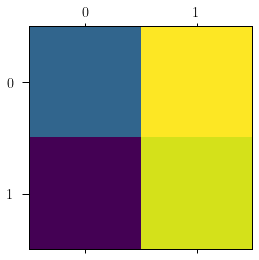

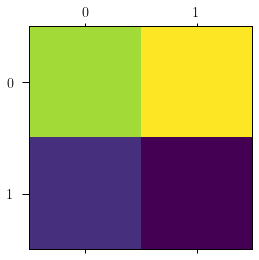

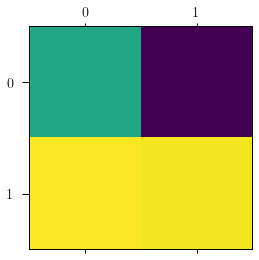

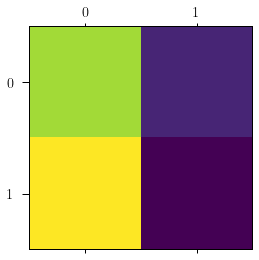

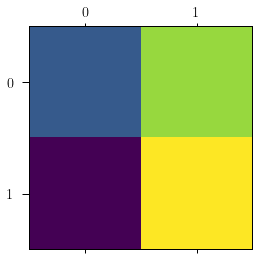

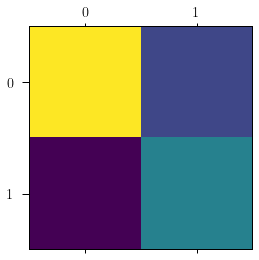

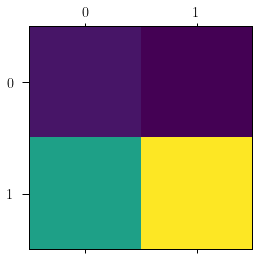

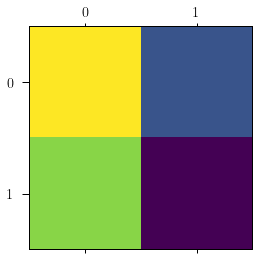

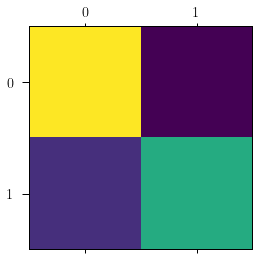

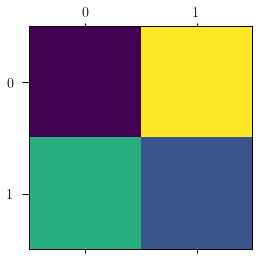

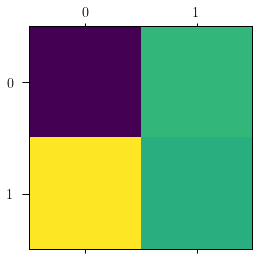

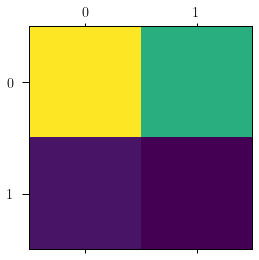

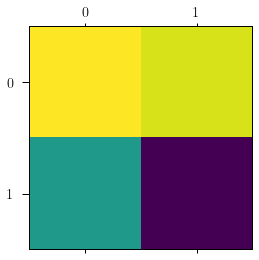

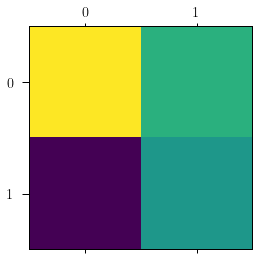

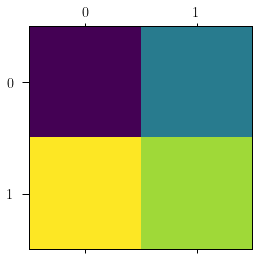

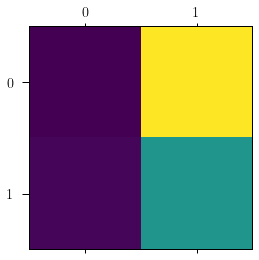

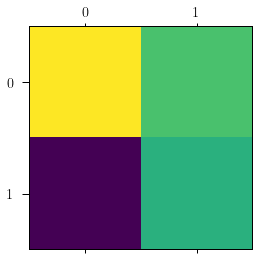

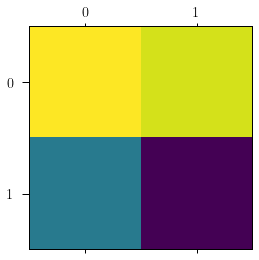

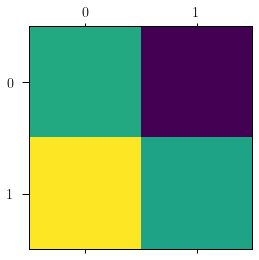

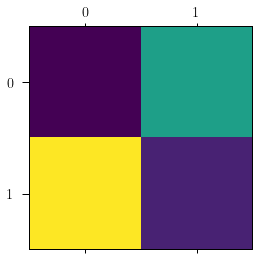

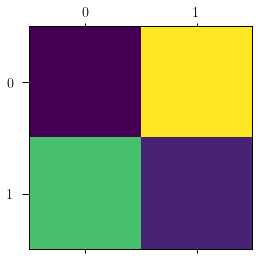

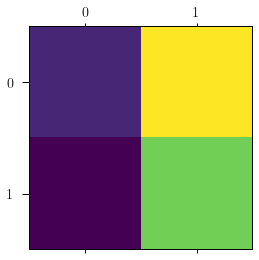

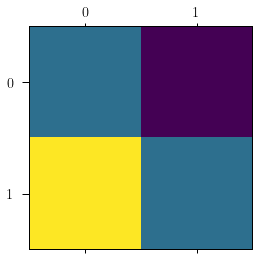

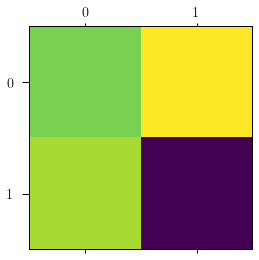

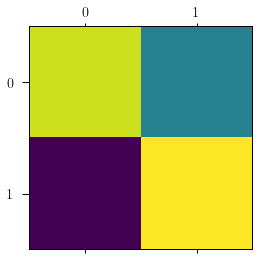

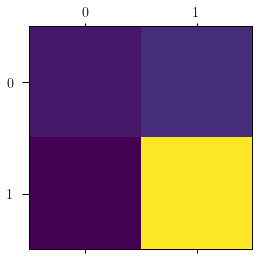

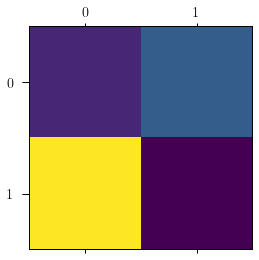

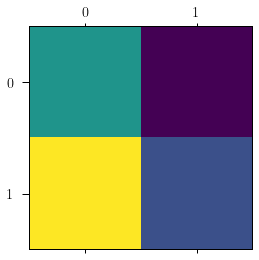

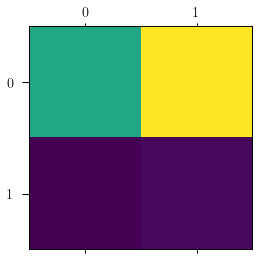

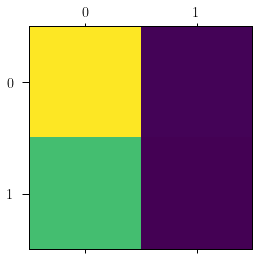

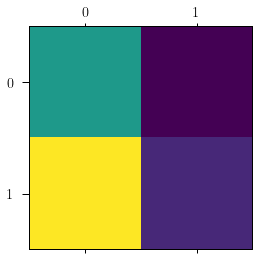

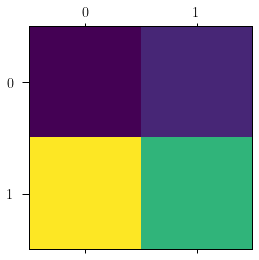

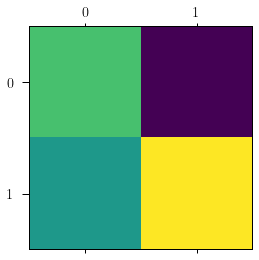

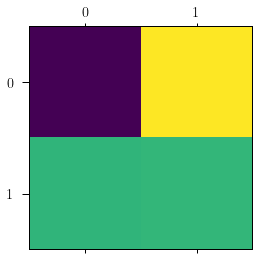

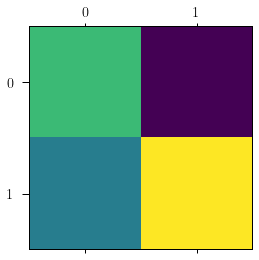

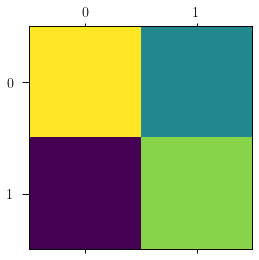

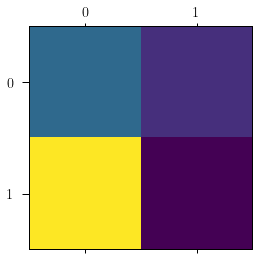

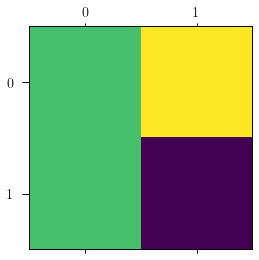

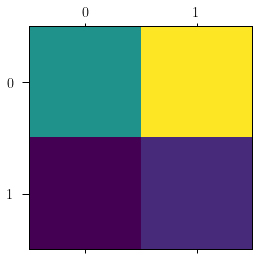

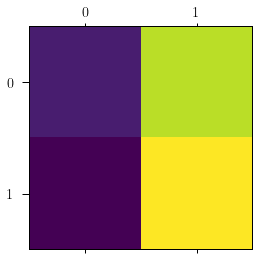

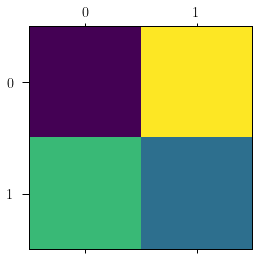

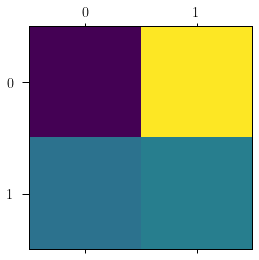

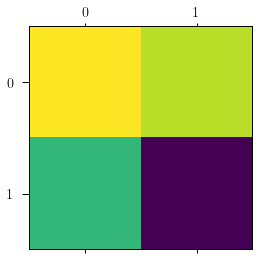

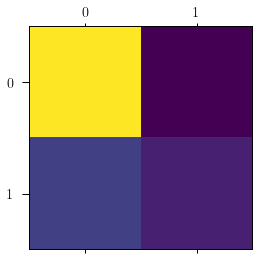

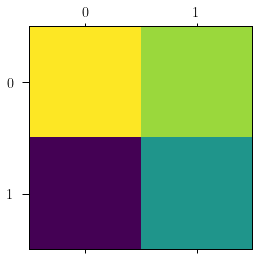

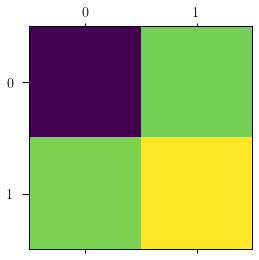

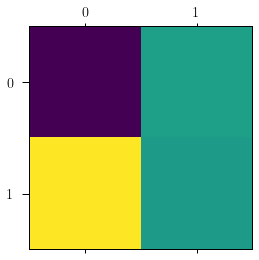

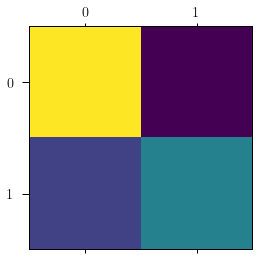

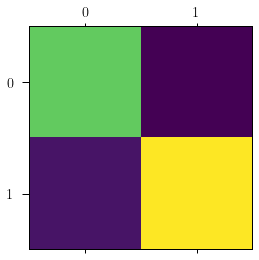

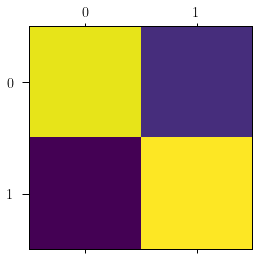

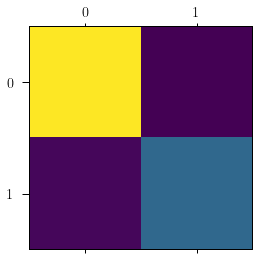

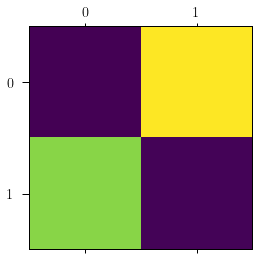

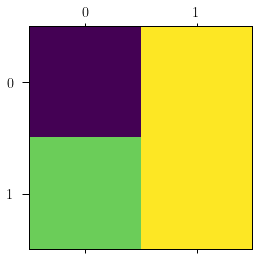

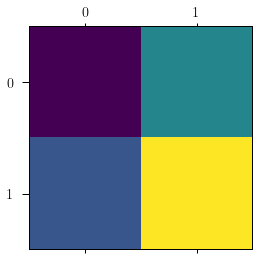

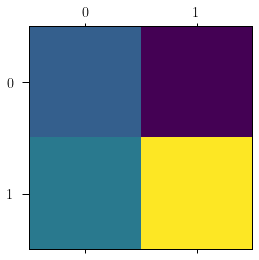

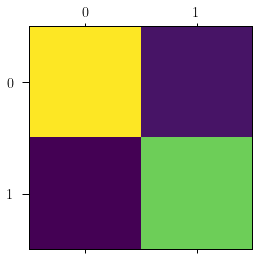

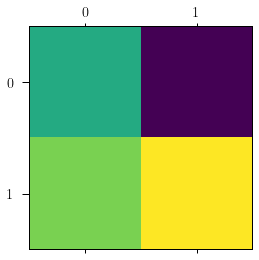

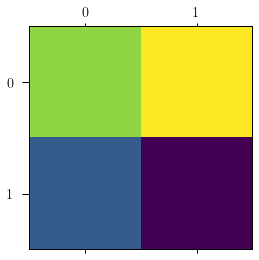

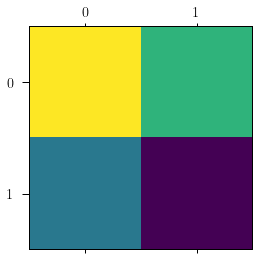

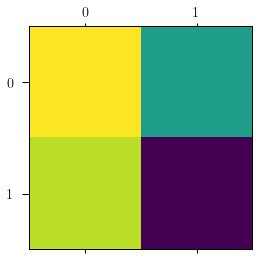

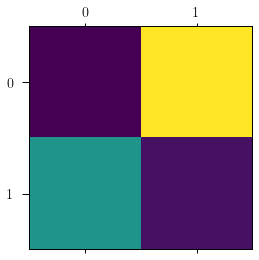

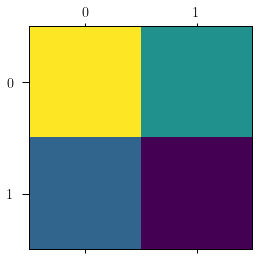

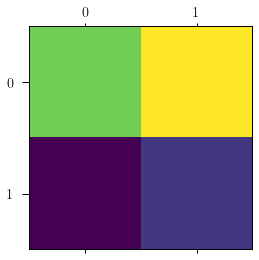

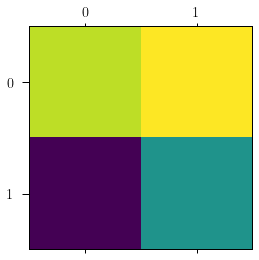

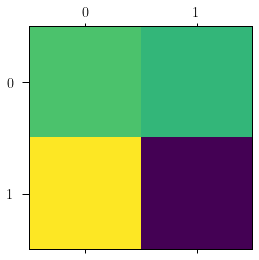

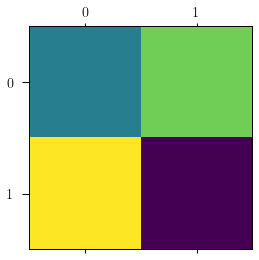

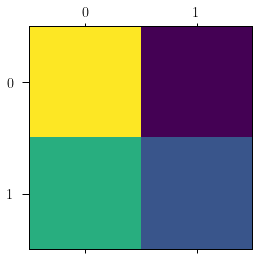

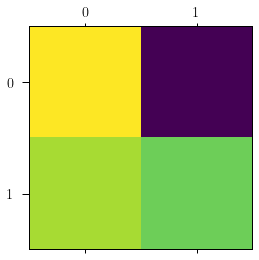

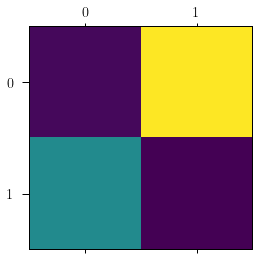

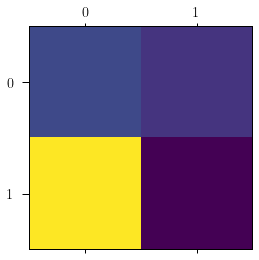

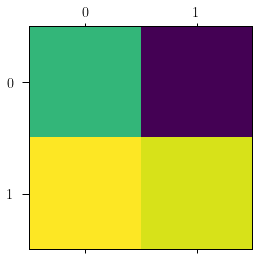

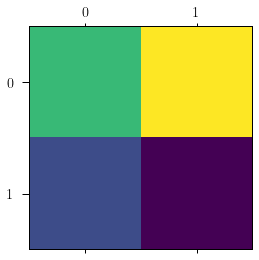

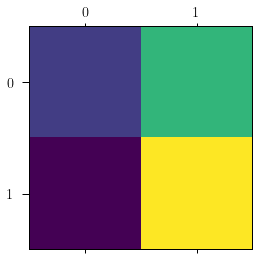

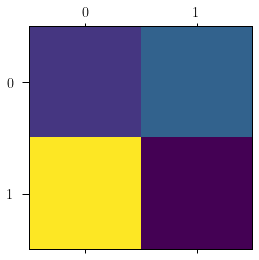

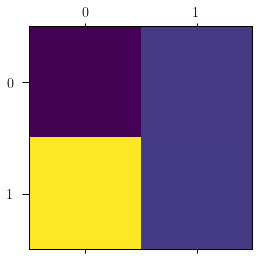

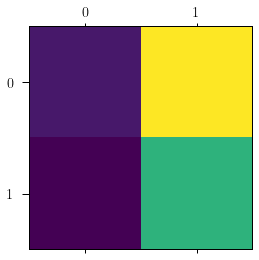

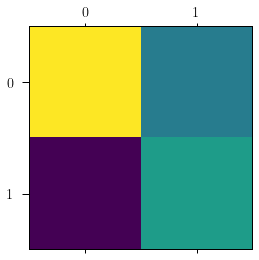

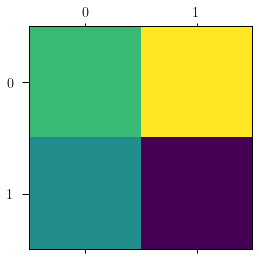

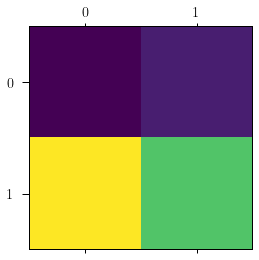

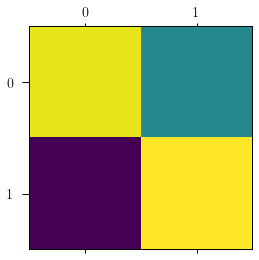

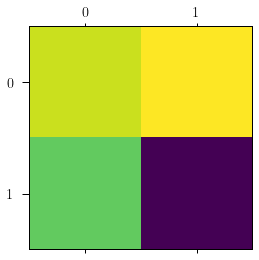

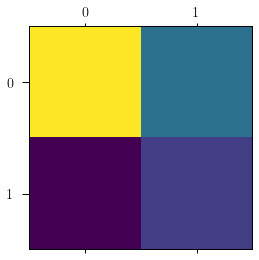

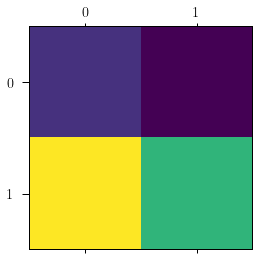

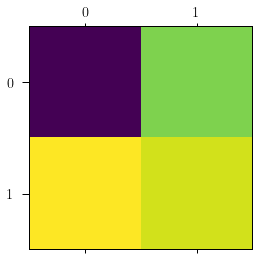

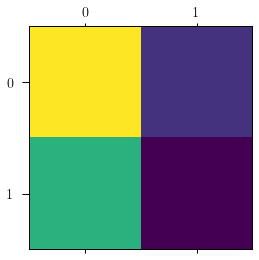

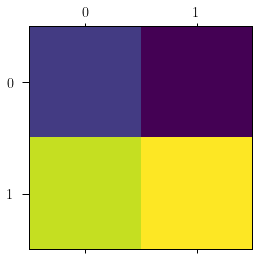

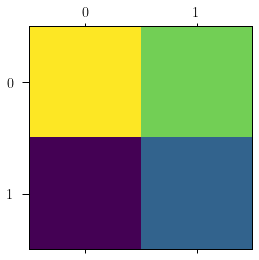

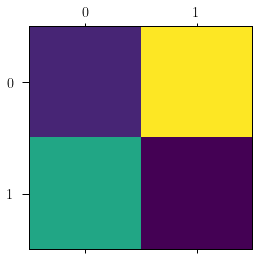

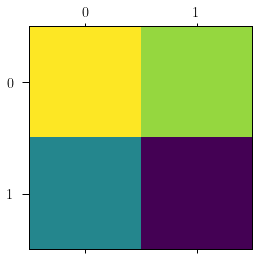

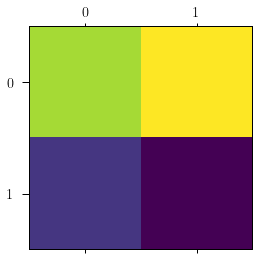

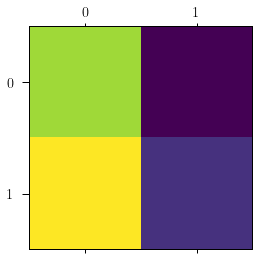

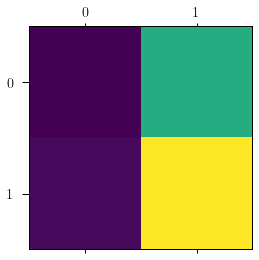

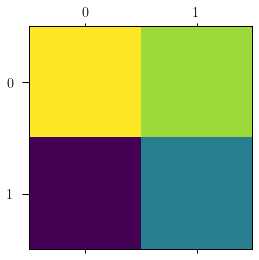

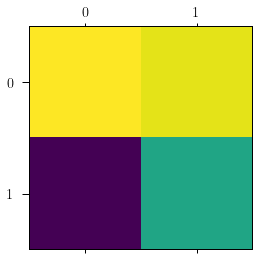

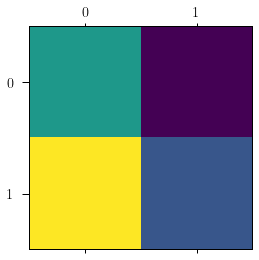

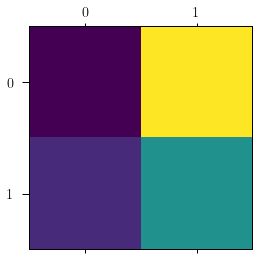

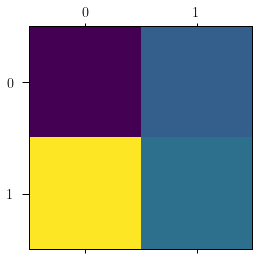

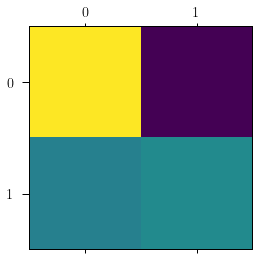

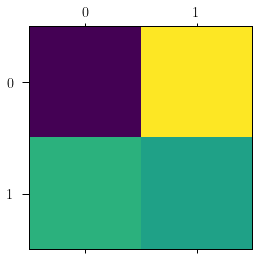

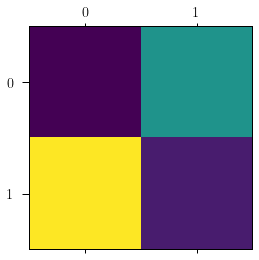

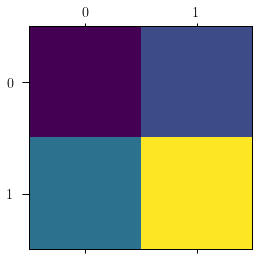

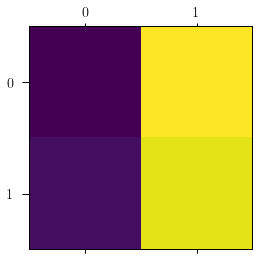

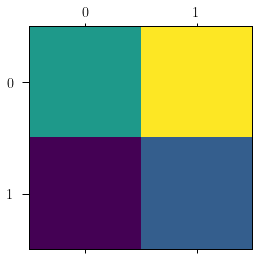

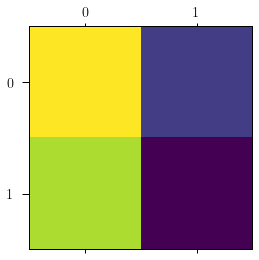

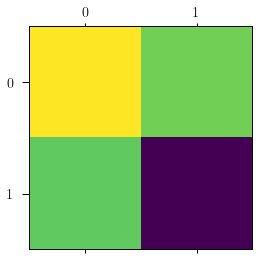

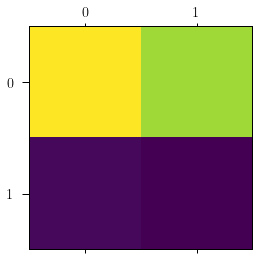

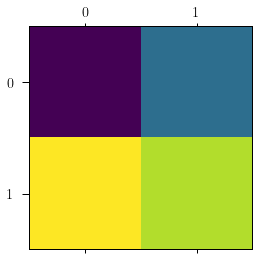

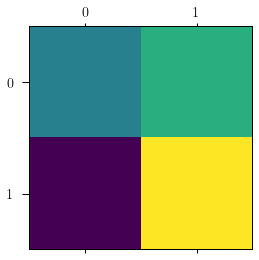

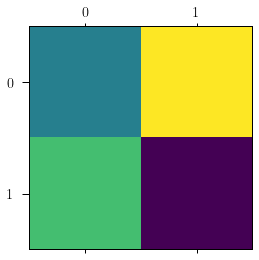

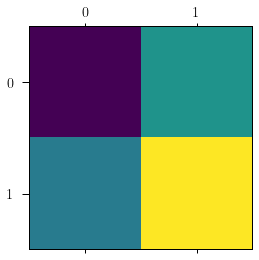

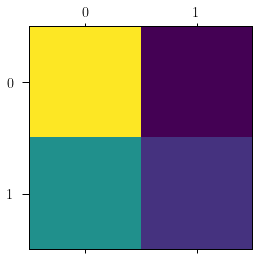

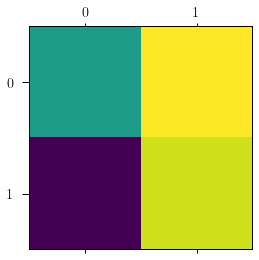

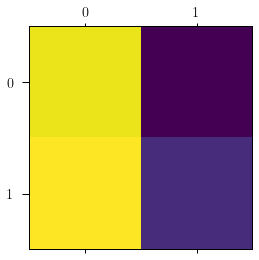

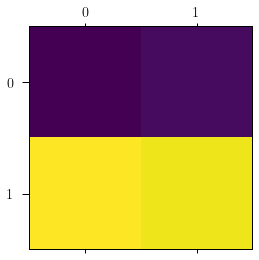

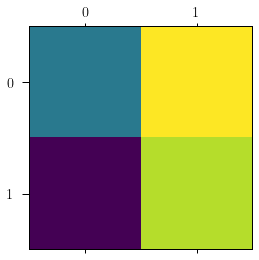

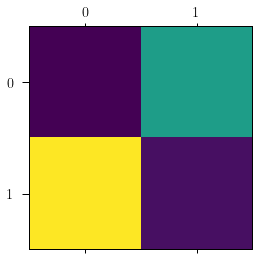

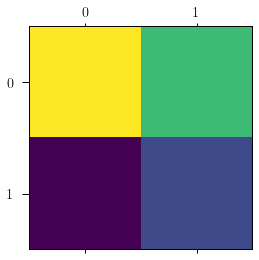

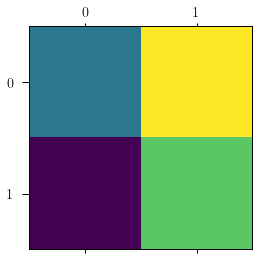

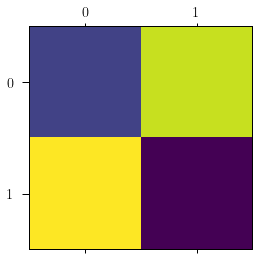

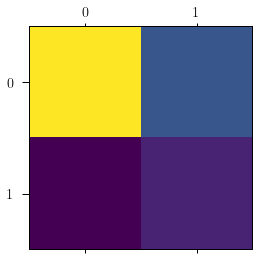

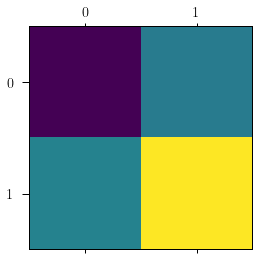

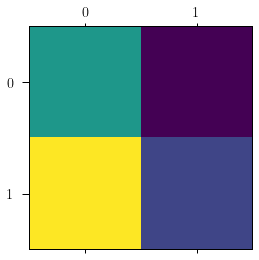

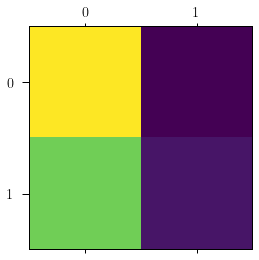

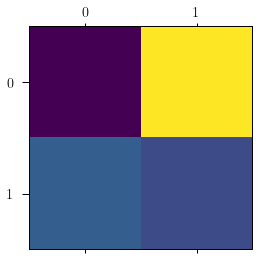

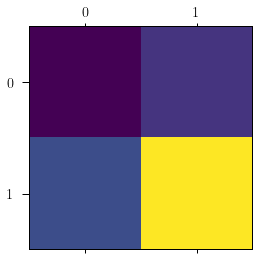

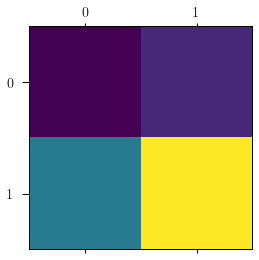

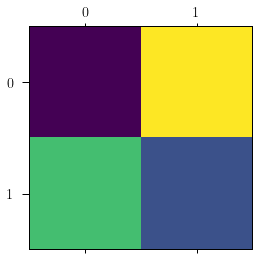

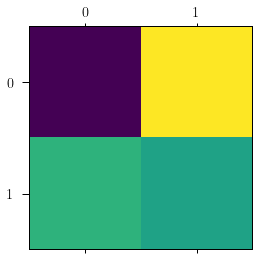

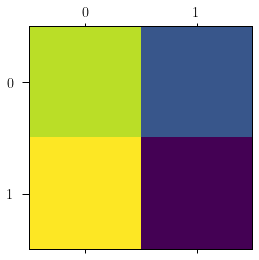

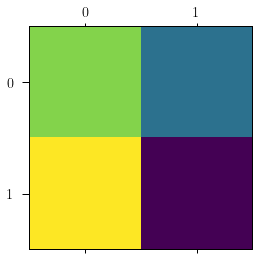

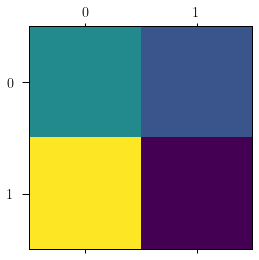

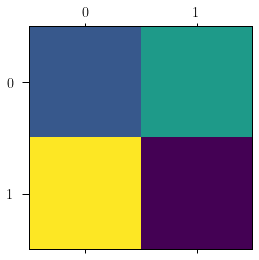

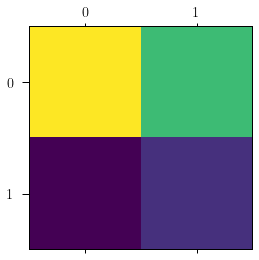

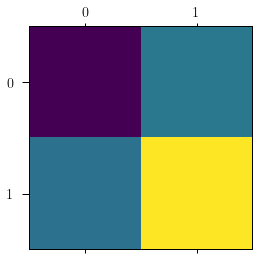

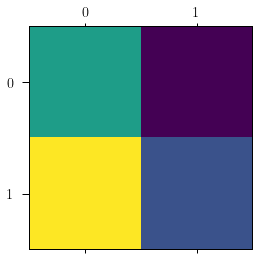

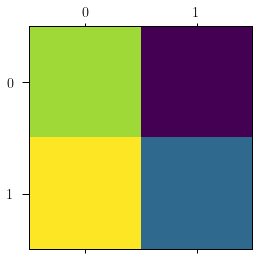

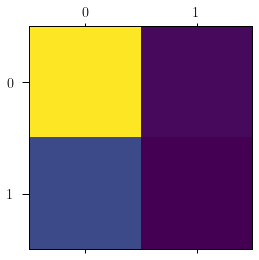

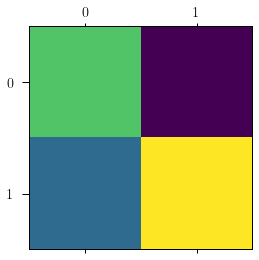

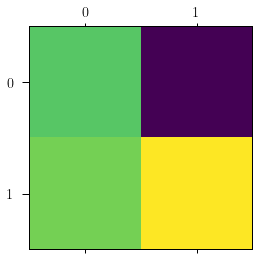

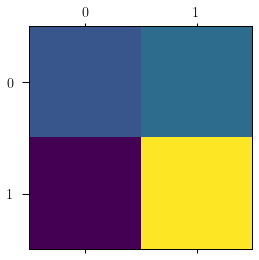

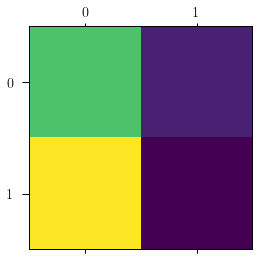

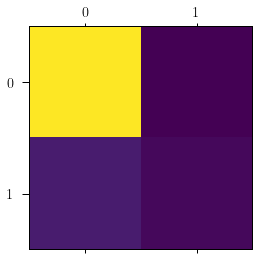

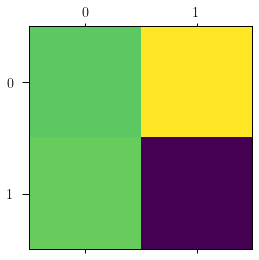

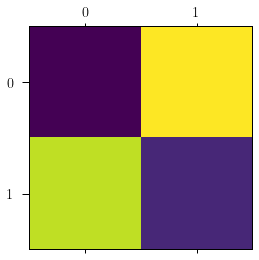

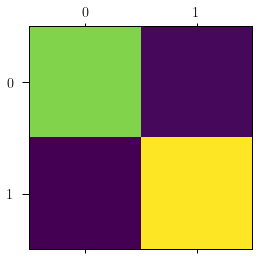

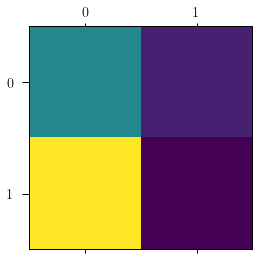

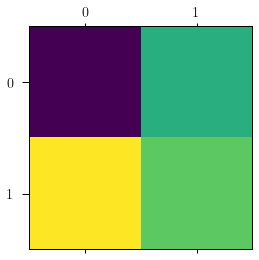

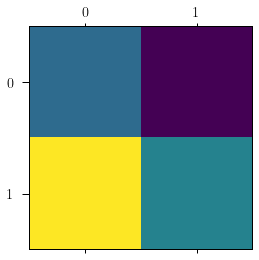

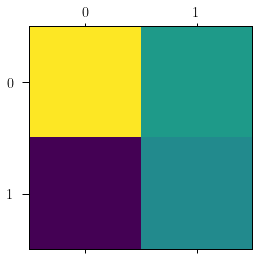

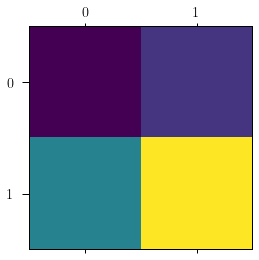

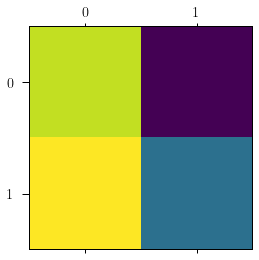

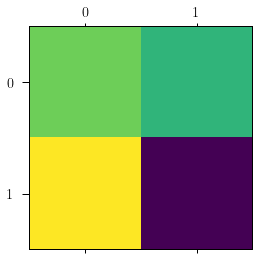

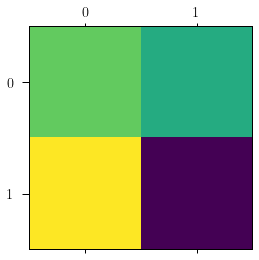

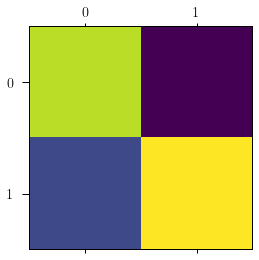

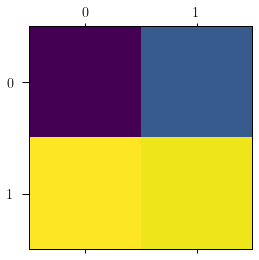

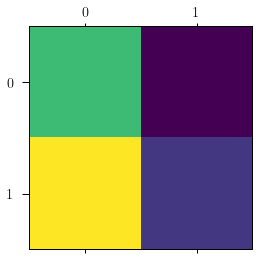

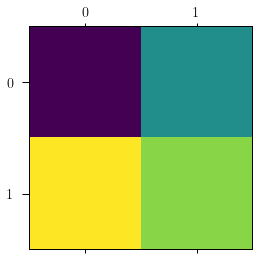

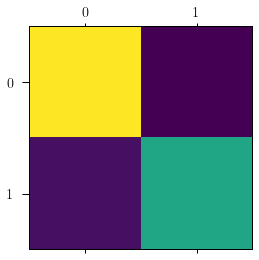

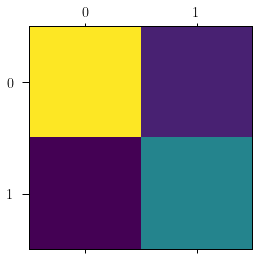

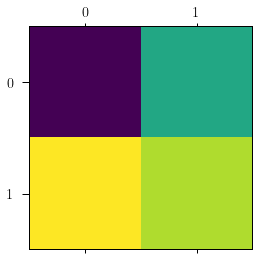

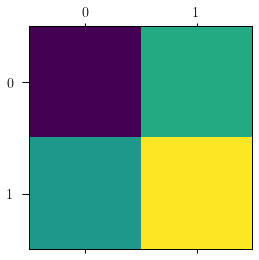

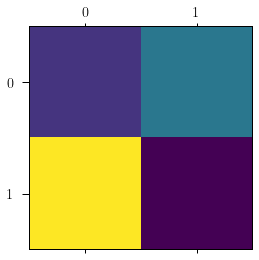

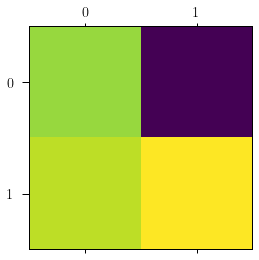

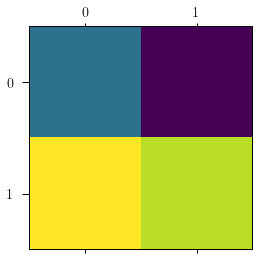

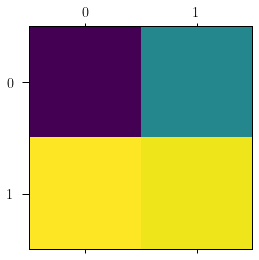

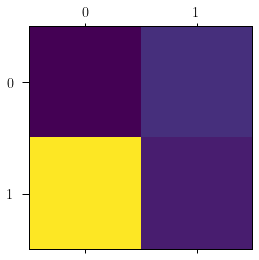

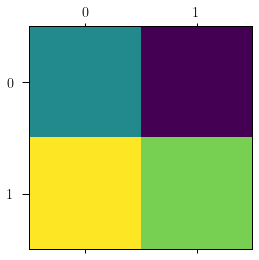

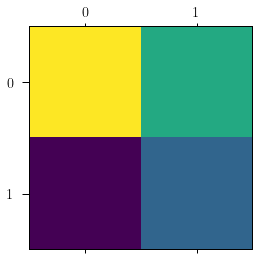

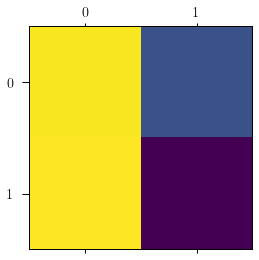

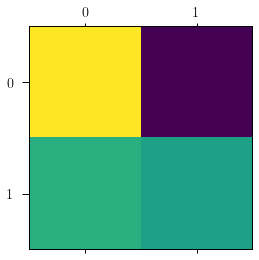

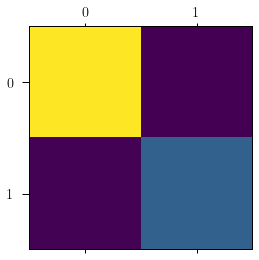

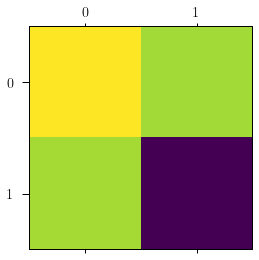

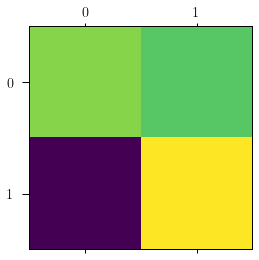

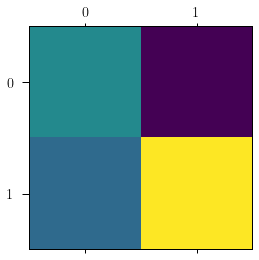

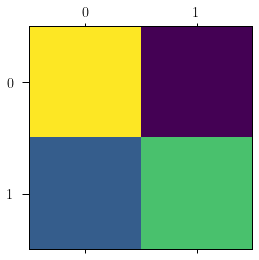

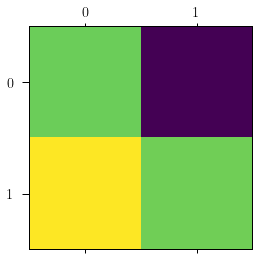

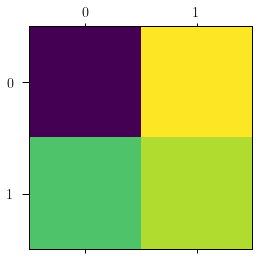

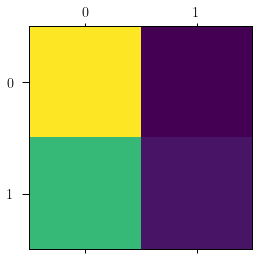

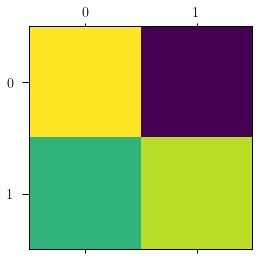

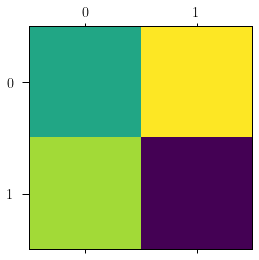

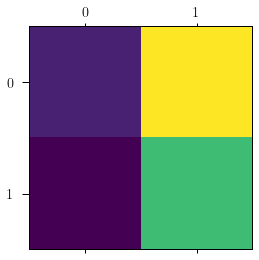

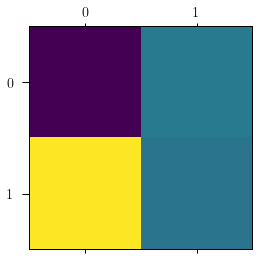

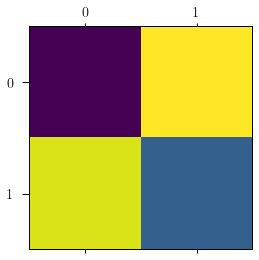

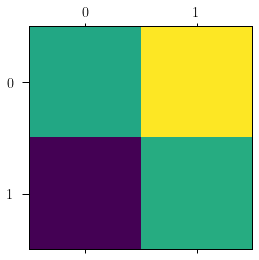

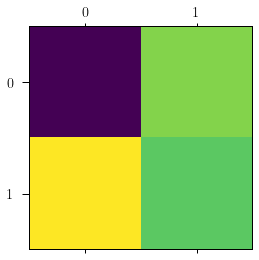

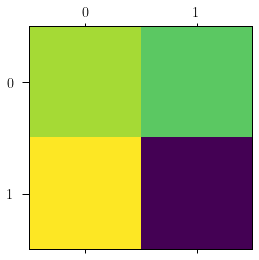

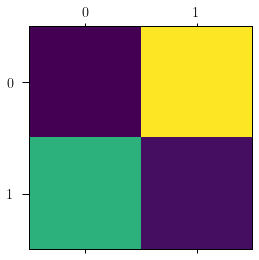

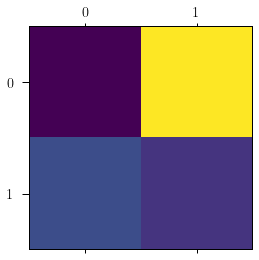

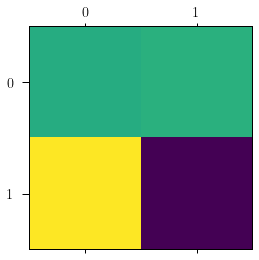

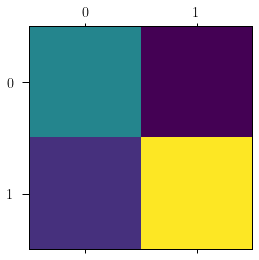

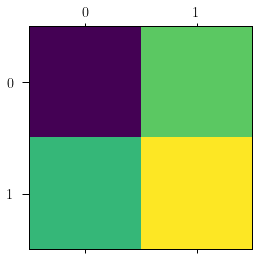

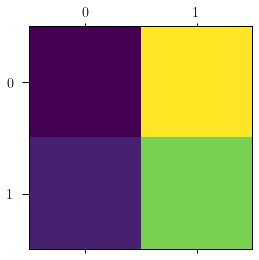

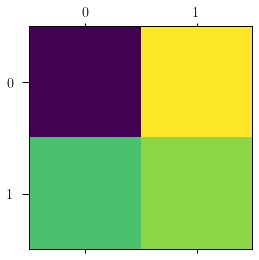

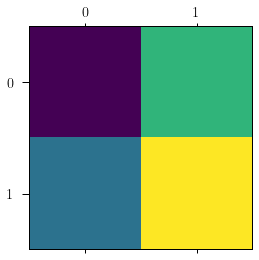

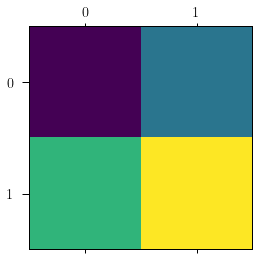

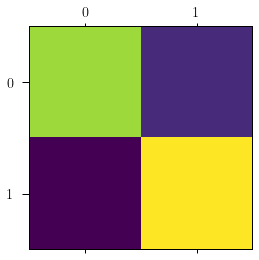

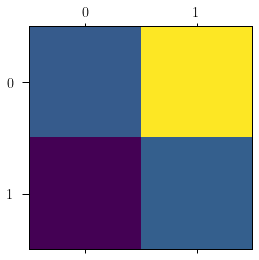

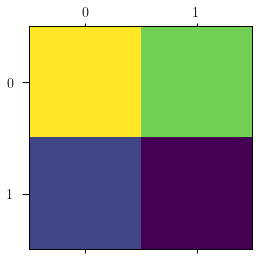

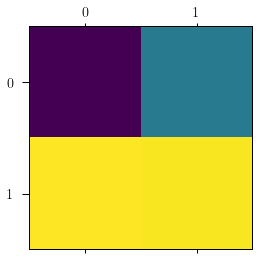

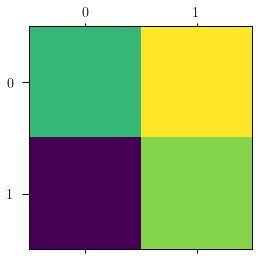

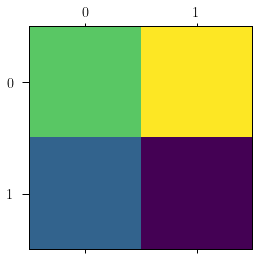

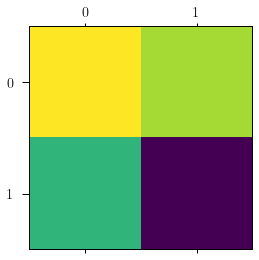

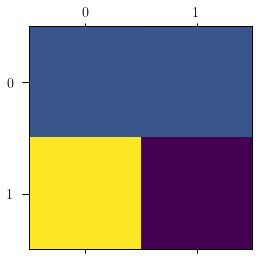

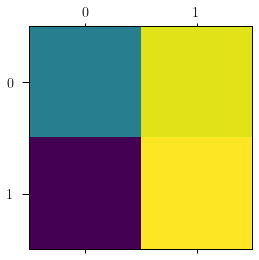

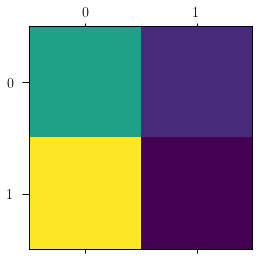

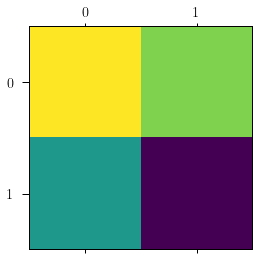

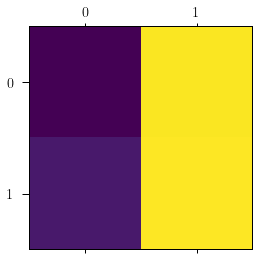

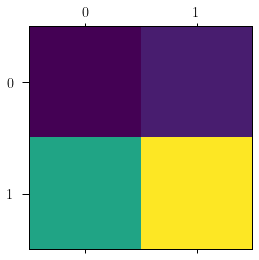

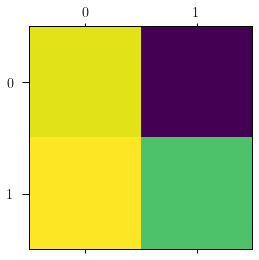

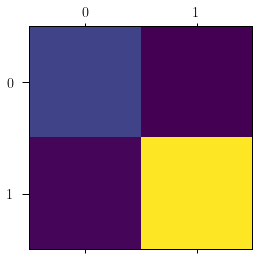

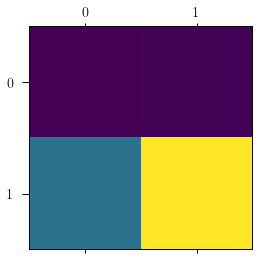

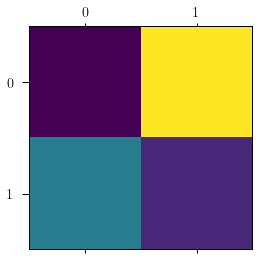

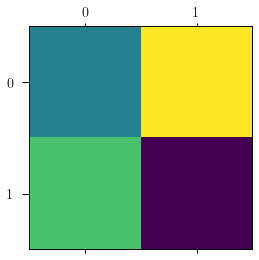

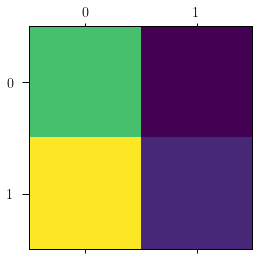

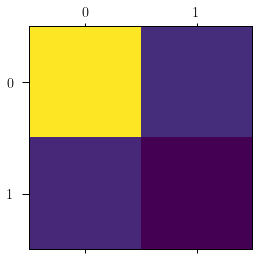

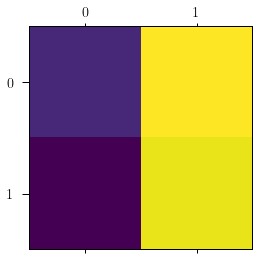

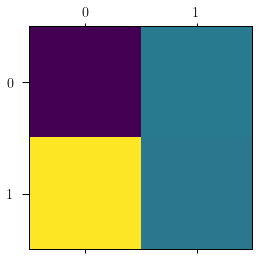

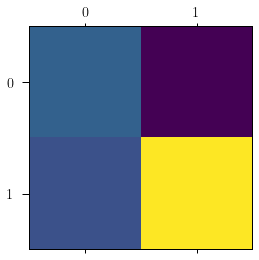

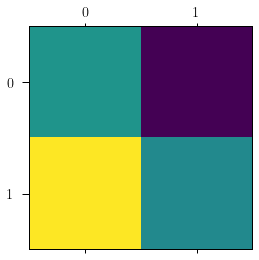

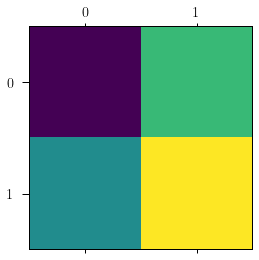

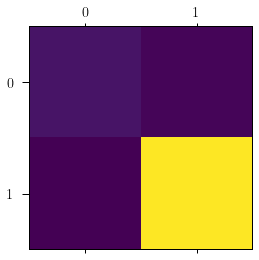

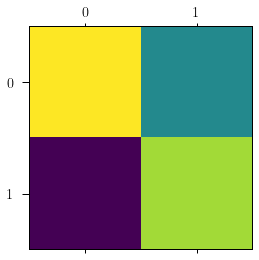

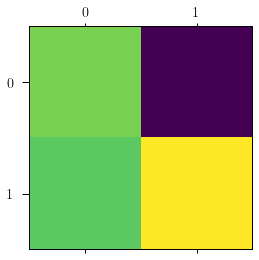

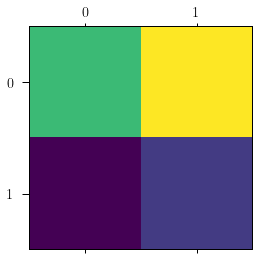

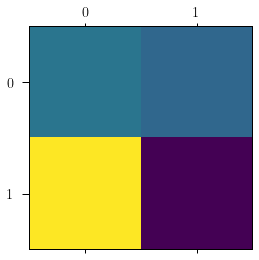

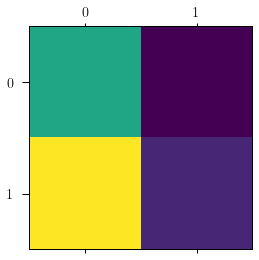

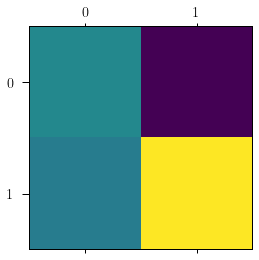

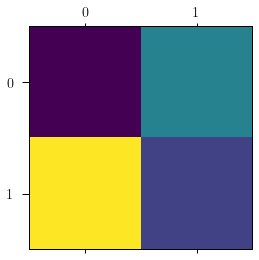

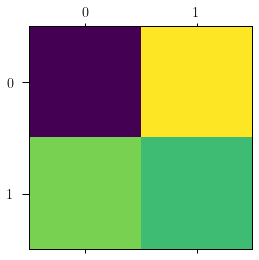

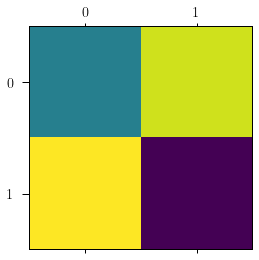

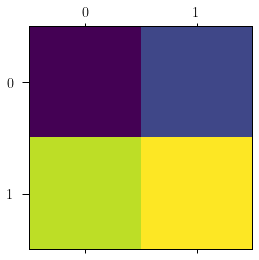

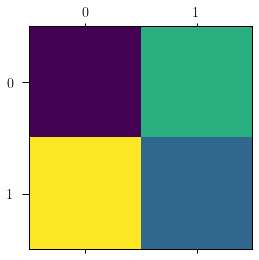

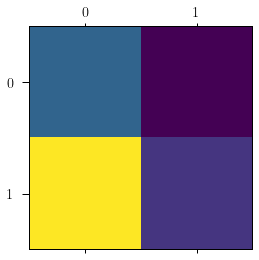

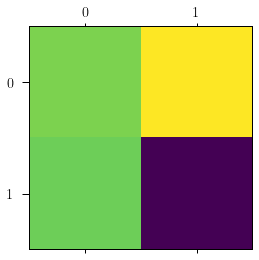

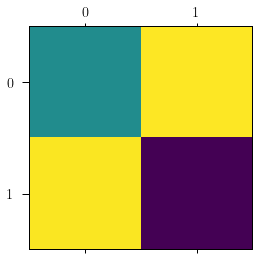

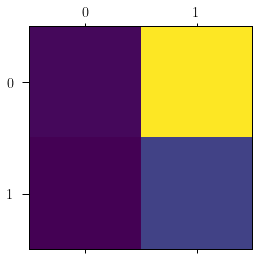

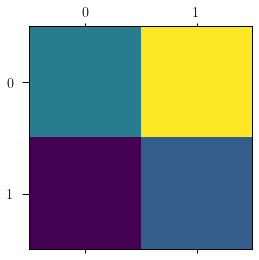

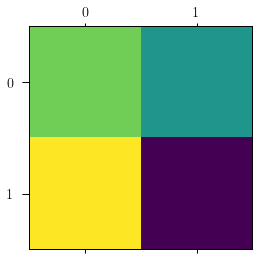

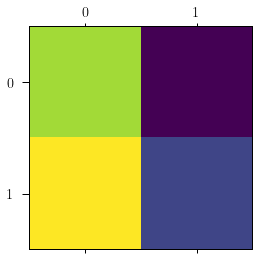

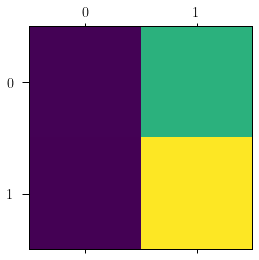

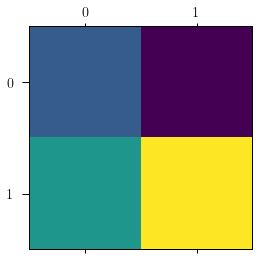

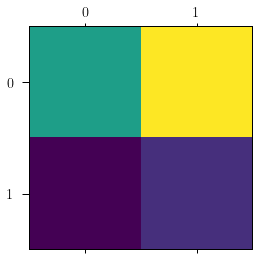

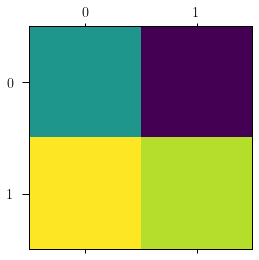

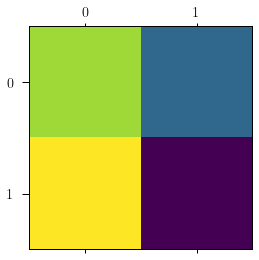

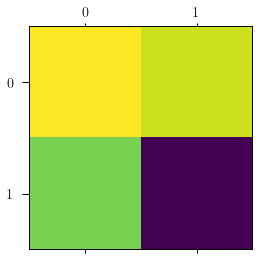

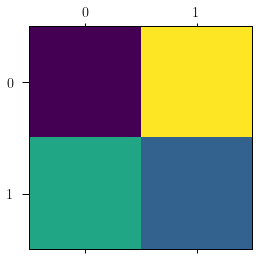

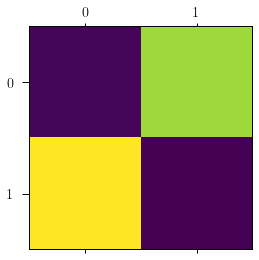

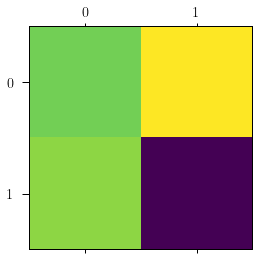

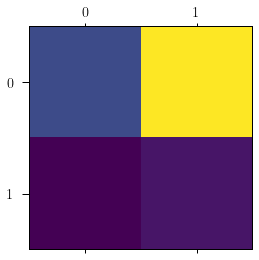

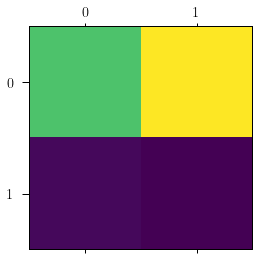

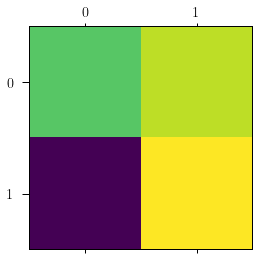

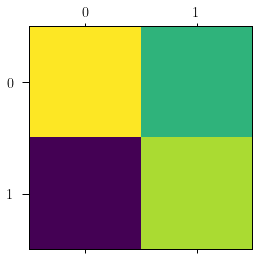

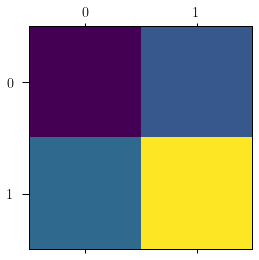

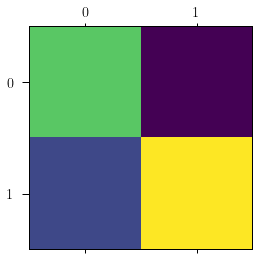

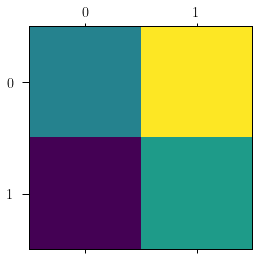

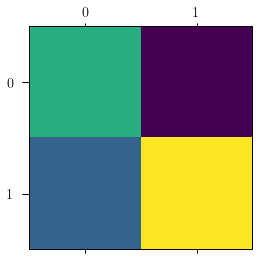

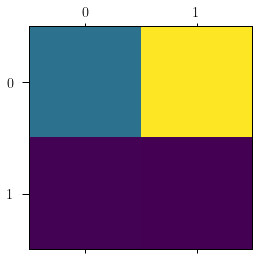

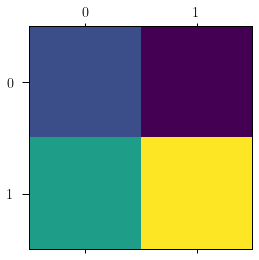

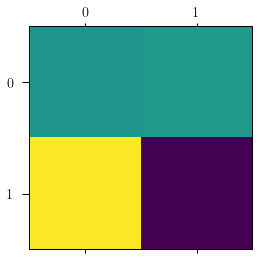

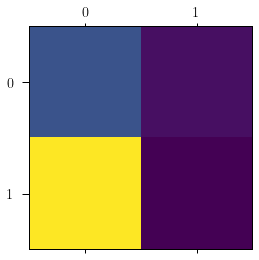

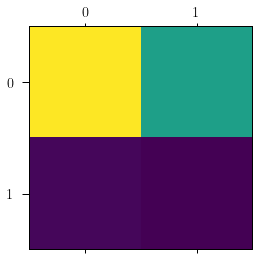

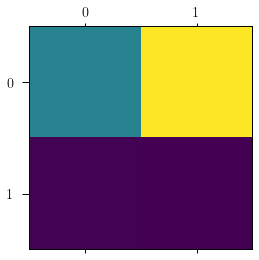

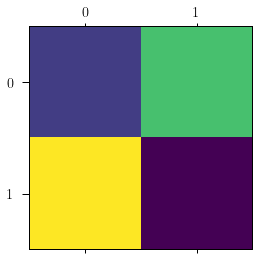

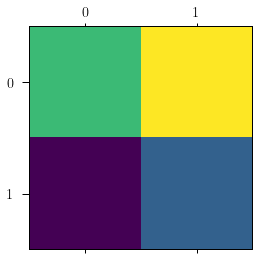

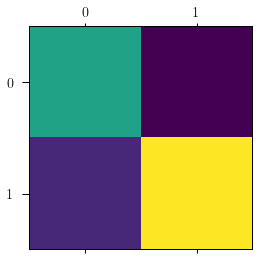

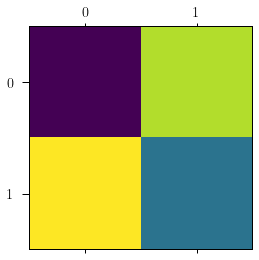

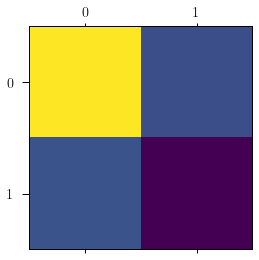

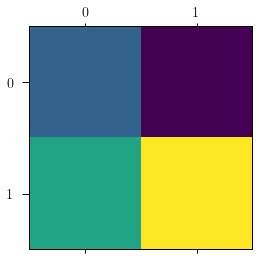

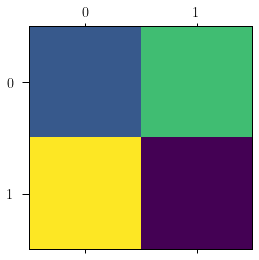

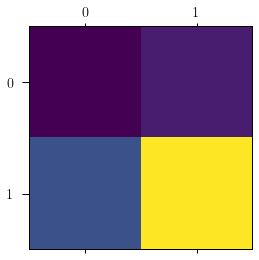

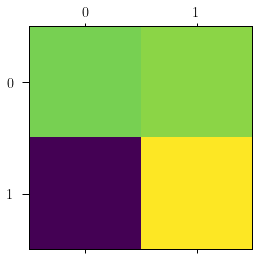

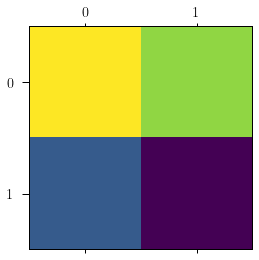

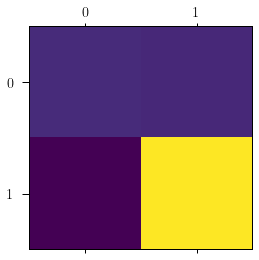

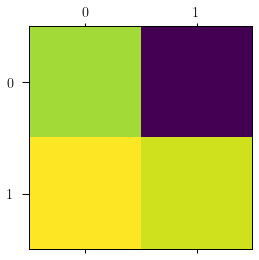

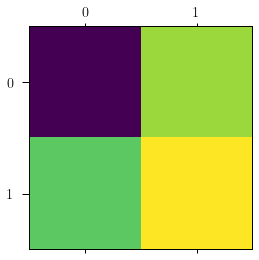

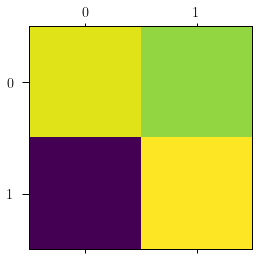

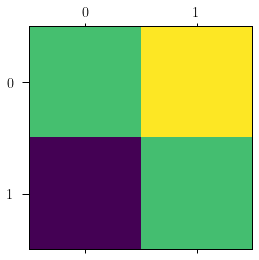

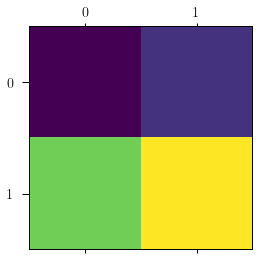

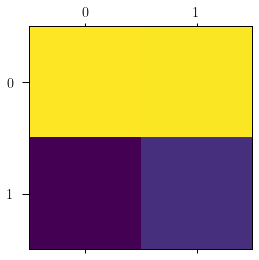

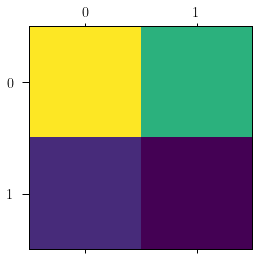

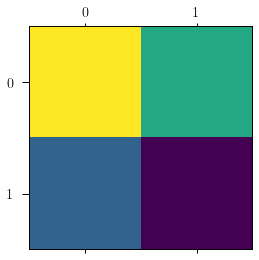

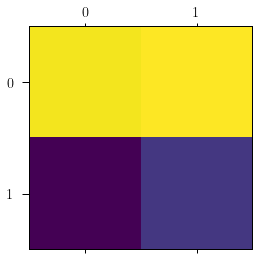

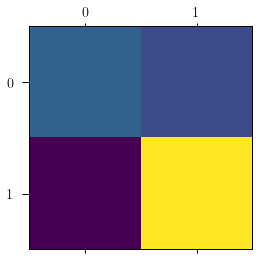

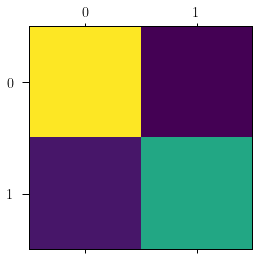

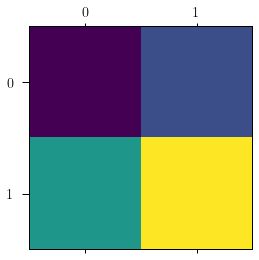

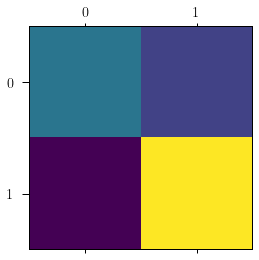

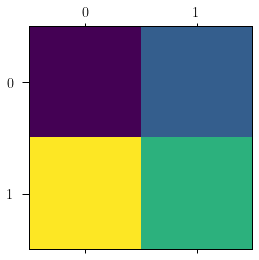

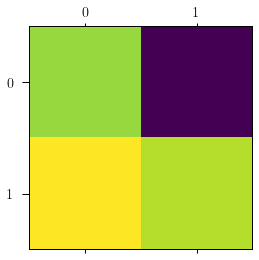

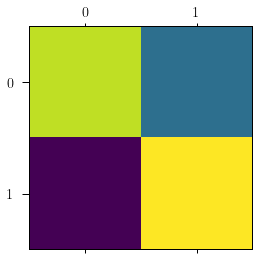

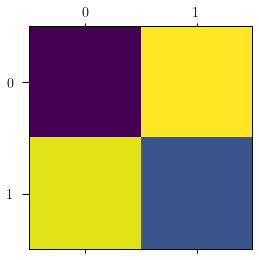

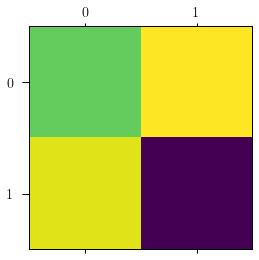

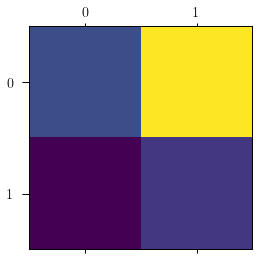

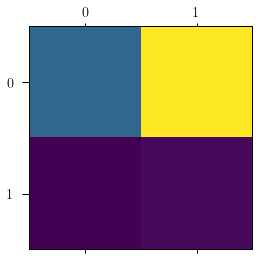

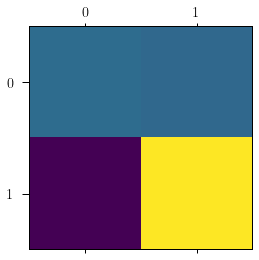

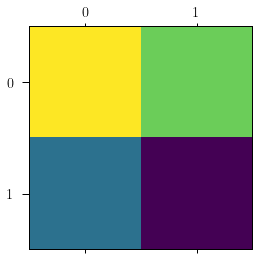

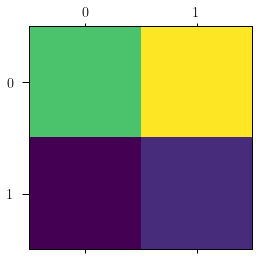

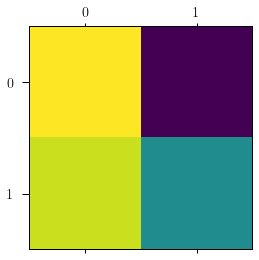

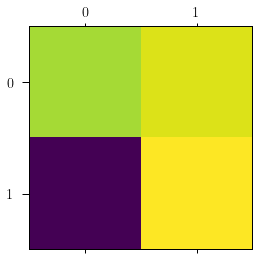

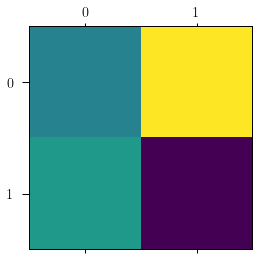

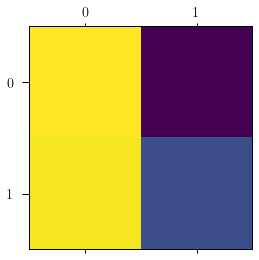

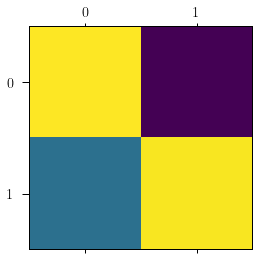

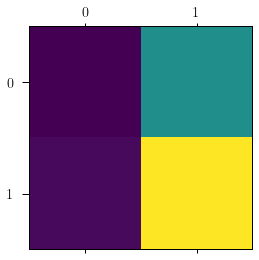

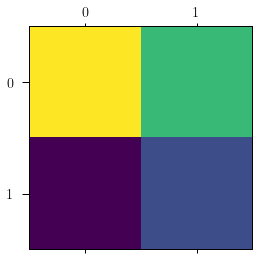

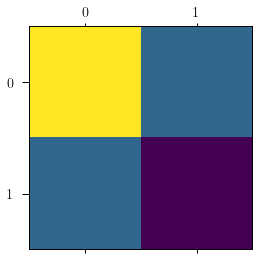

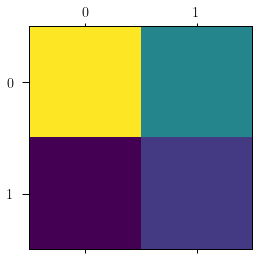

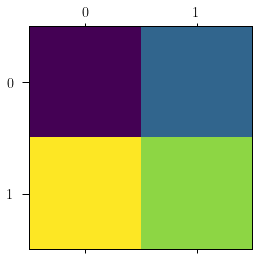

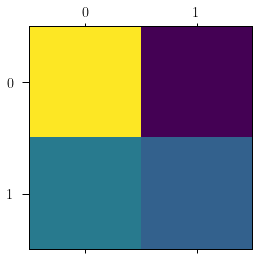

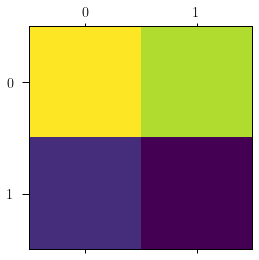

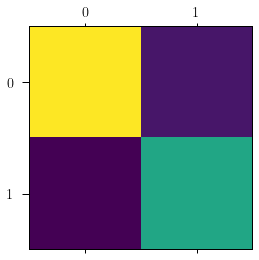

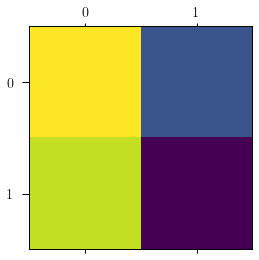

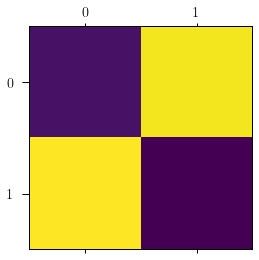

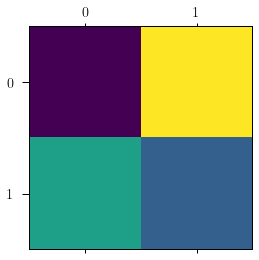

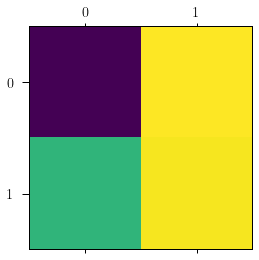

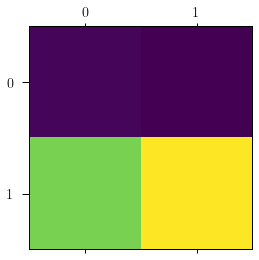

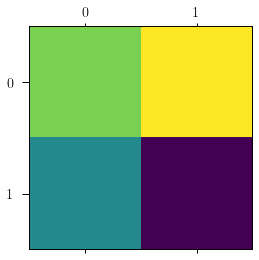

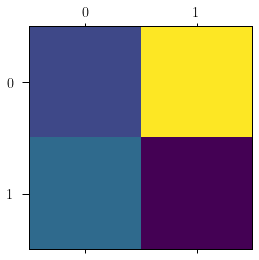

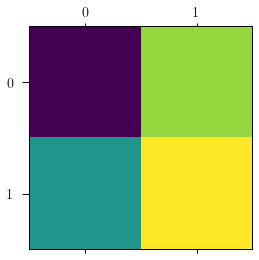

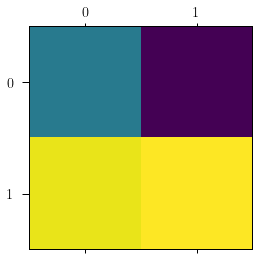

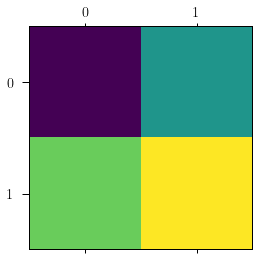

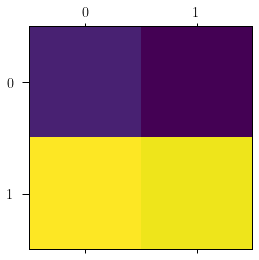

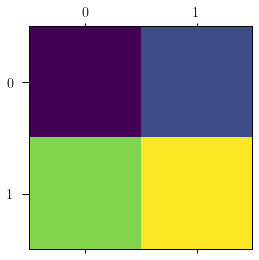

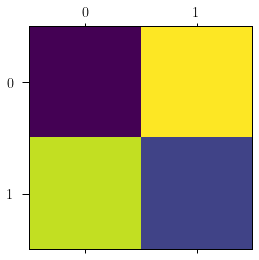

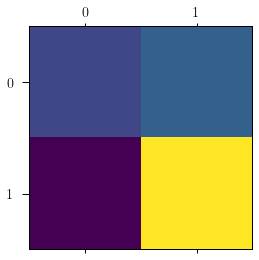

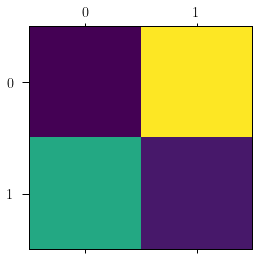

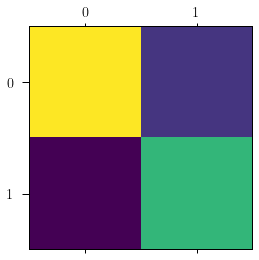

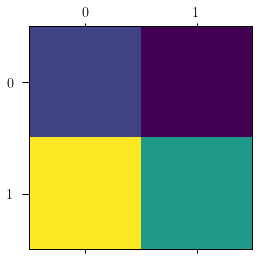

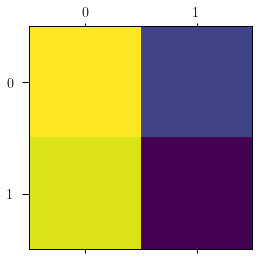

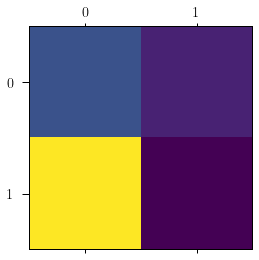

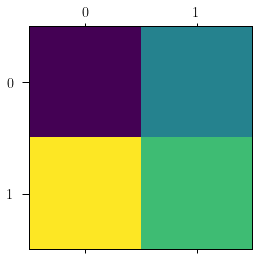

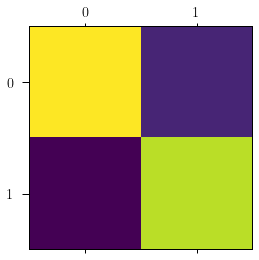

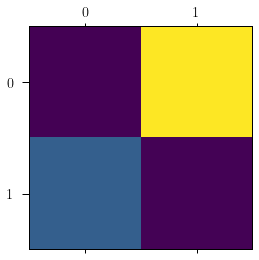

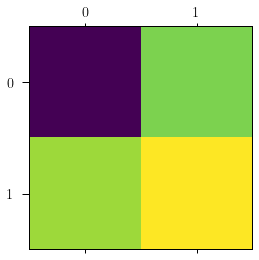

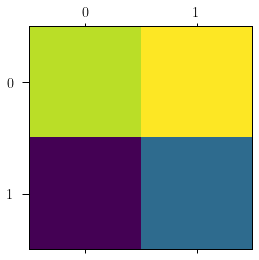

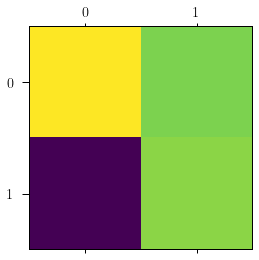

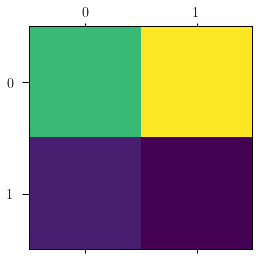

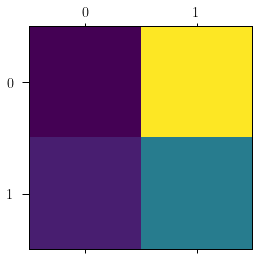

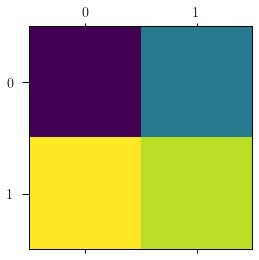

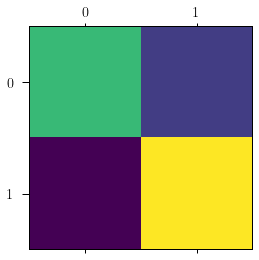

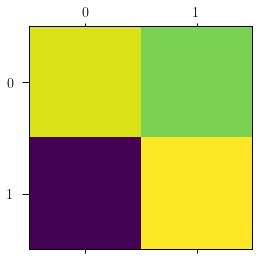

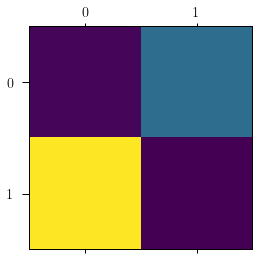

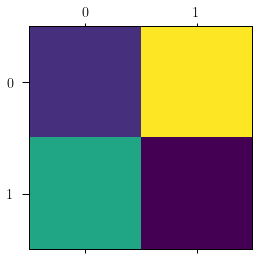

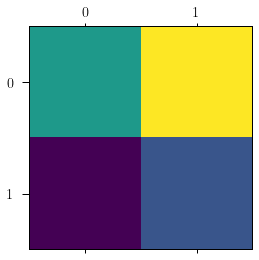

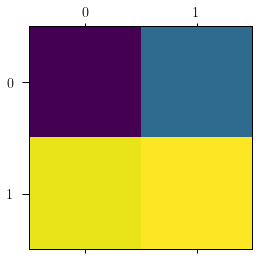

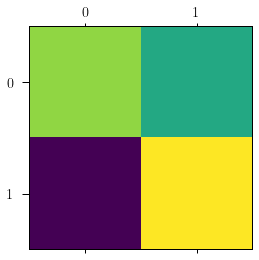

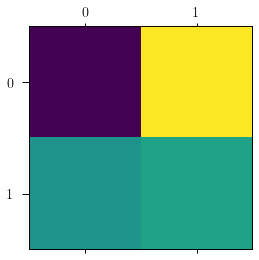

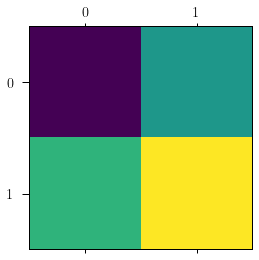

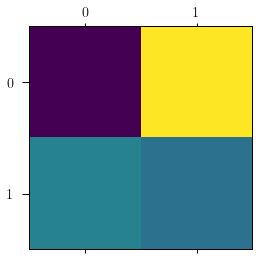

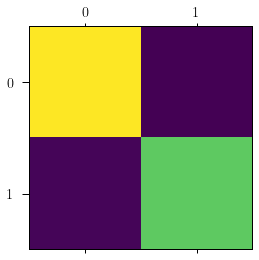

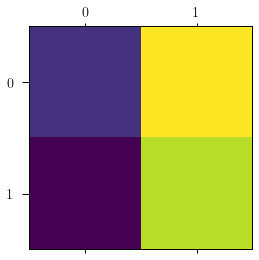

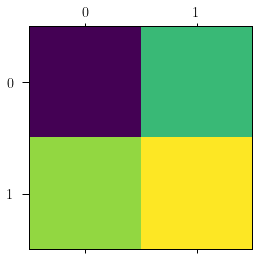

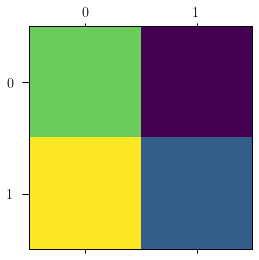

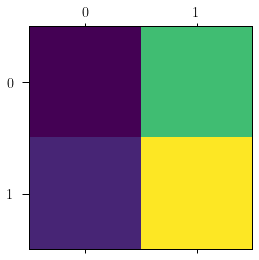

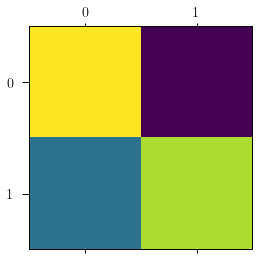

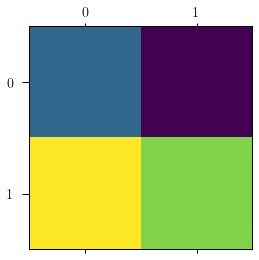

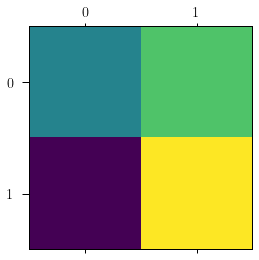

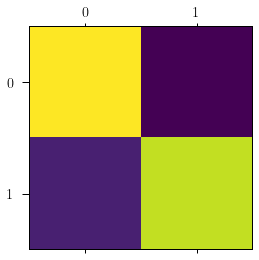

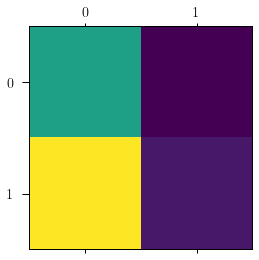

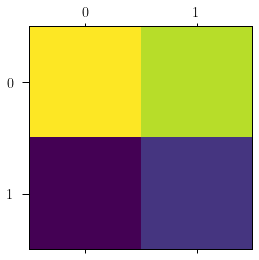

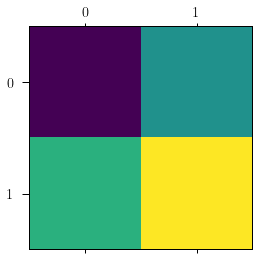

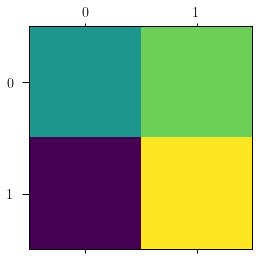

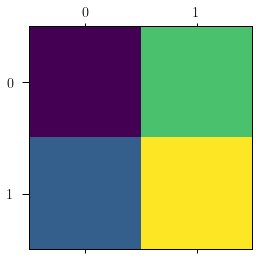

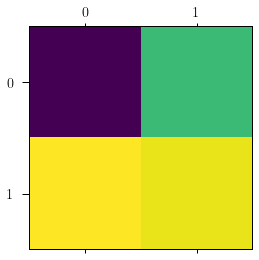

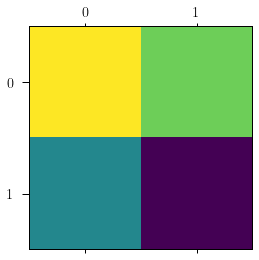

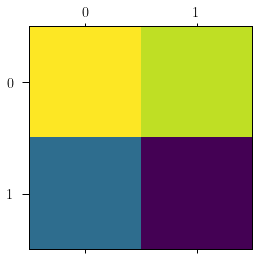

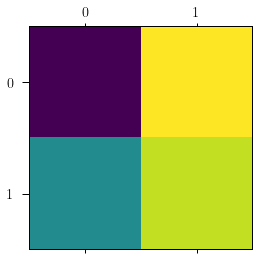

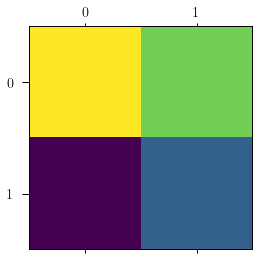

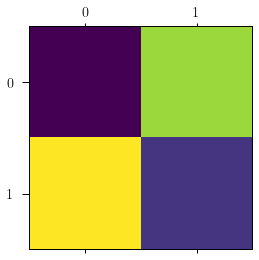

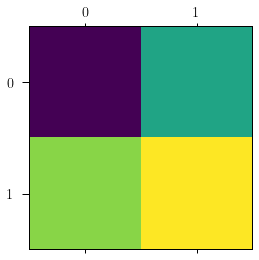

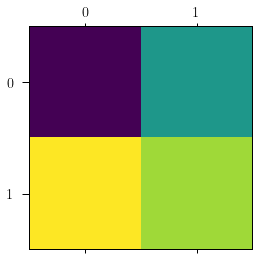

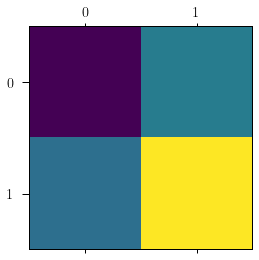

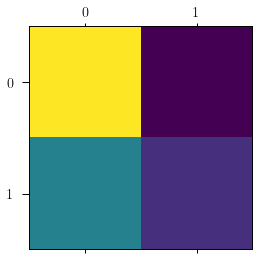

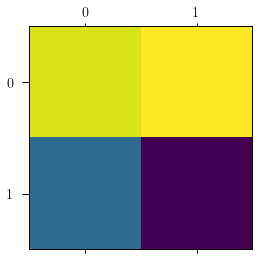

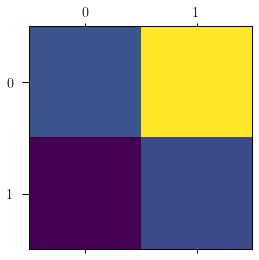

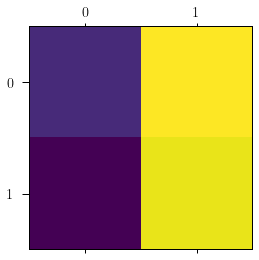

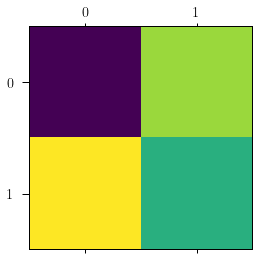

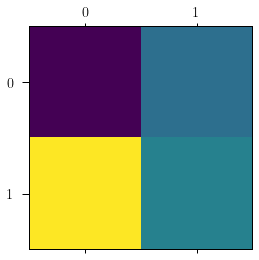

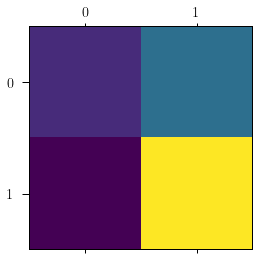

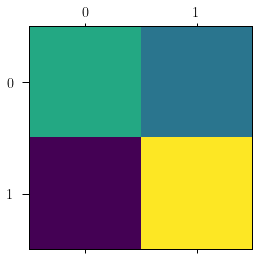

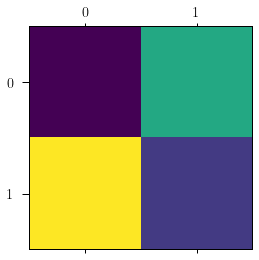

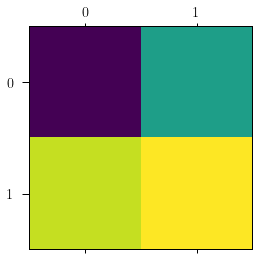

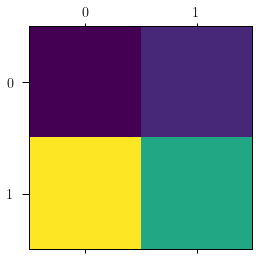

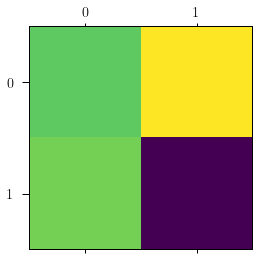

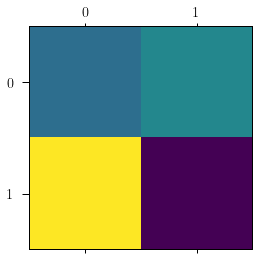

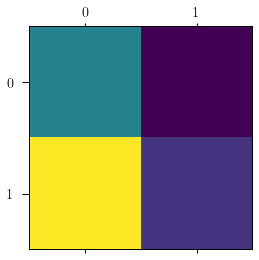

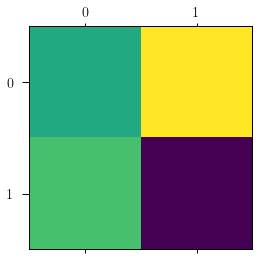

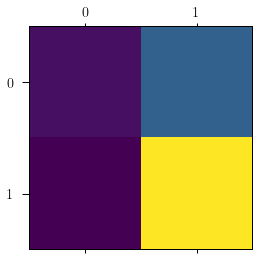

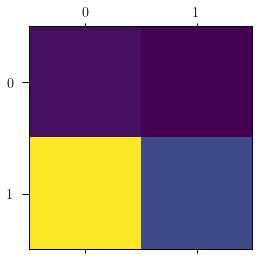

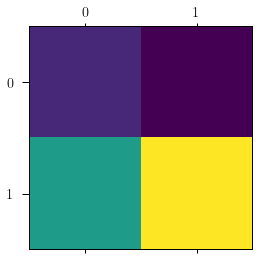

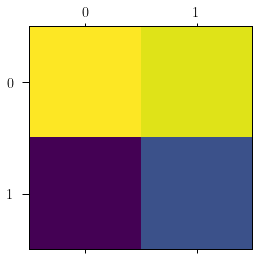

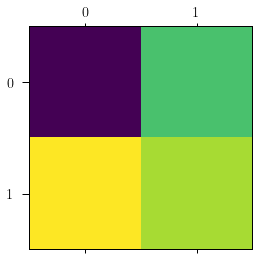

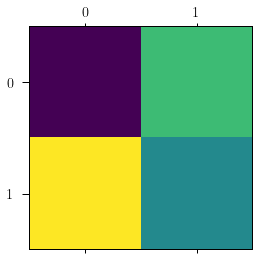

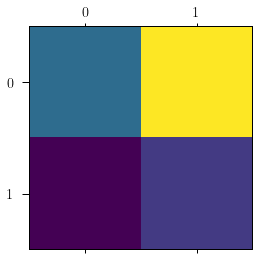

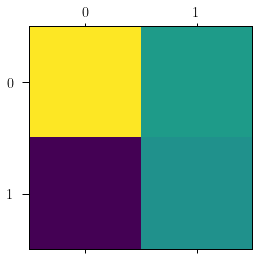

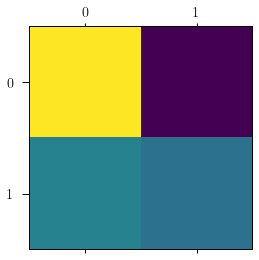

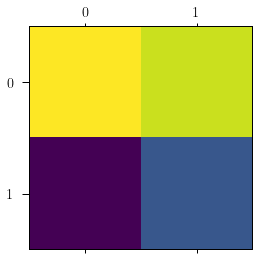

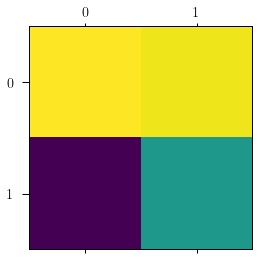

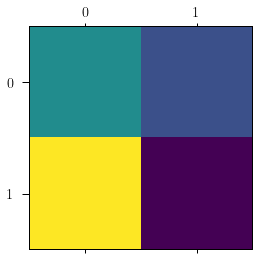

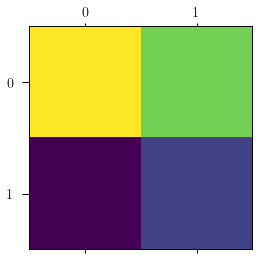

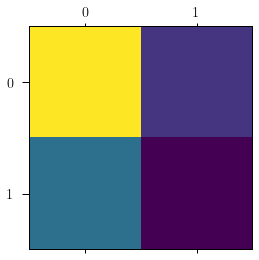

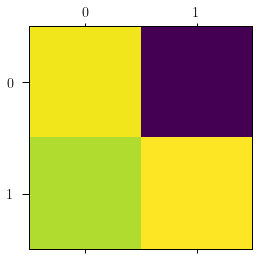

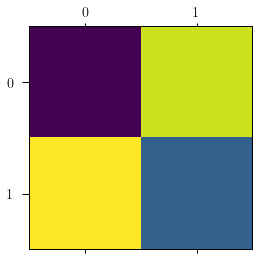

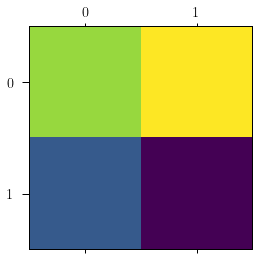

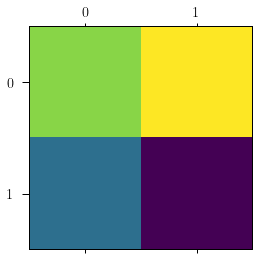

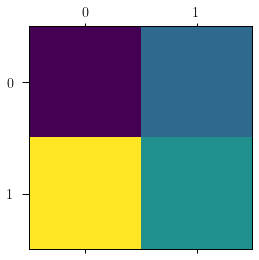

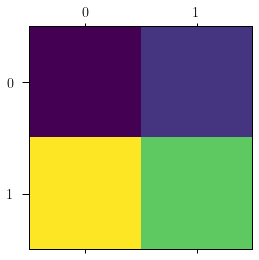

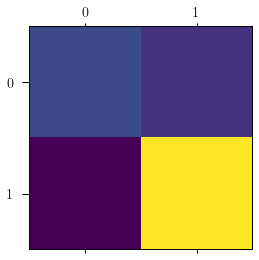

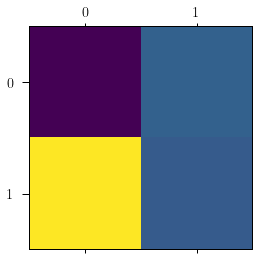

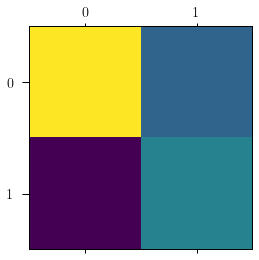

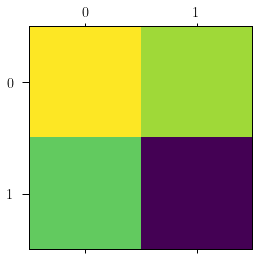

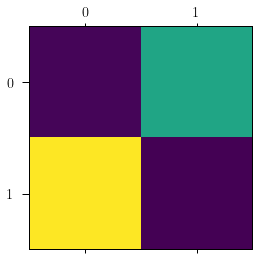

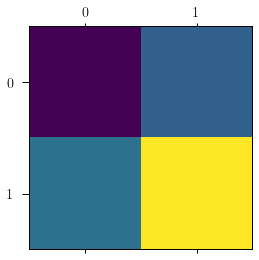

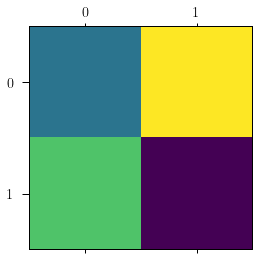

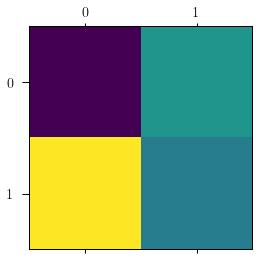

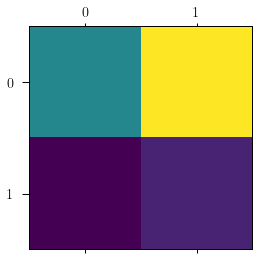

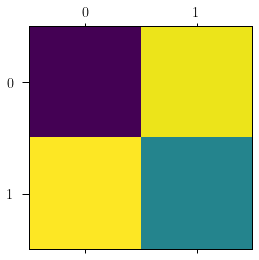

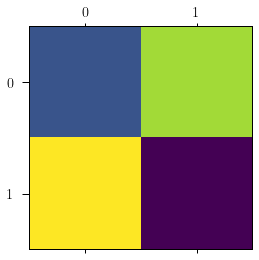

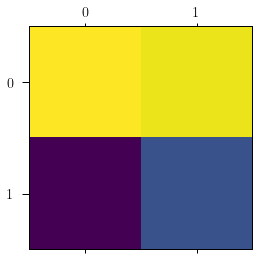

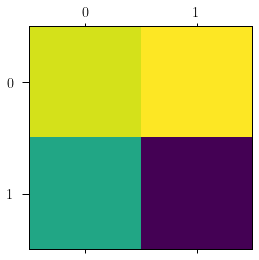

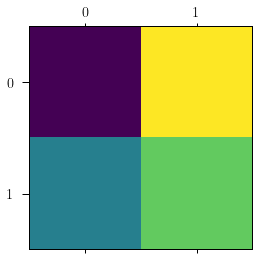

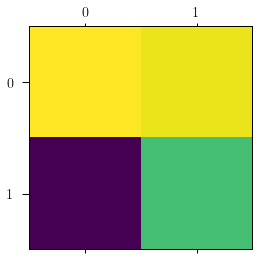

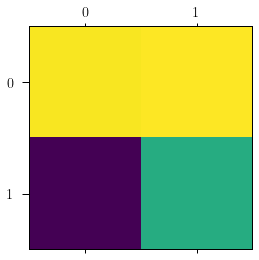

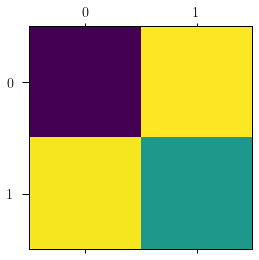

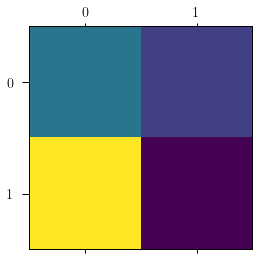

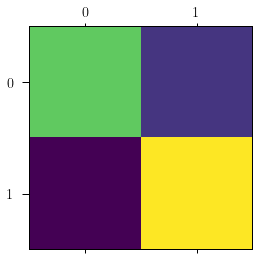

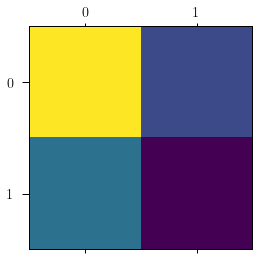

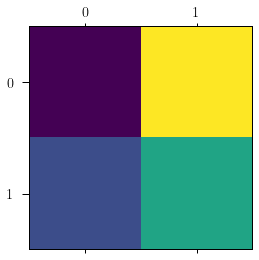

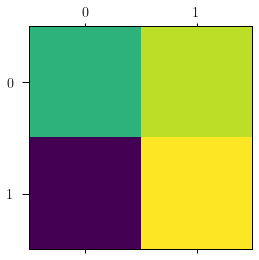

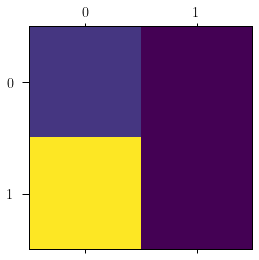

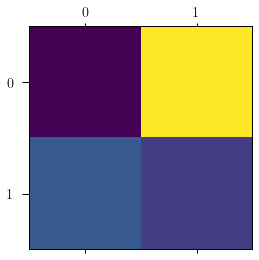

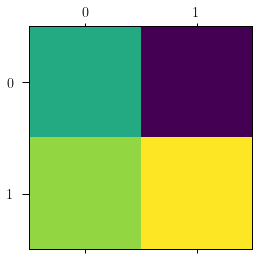

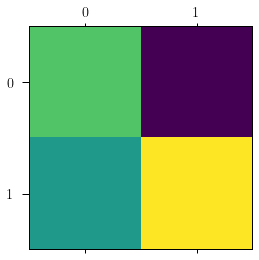

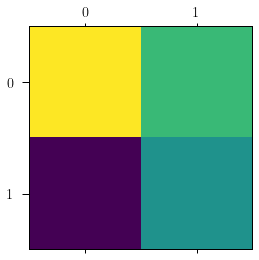

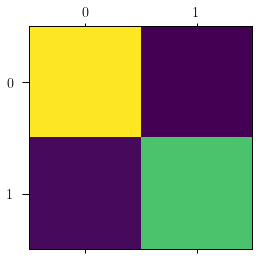

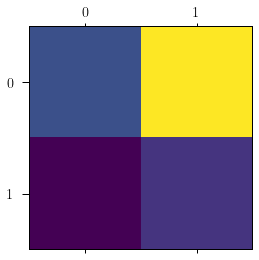

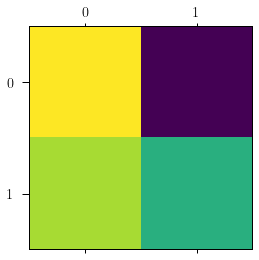

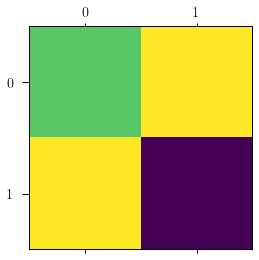

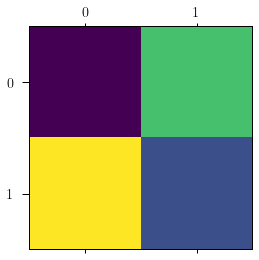

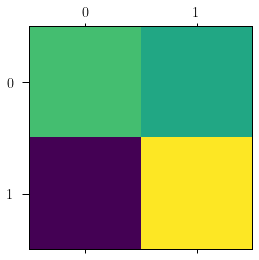

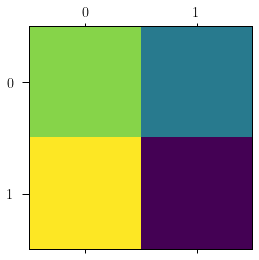

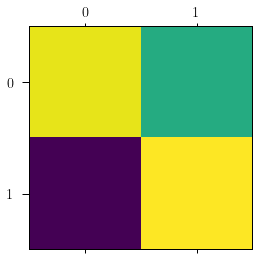

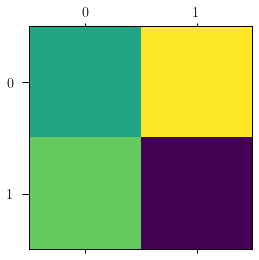

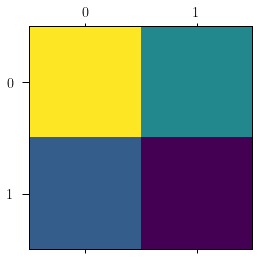

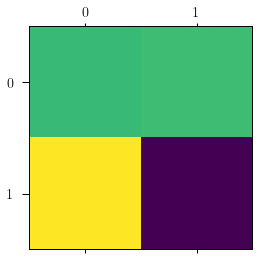

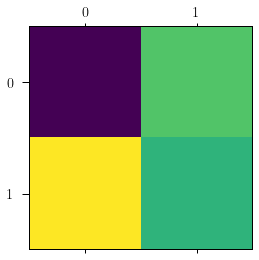

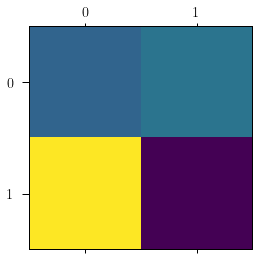

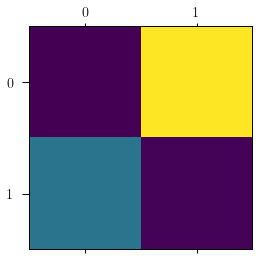

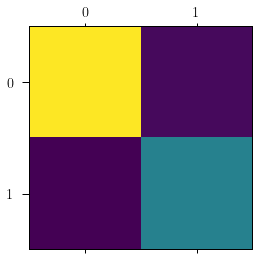

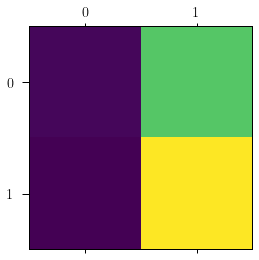

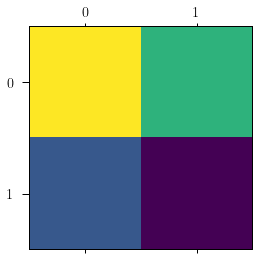

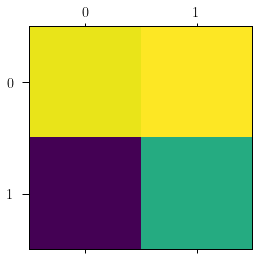

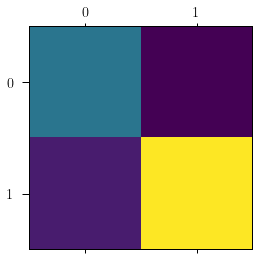

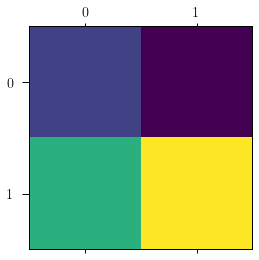

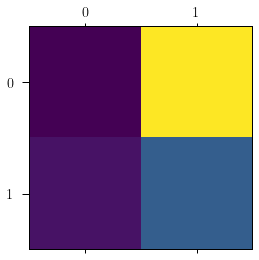

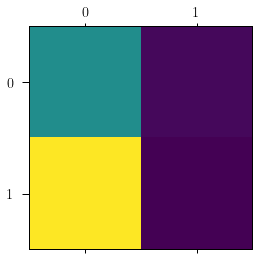

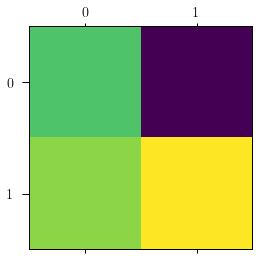

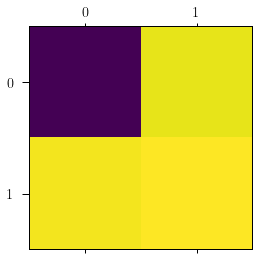

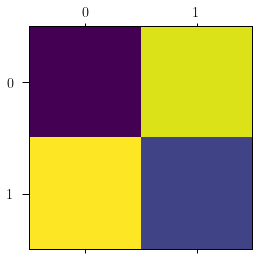

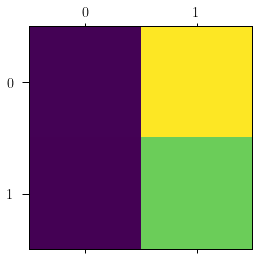

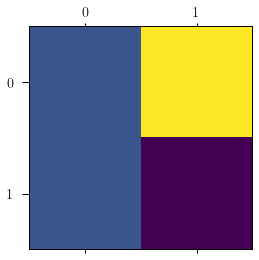

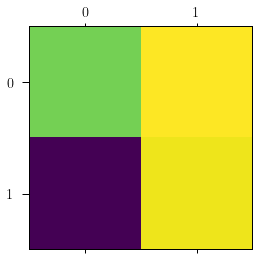

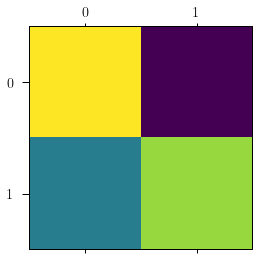

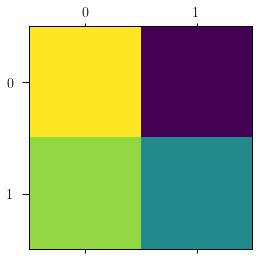

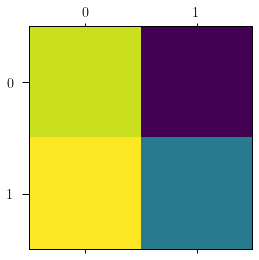

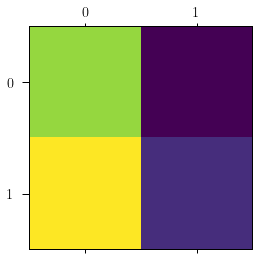

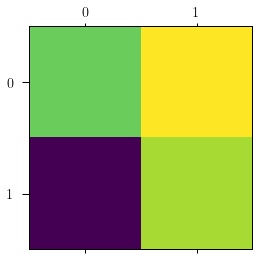

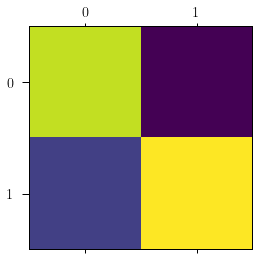

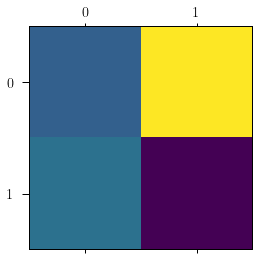

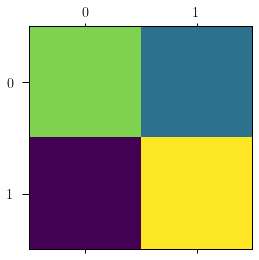

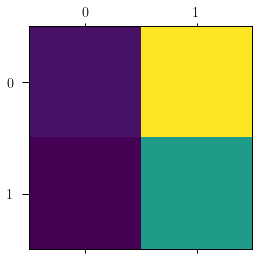

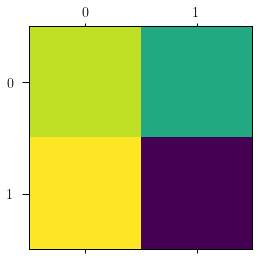

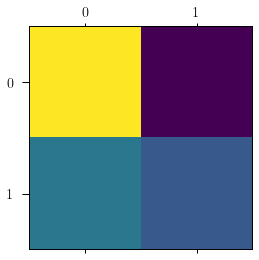

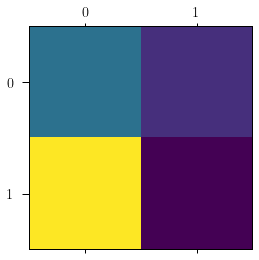

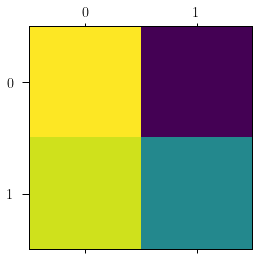

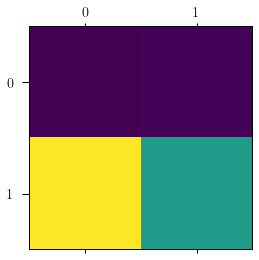

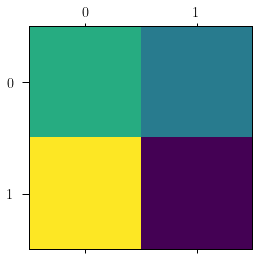

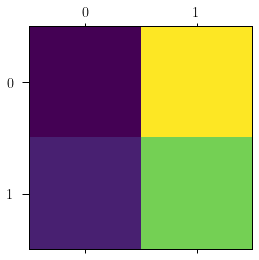

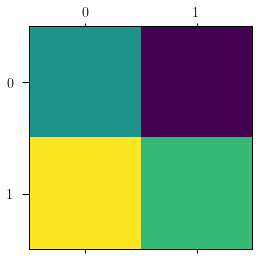

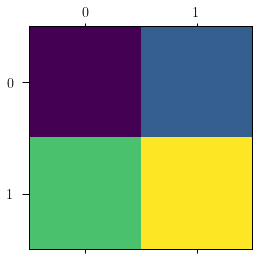

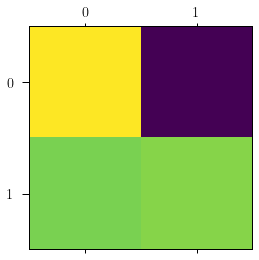

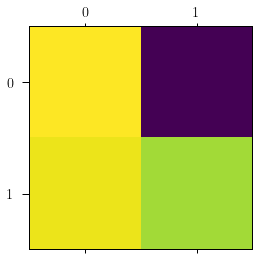

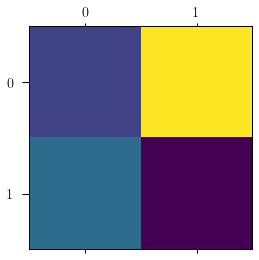

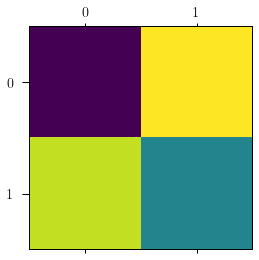

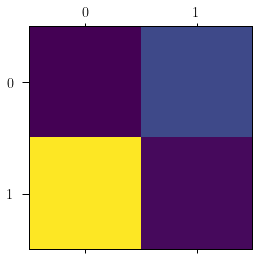

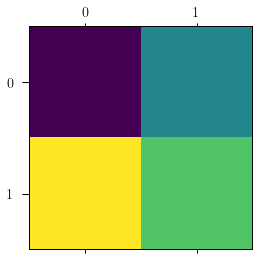

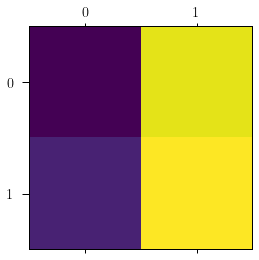

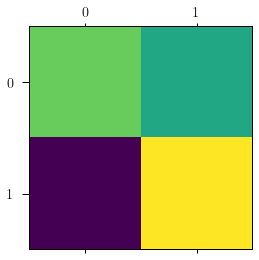

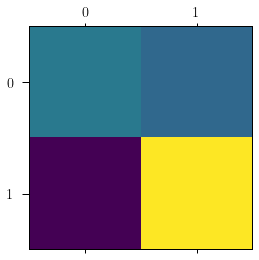

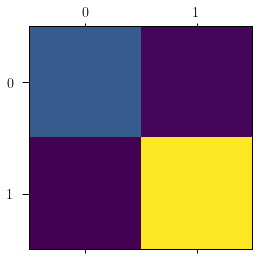

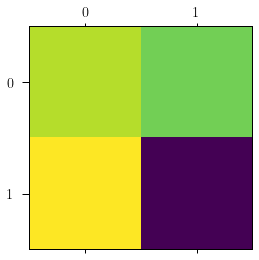

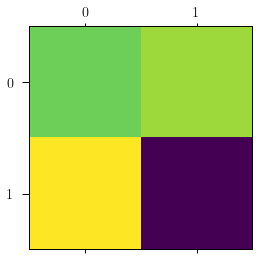

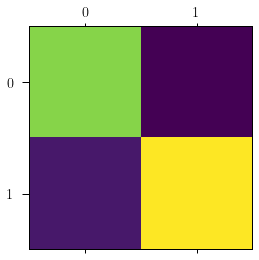

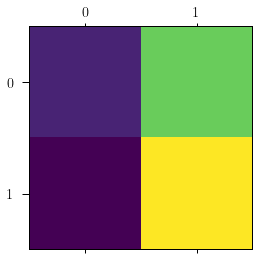

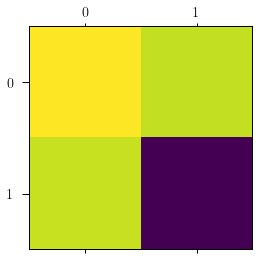

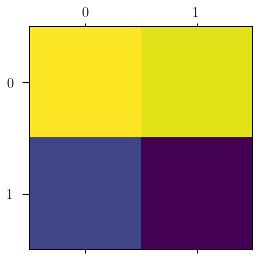

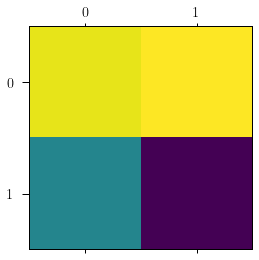

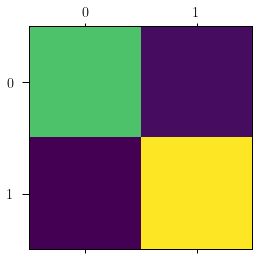

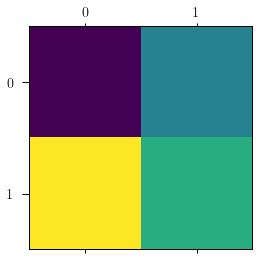

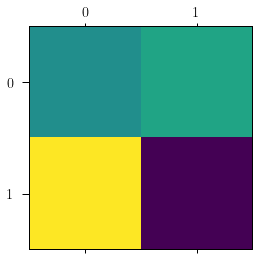

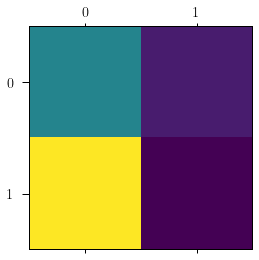

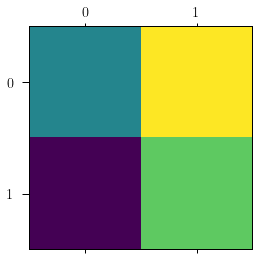

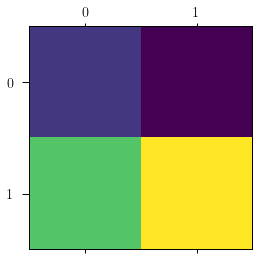

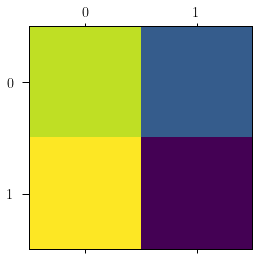

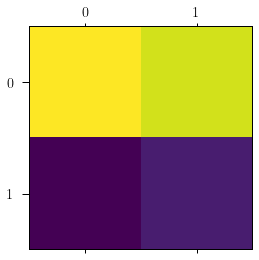

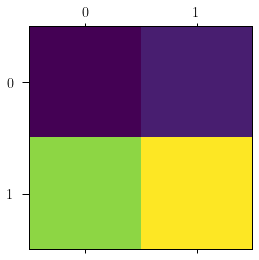

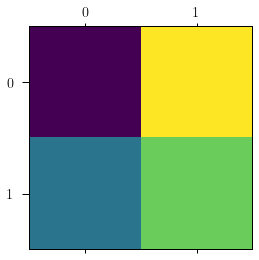

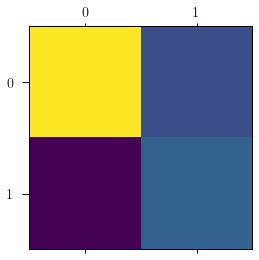

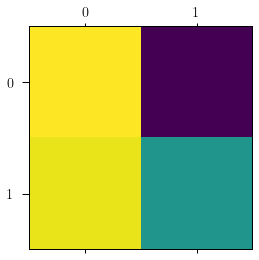

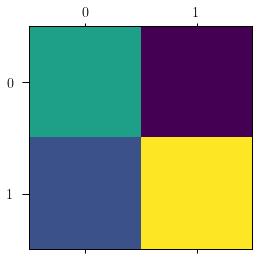

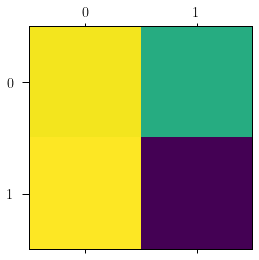

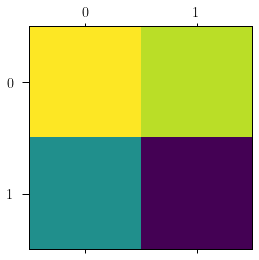

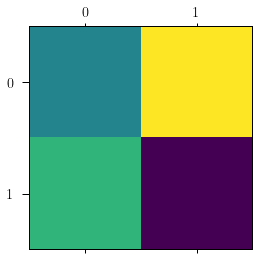

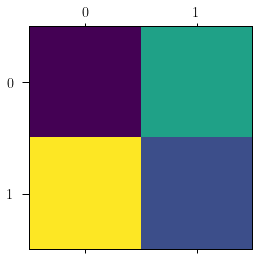

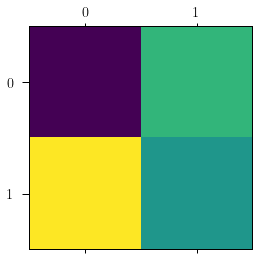

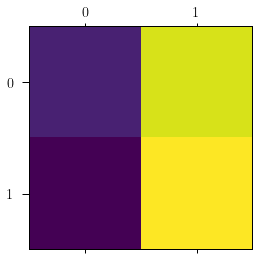

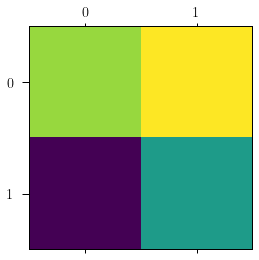

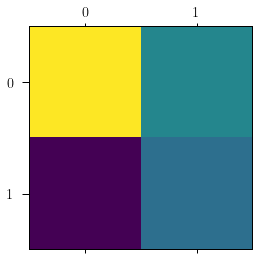

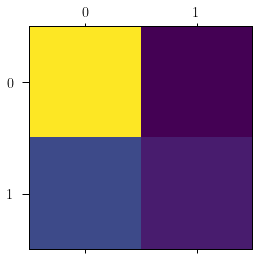

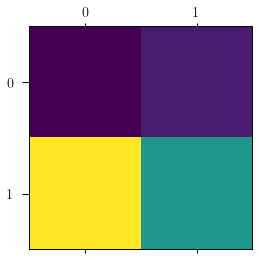

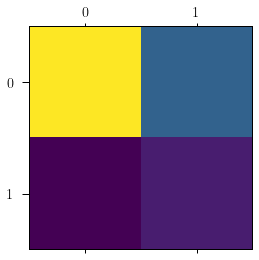

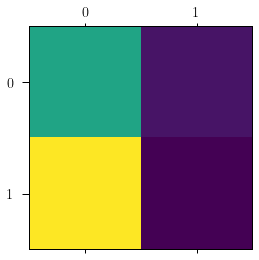

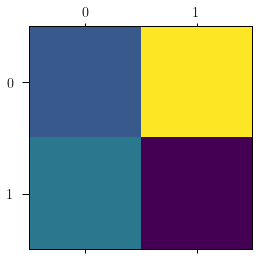

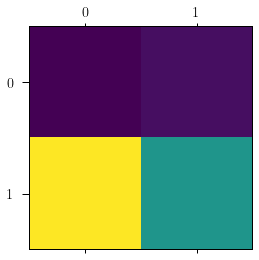

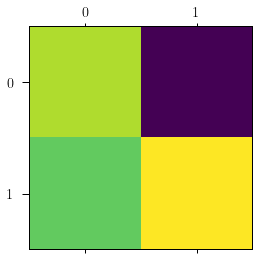

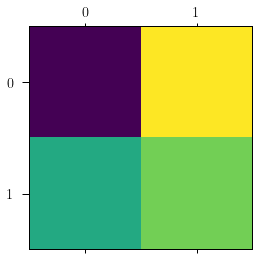

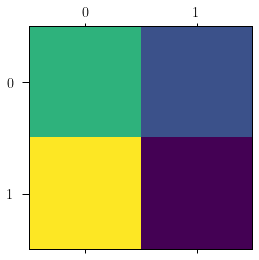

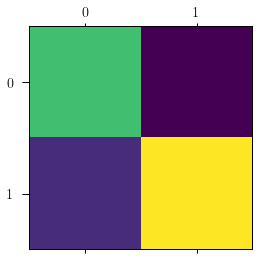

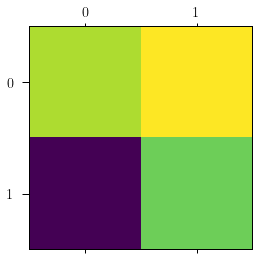

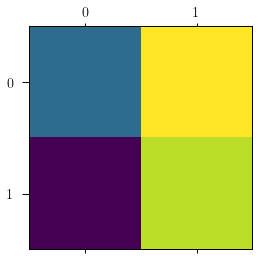

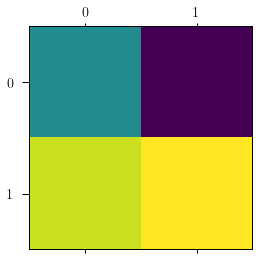

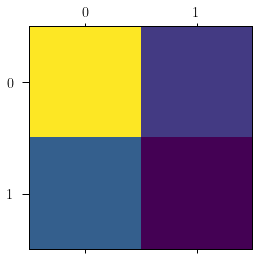

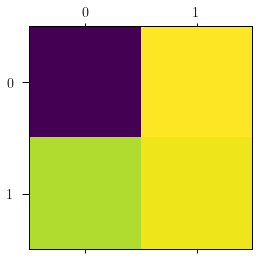

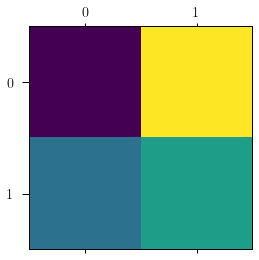

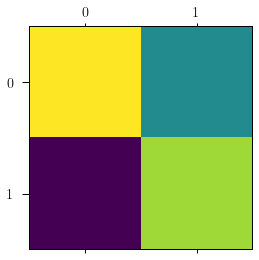

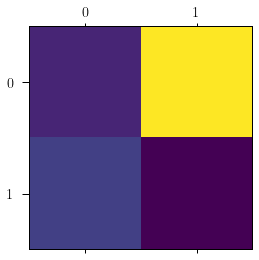

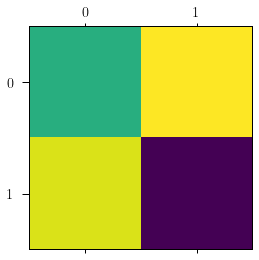

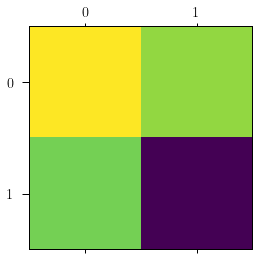

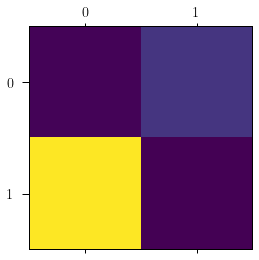

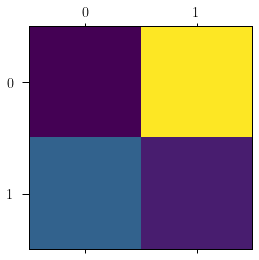

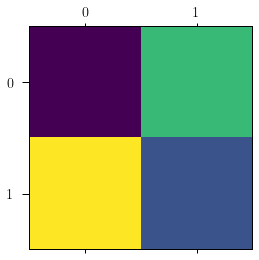

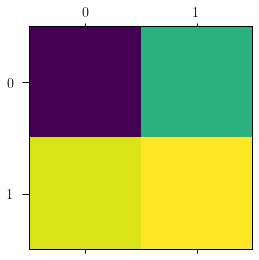

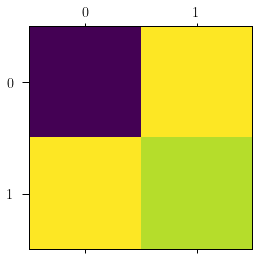

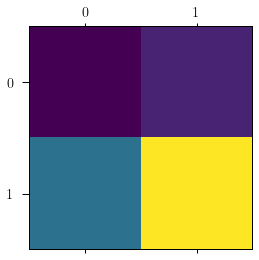

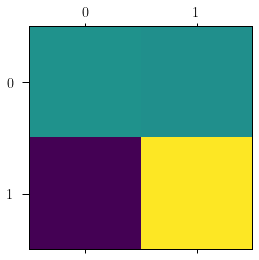

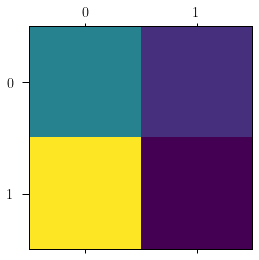

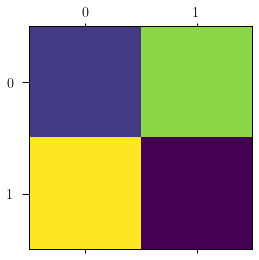

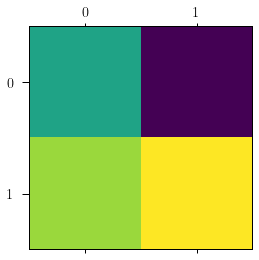

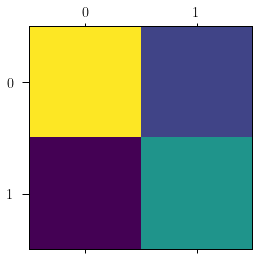

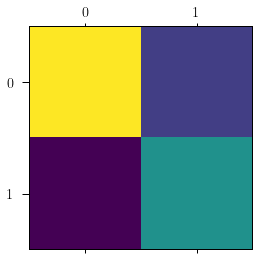

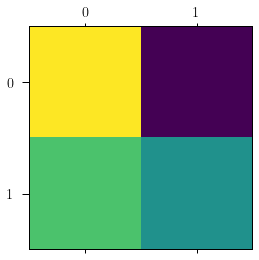

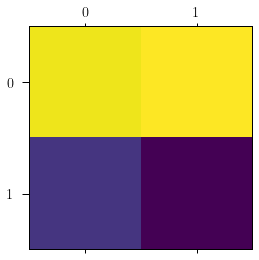

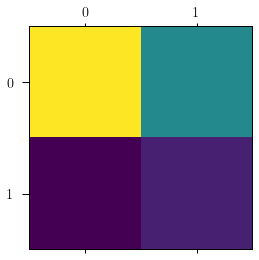

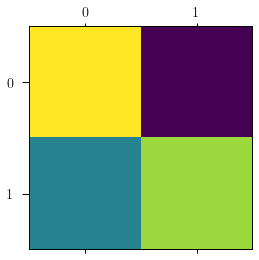

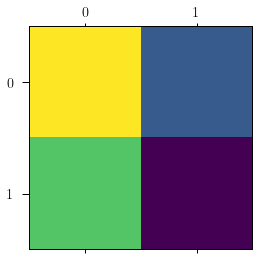

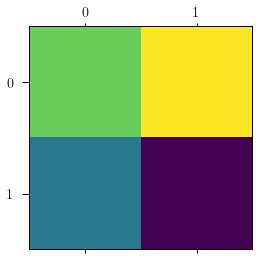

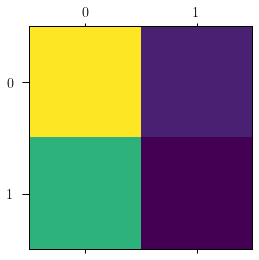

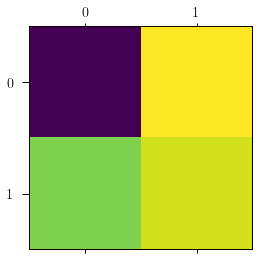

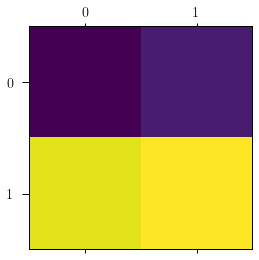

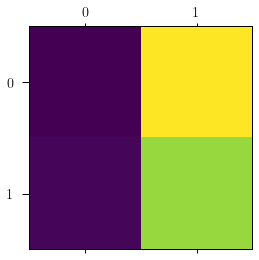

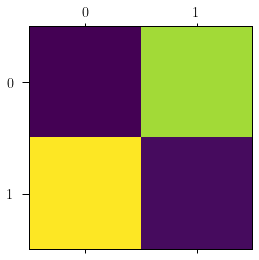

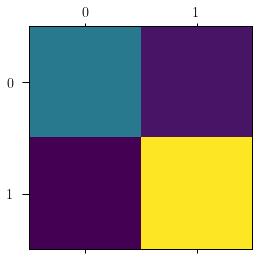

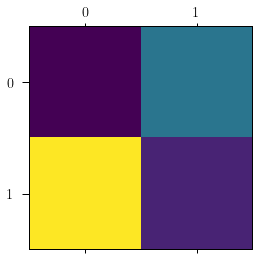

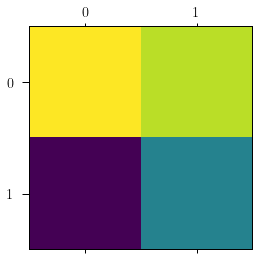

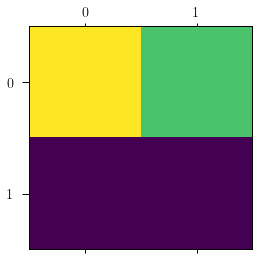

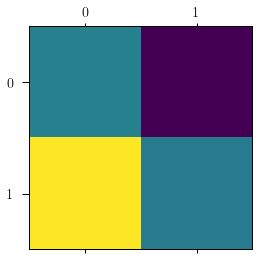

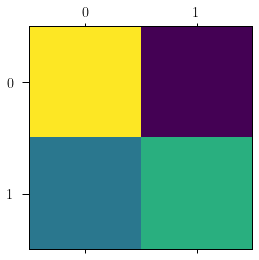

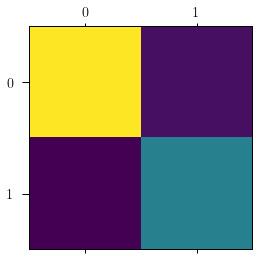

Error in callback <function flush_figures at 0x7f9e9157b4c0> (for post_execute):


KeyboardInterrupt: 

In [27]:
for i in range(9):
    if i == 1:
        weights, biases = model.layers[i].get_weights()
        channels_in = weights.shape[1]
        channels_out = weights.shape[2]
#         fig, axs = plt.subplots(channels_in, channels_out)
        for i in range(channels_in):
            for j in range(channels_out):
                print(tf.reshape(weights[:,i,j], [2,2]))
                plt.matshow(tf.reshape(weights[:,i,j], [2,2]).numpy())

In [31]:
data["x"][0].shape

(262144, 1)

In [46]:
feature_maps = [layer.output for layer in model.layers[0:]]
feature_map_model = keras.models.Model(inputs=model.input, outputs=feature_maps)

example_feature_maps = feature_map_model.predict(data["x"][:1])
print(example_feature_maps)

[array([[[0.        , 0.01059148, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.00723836, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.00075589],
        ...,
        [0.        , 0.002458  , 0.        , ..., 0.        ,
         0.0201355 , 0.        ],
        [0.        , 0.00183687, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.00651209, 0.        , 0.        , ..., 0.        ,
         0.01542598, 0.        ]]], dtype=float32), array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32), array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        

In [47]:
example_feature_maps[0].shape

(1, 65536, 64)

# Plotting!

In [23]:
def plot_partial_sky_map(partial_map, order=order, nside=nside, ncols=8, title="Dummy Title"):
    viridis = mpl.cm.get_cmap('viridis', ncols)
    new_map = np.zeros(hp.nside2npix(nside))
    new_map[:(nside//order)**2] = np.copy(partial_map)
    new_map[(nside//order)**2:] = np.inf
    hp.mollview(new_map, title=title, nest=True, cmap=viridis, max=np.max(new_map[:(nside//order)**2]))

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(


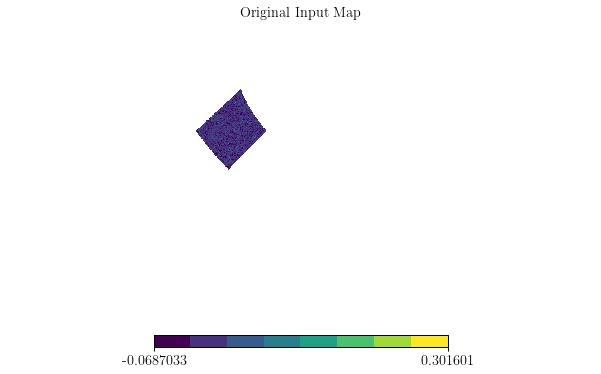

In [138]:
plot_partial_sky_map(data["x"][300][:,0], title="Original Input Map")

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/visufunc.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume 

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = se

KeyboardInterrupt: 

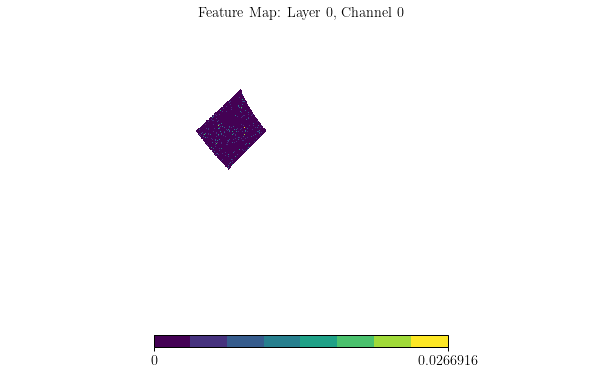

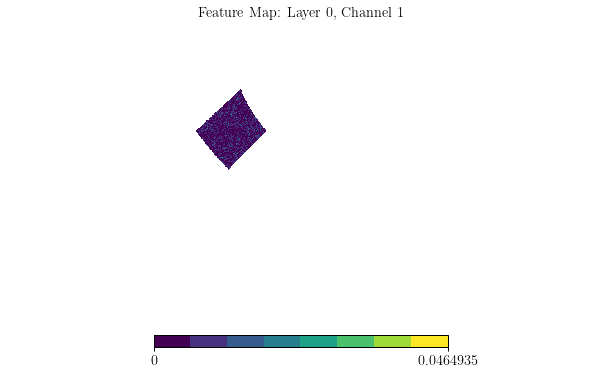

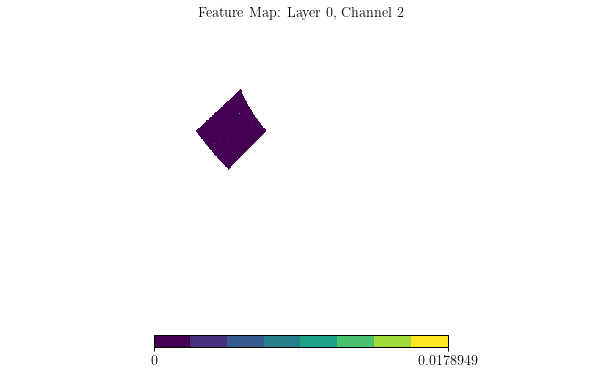

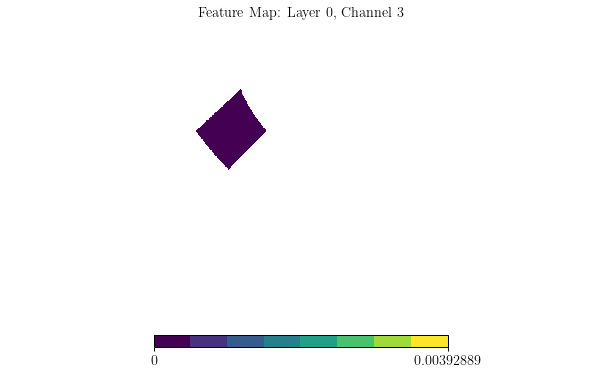

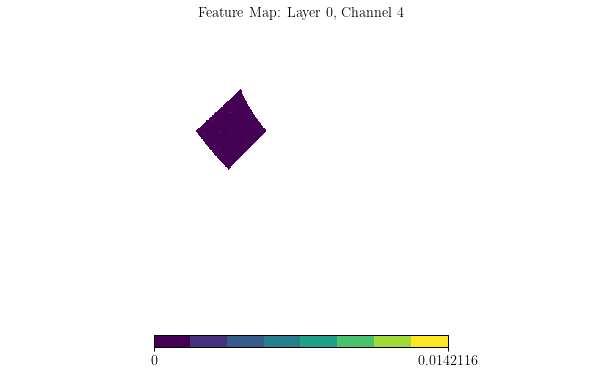

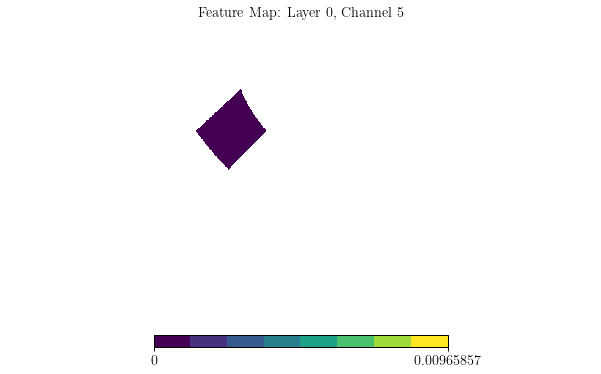

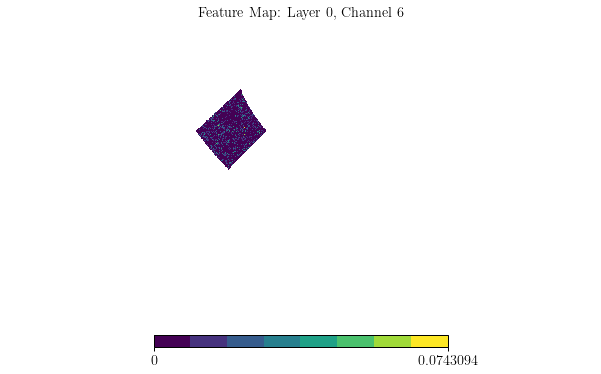

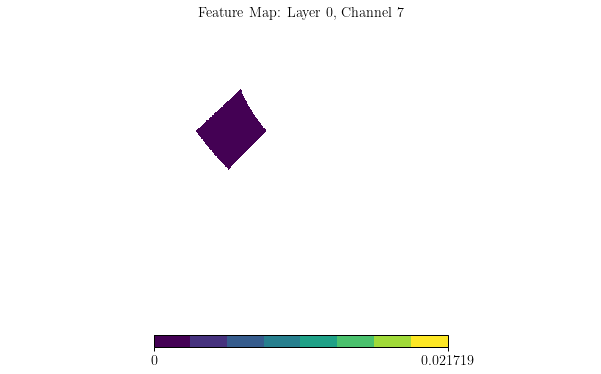

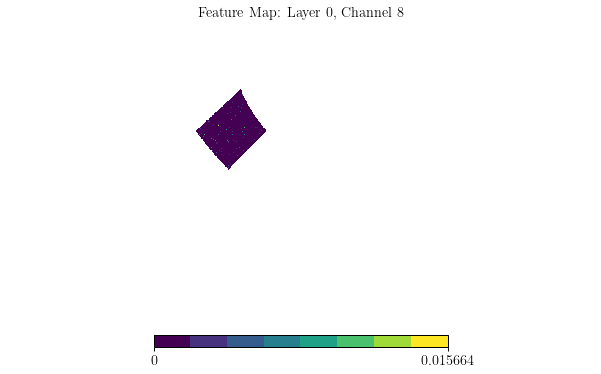

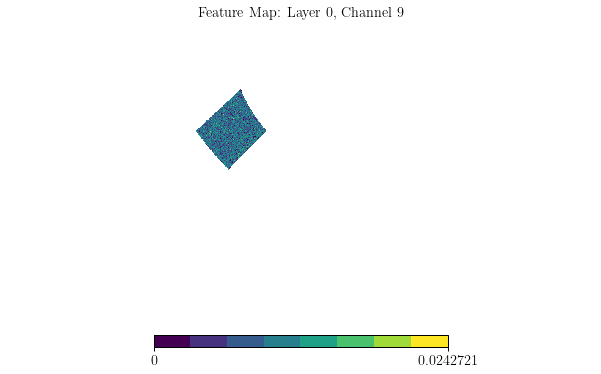

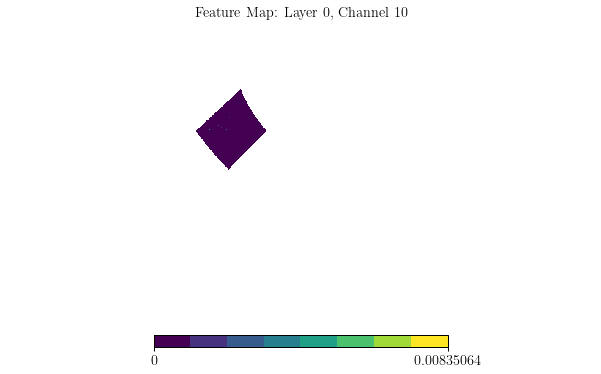

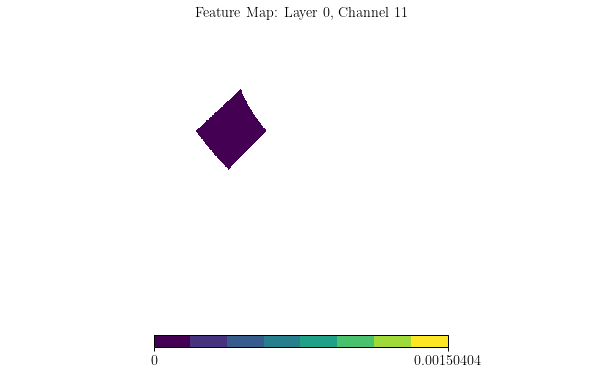

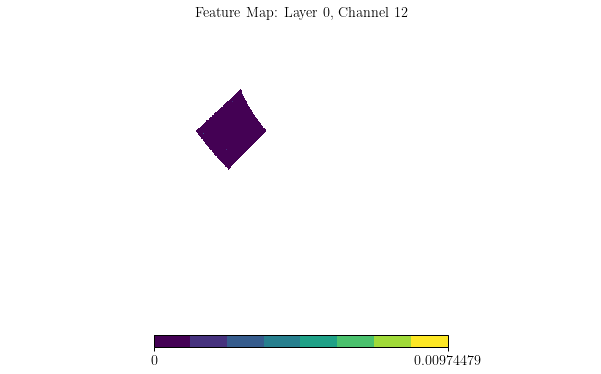

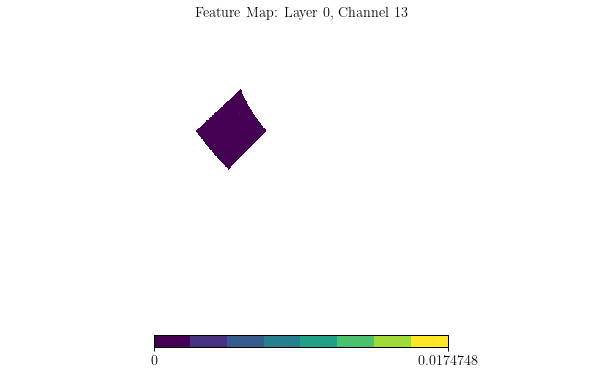

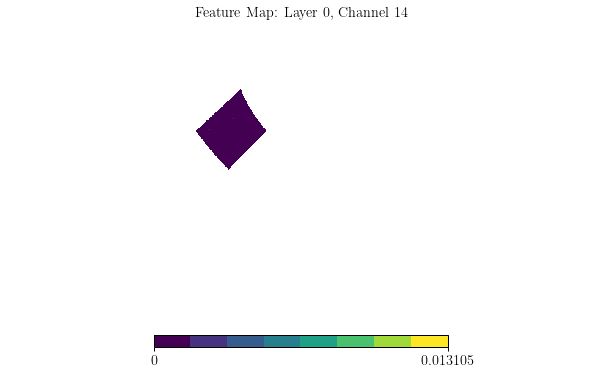

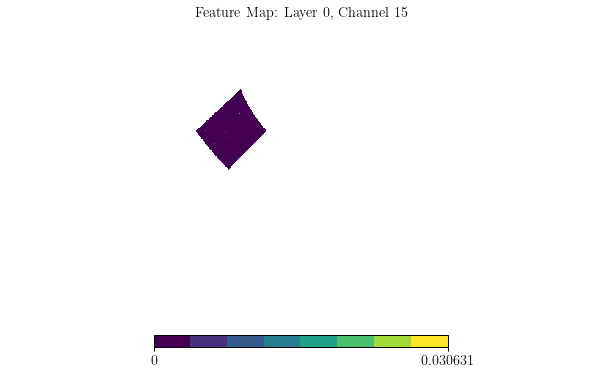

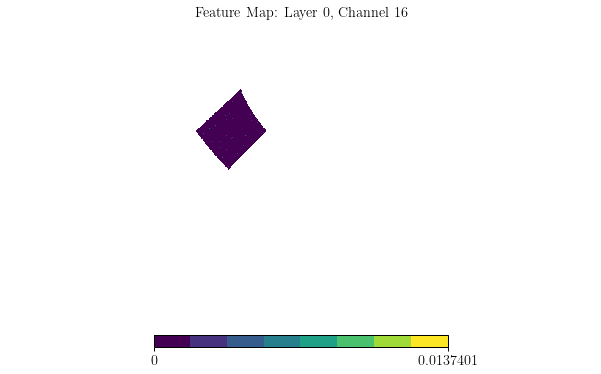

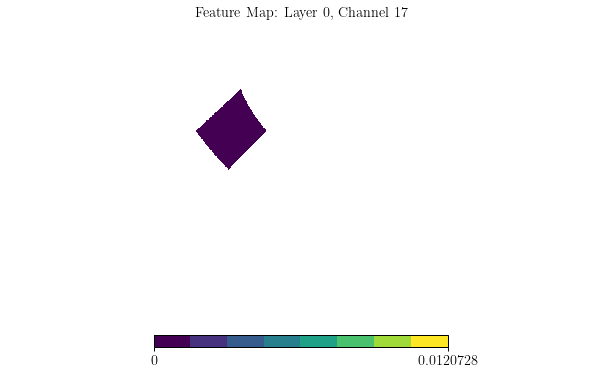

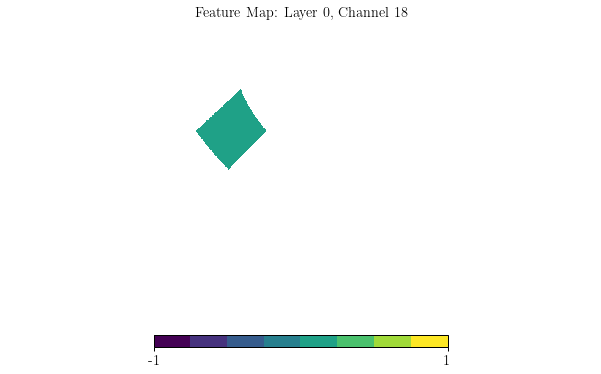

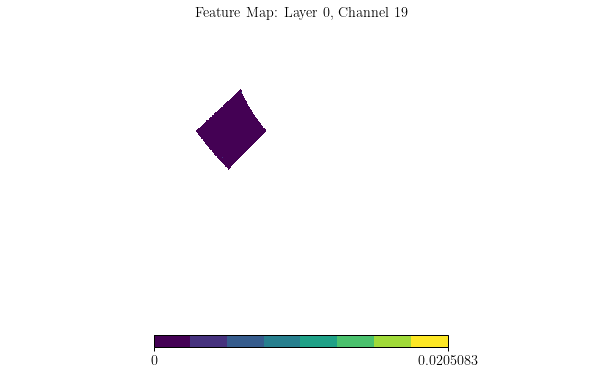

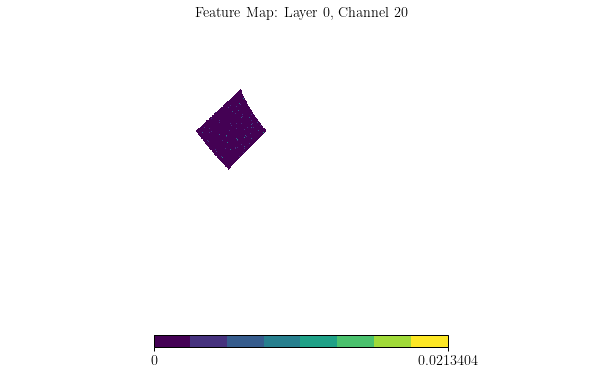

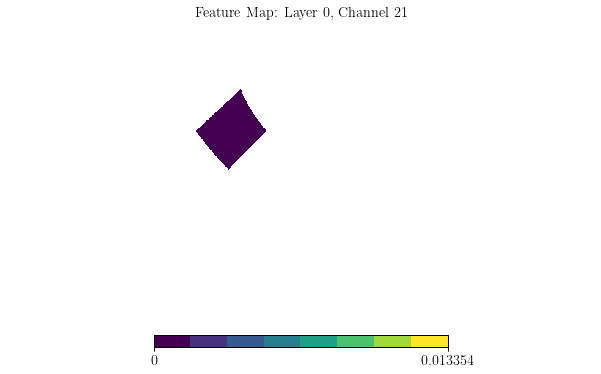

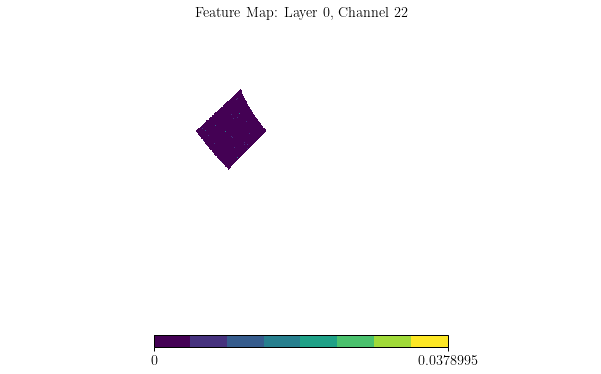

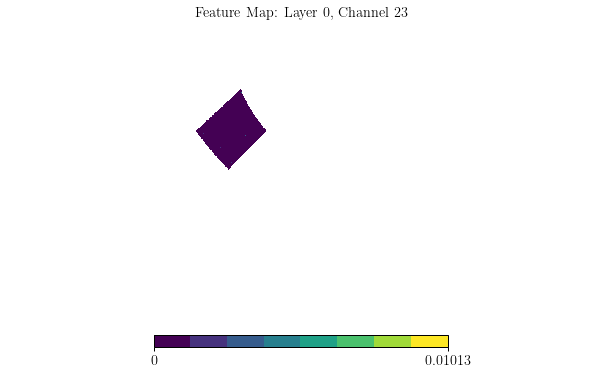

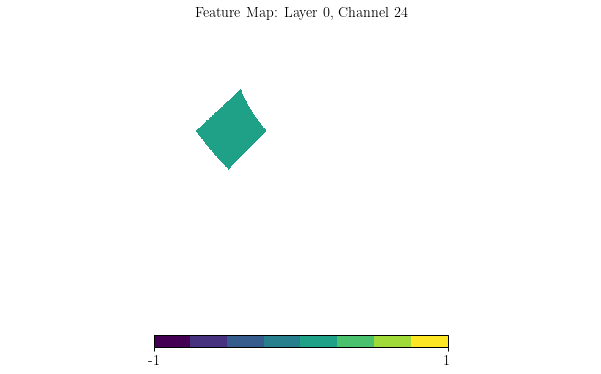

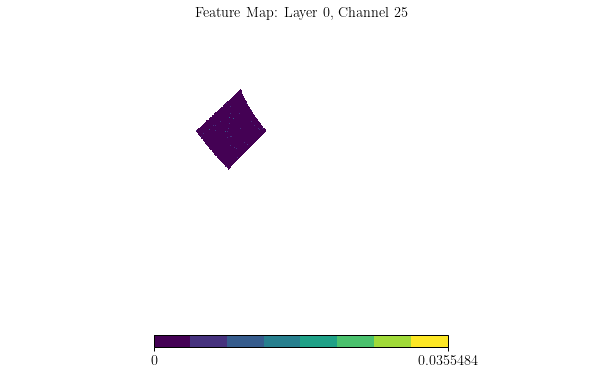

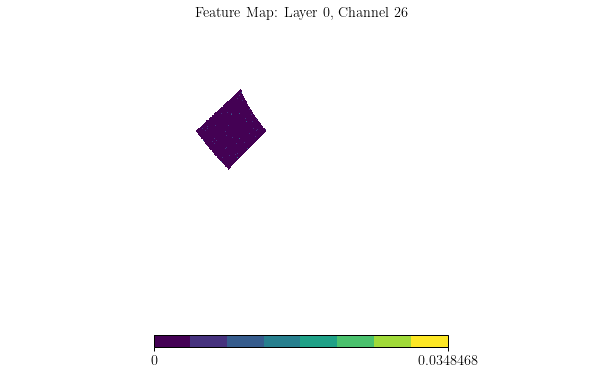

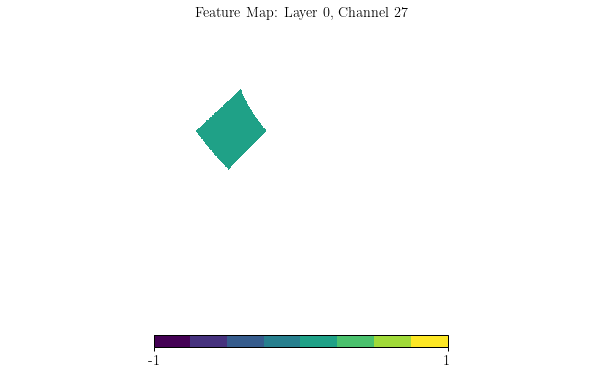

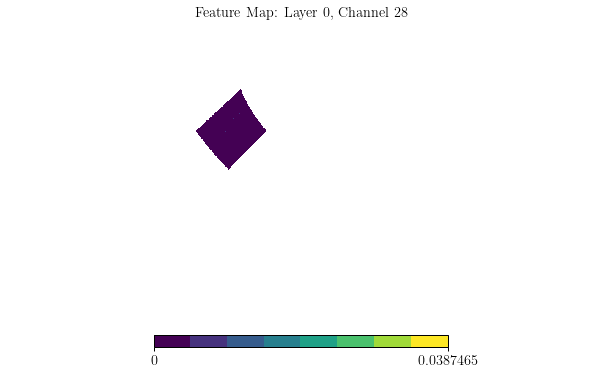

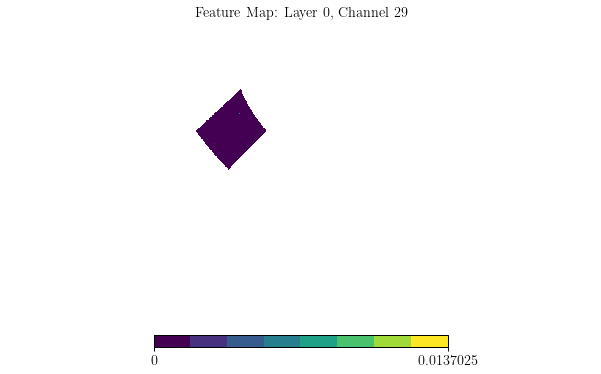

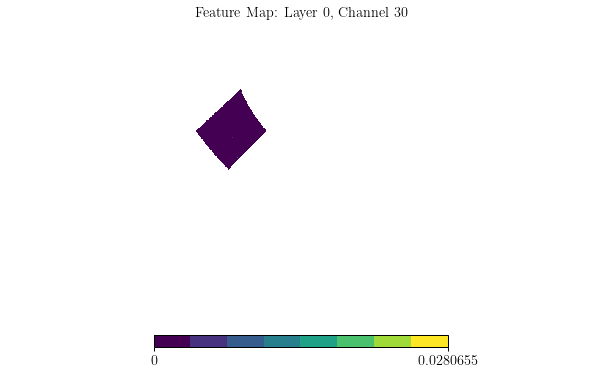

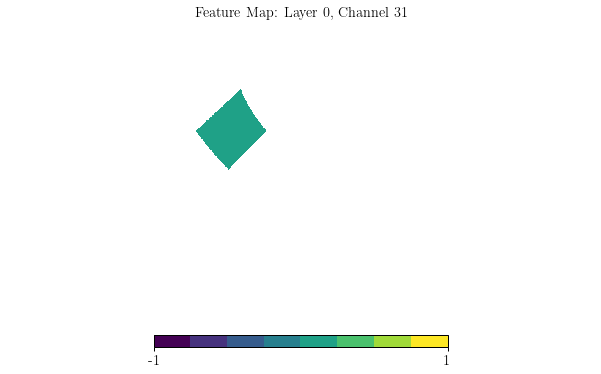

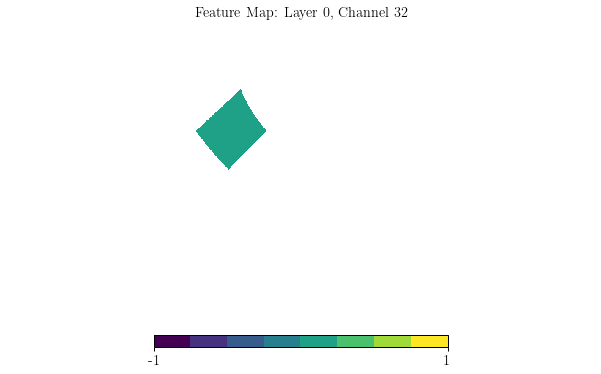

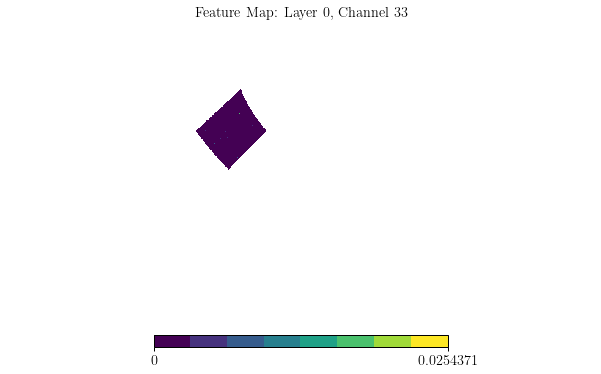

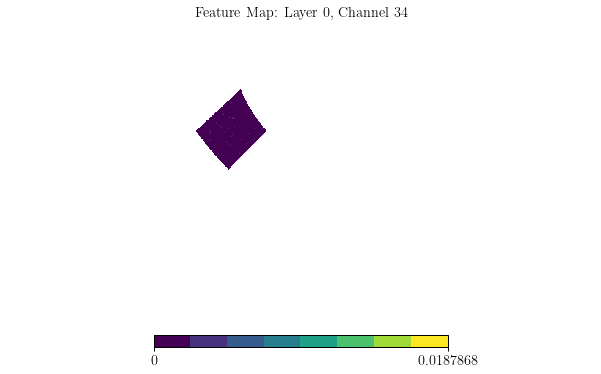

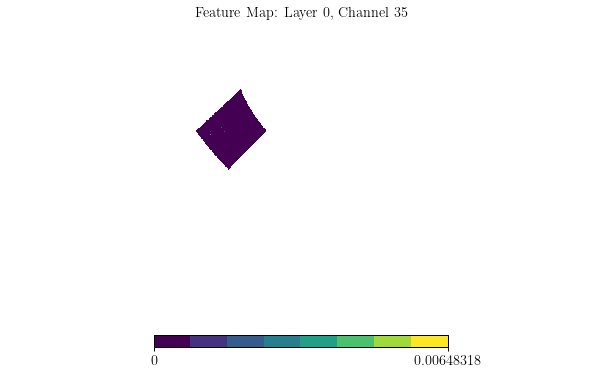

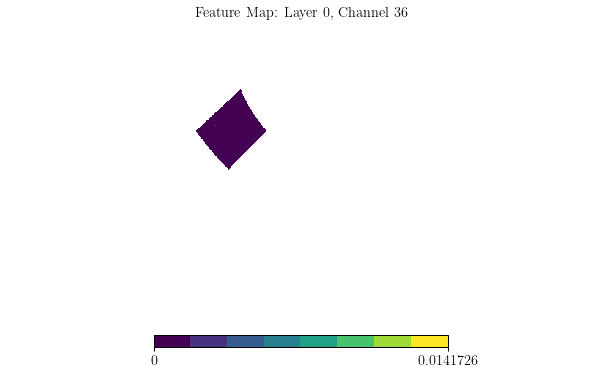

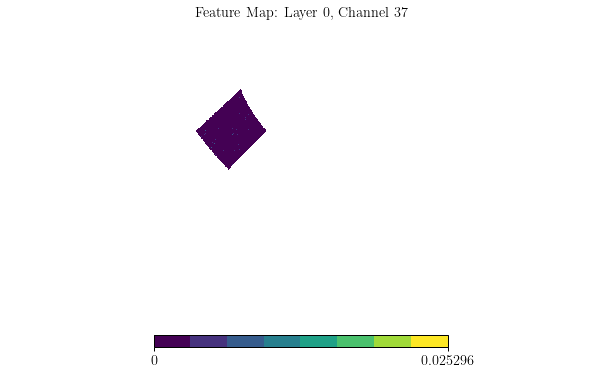

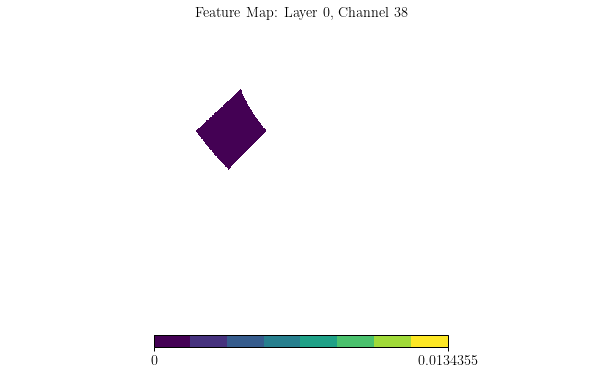

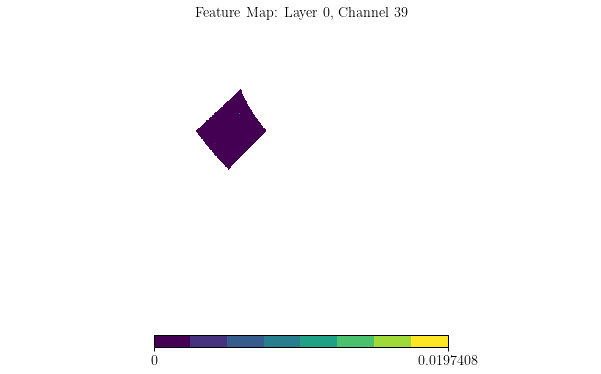

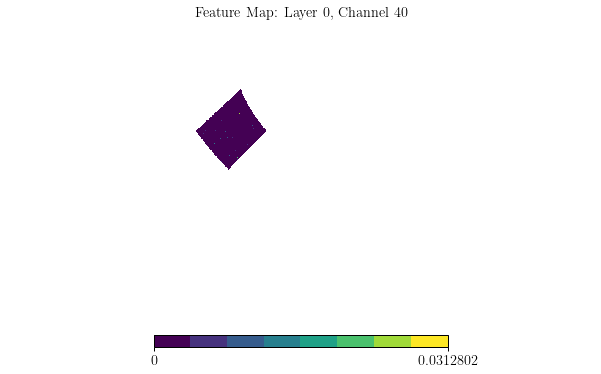

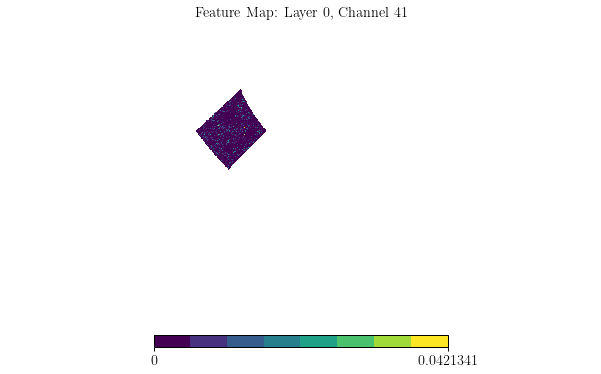

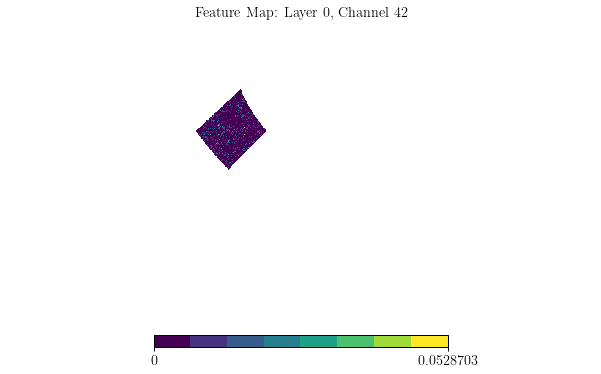

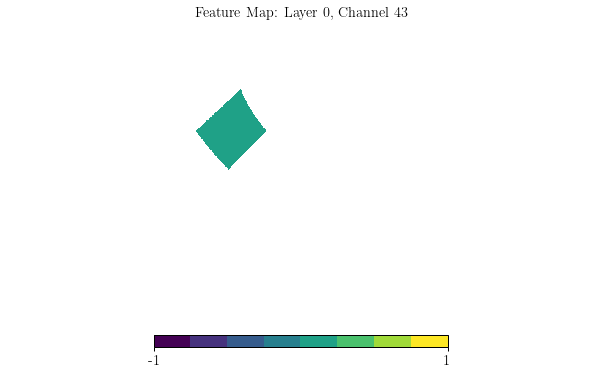

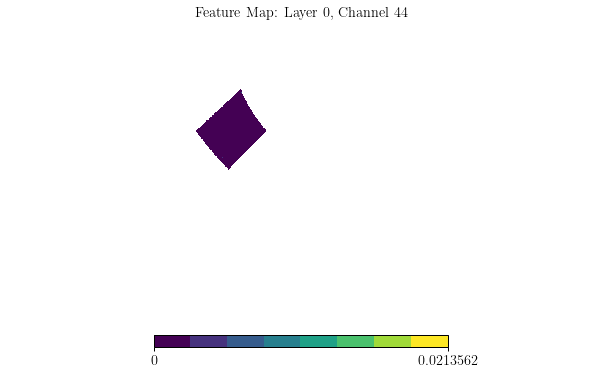

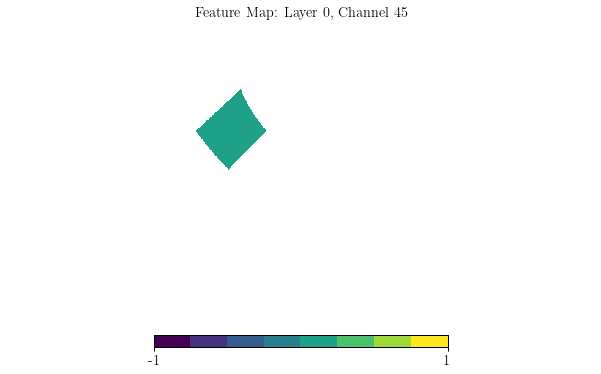

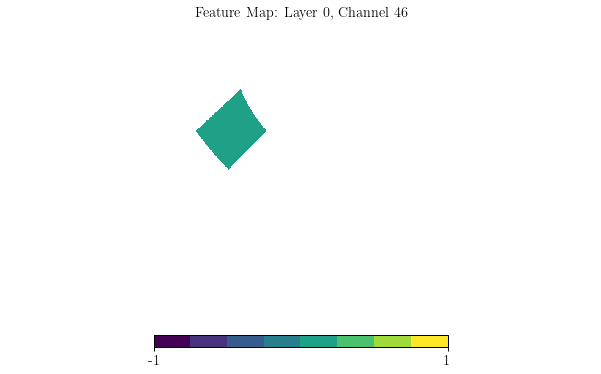

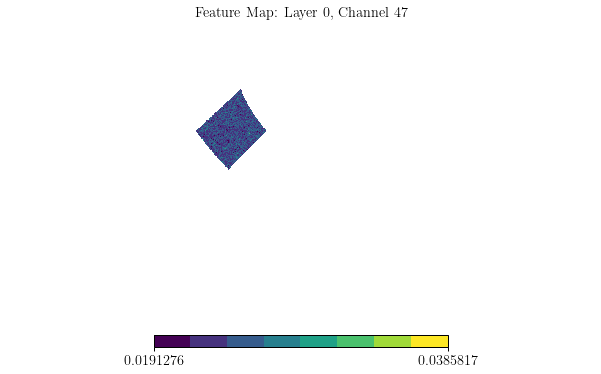

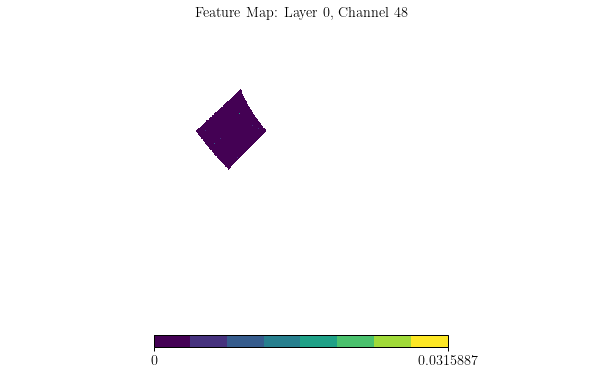

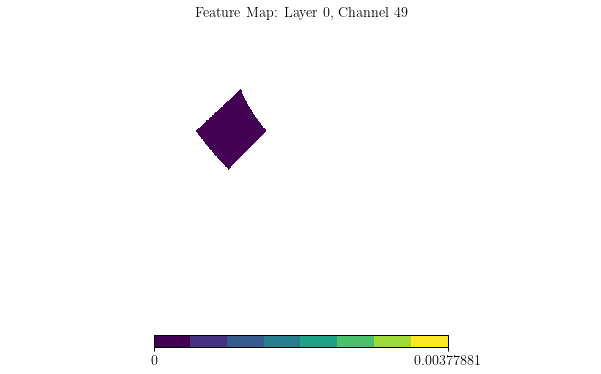

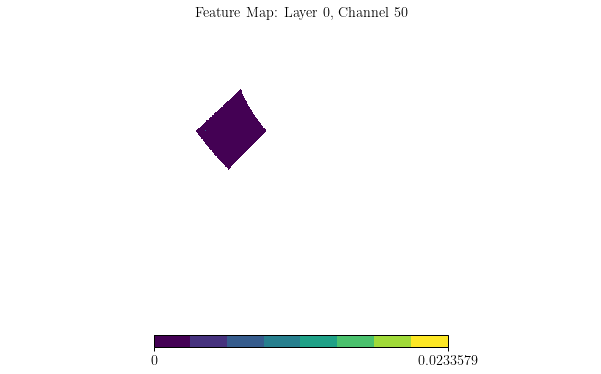

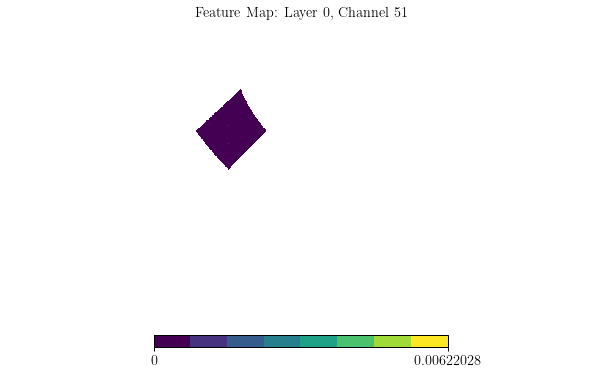

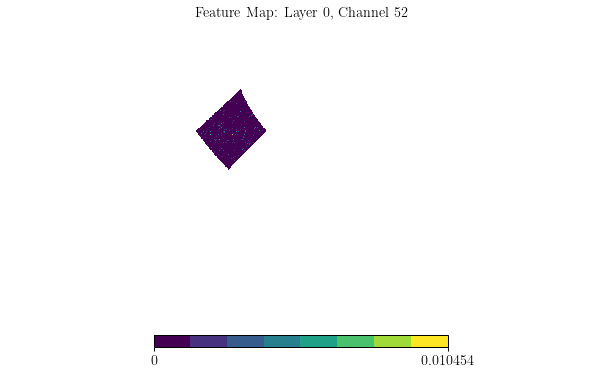

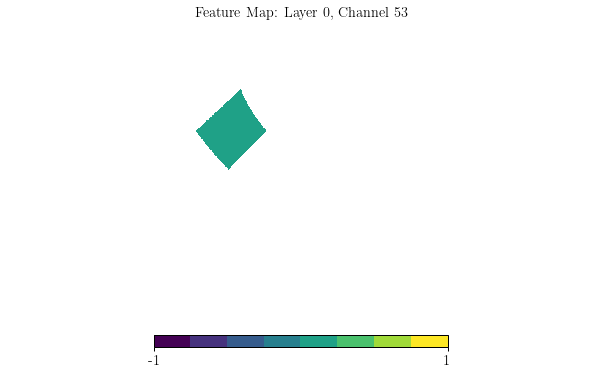

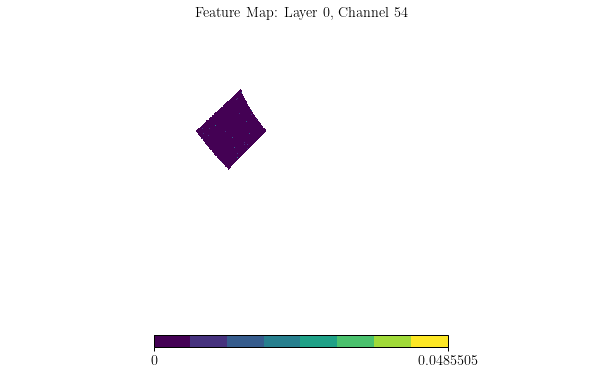

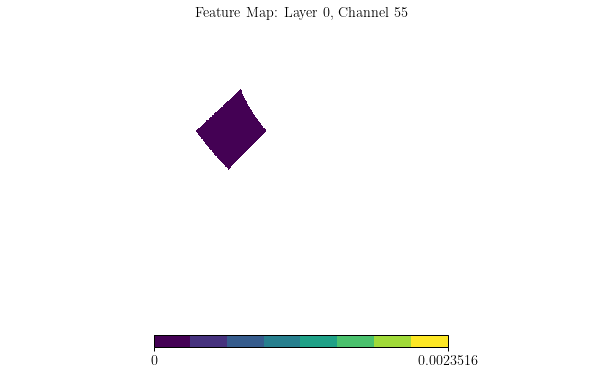

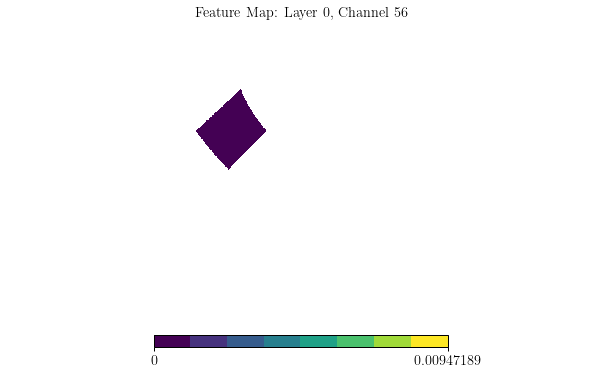

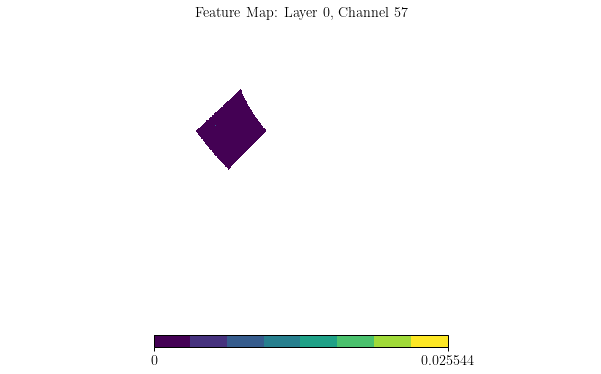

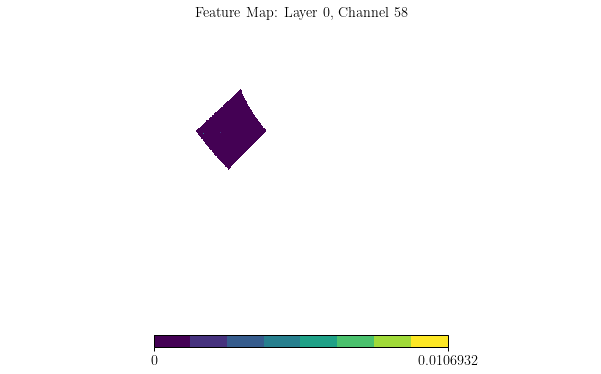

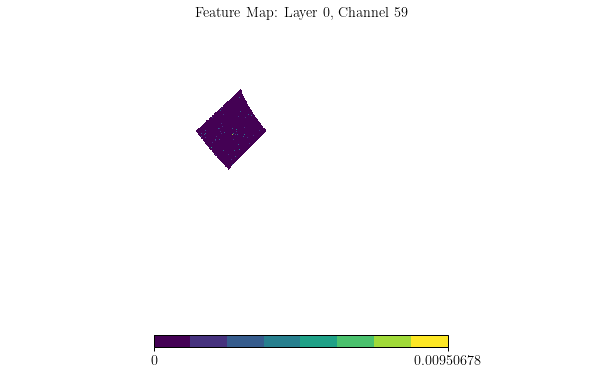

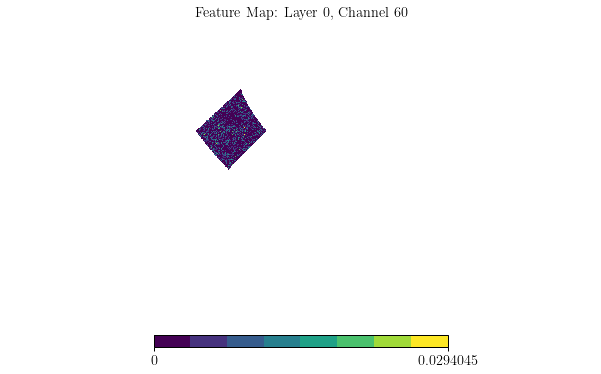

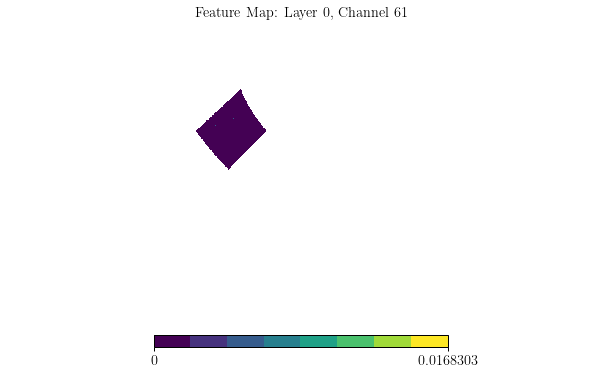

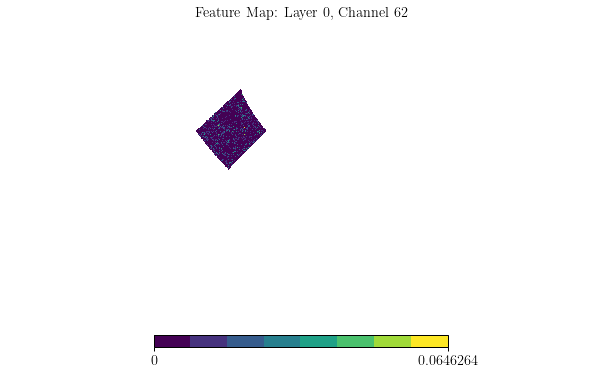

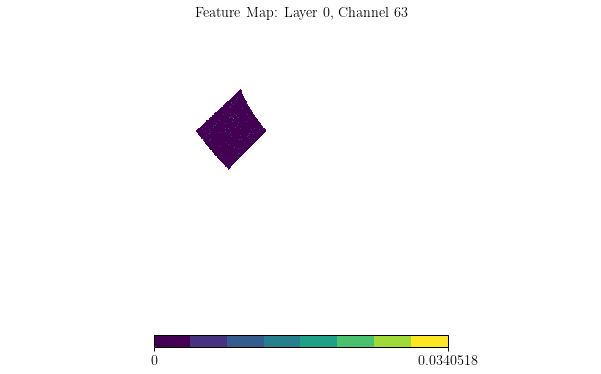

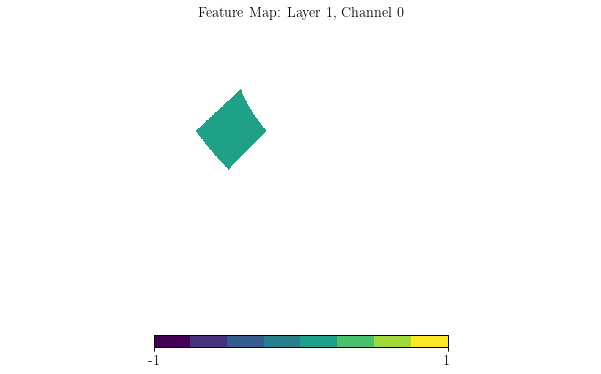

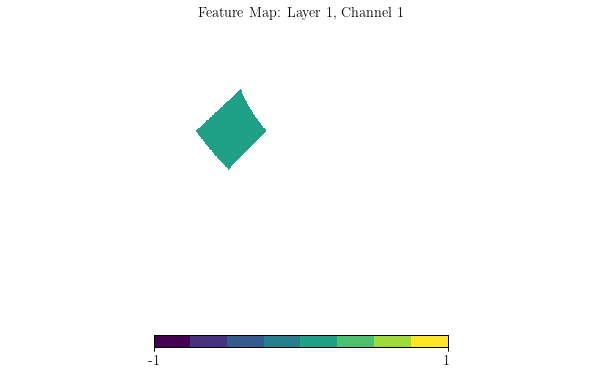

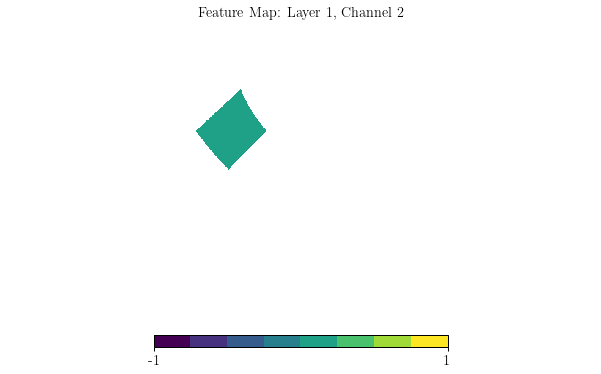

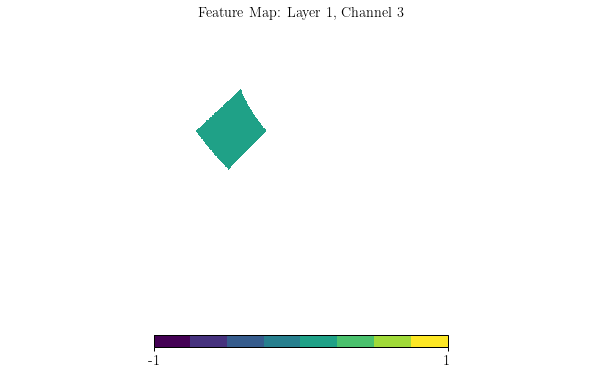

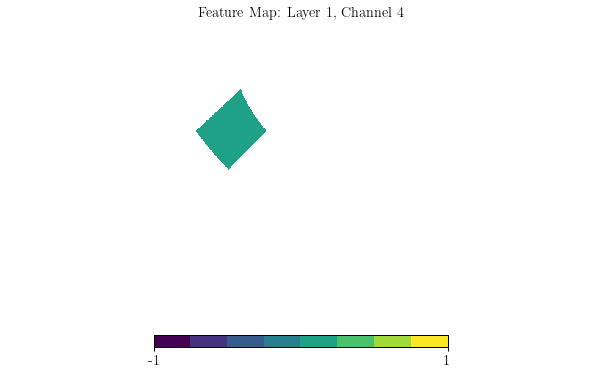

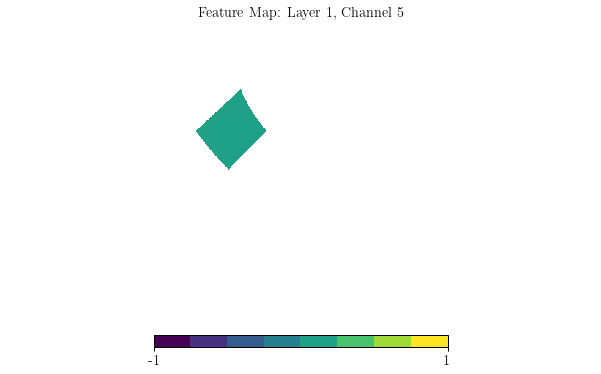

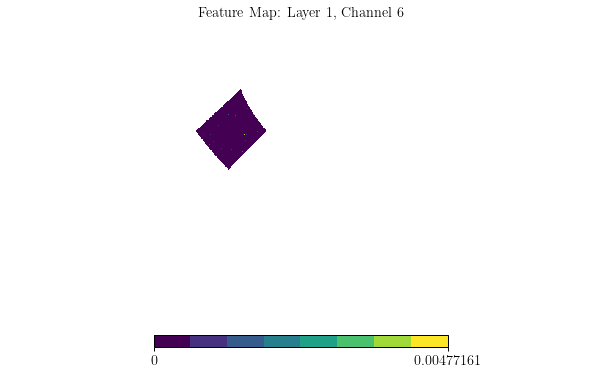

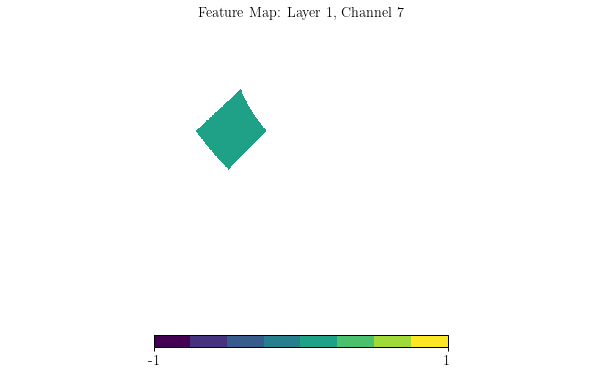

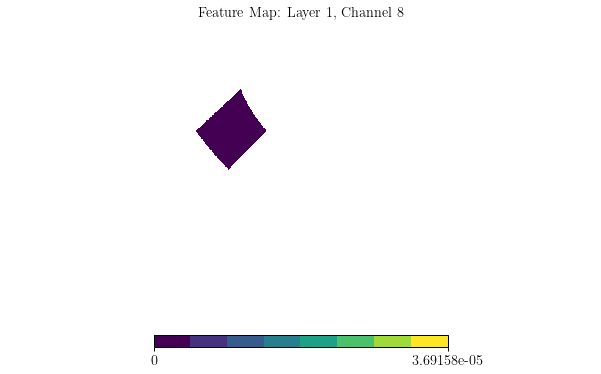

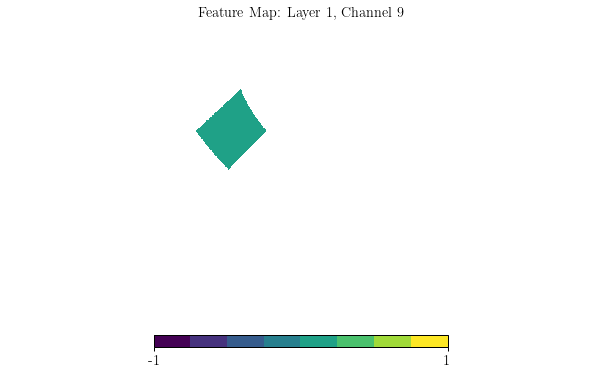

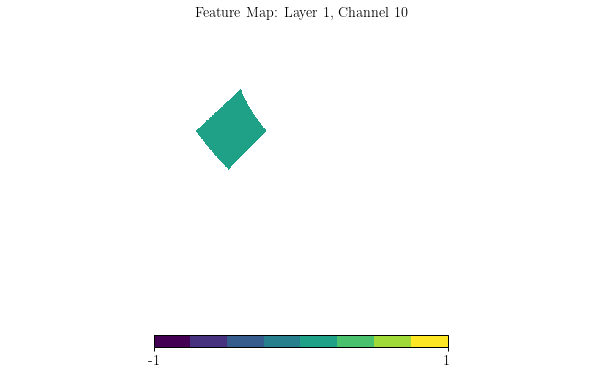

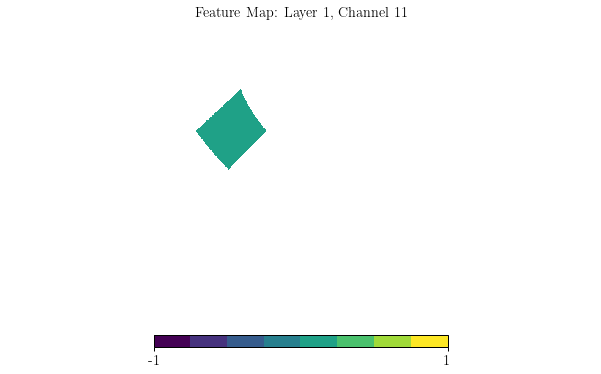

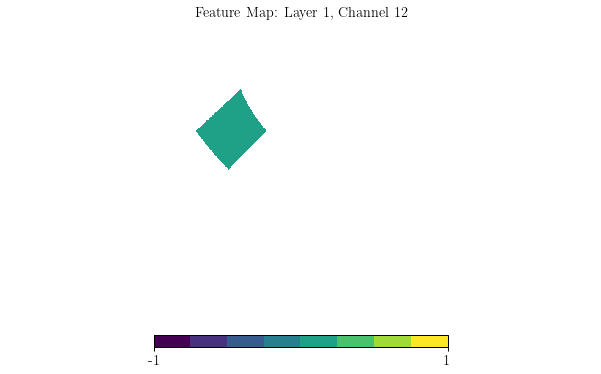

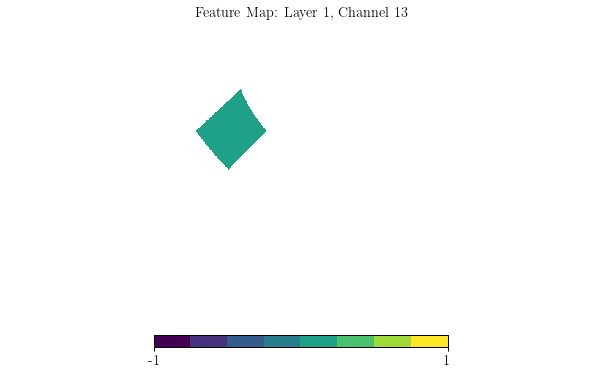

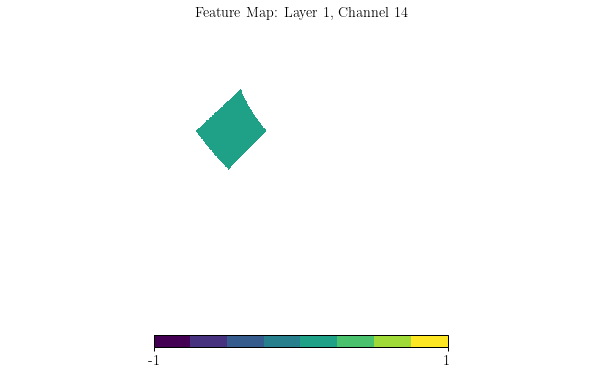

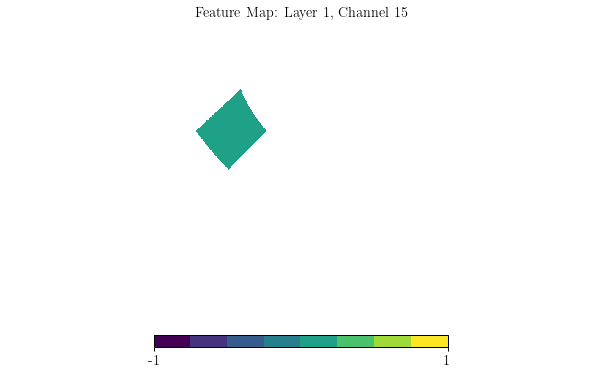

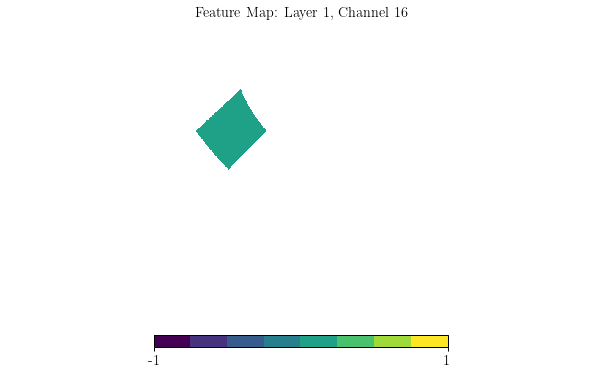

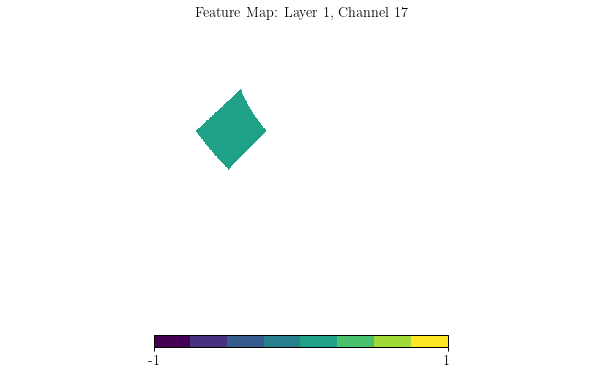

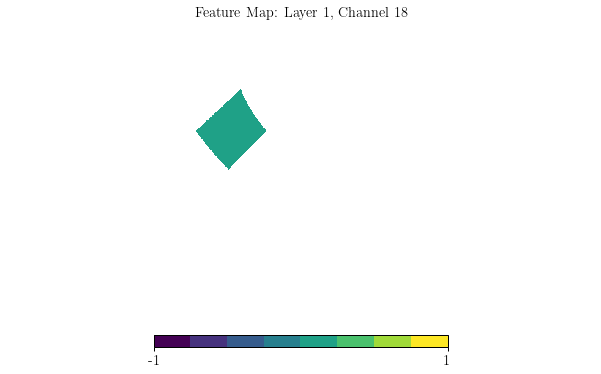

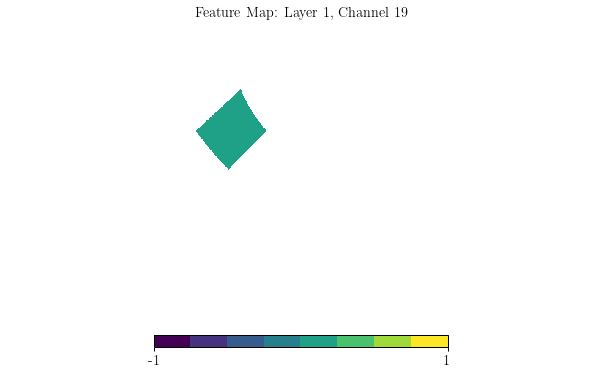

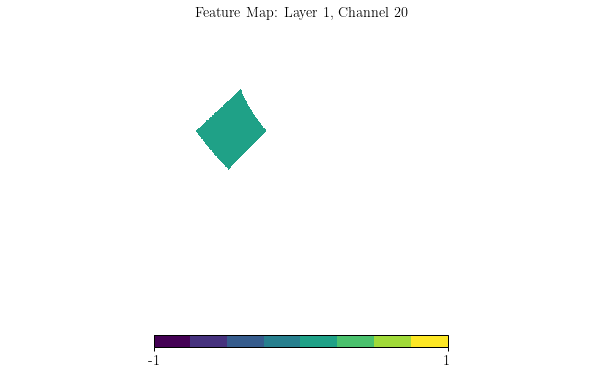

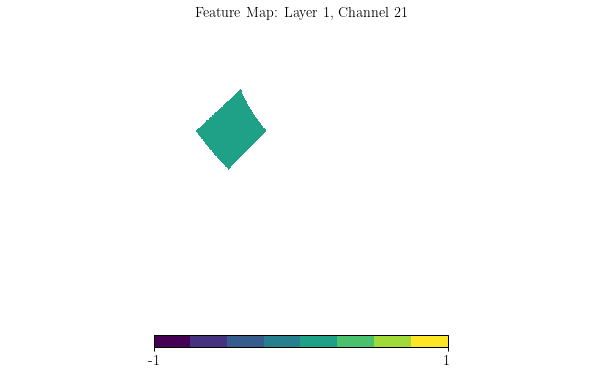

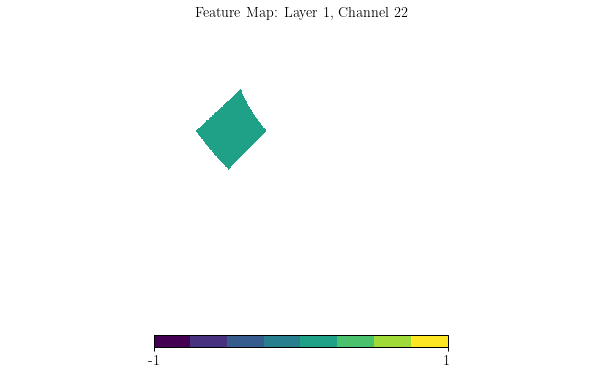

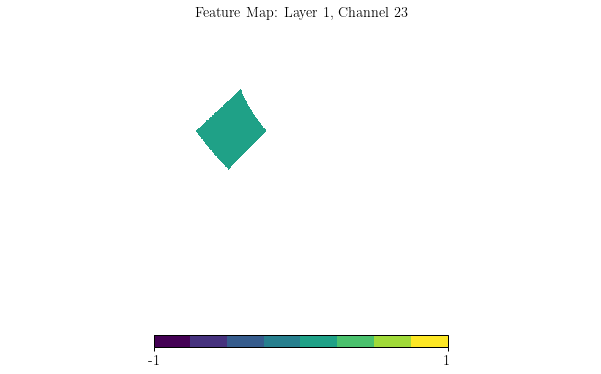

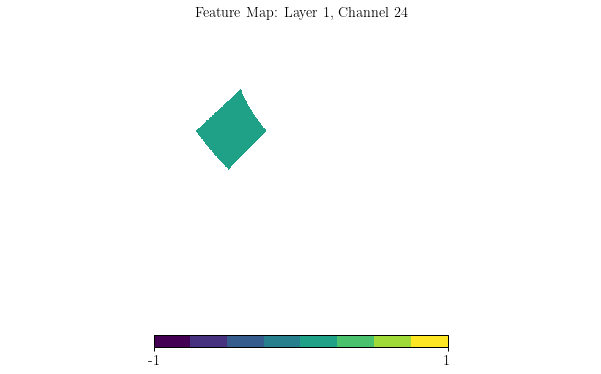

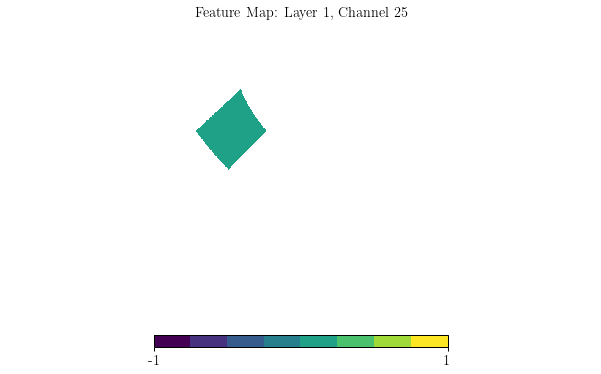

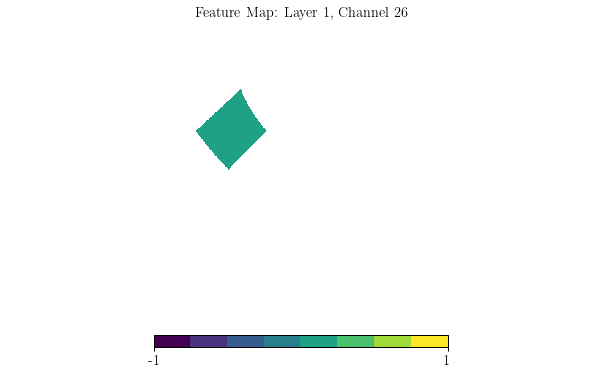

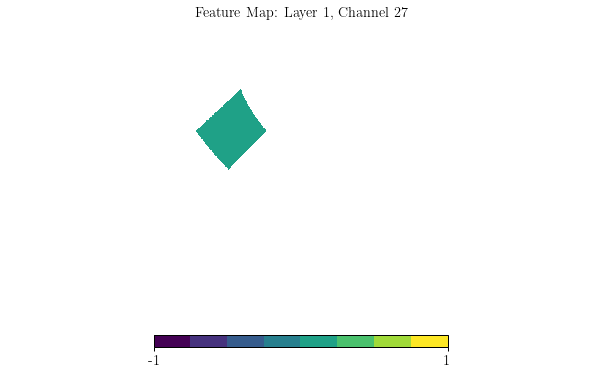

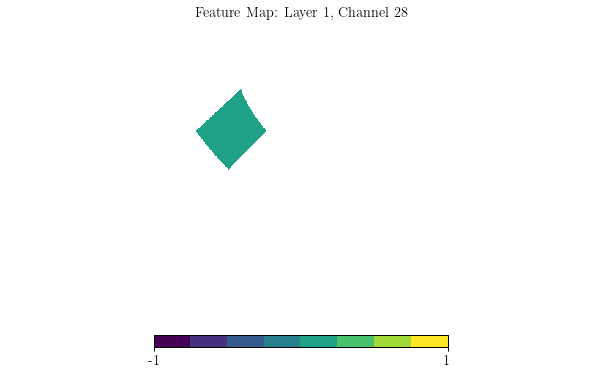

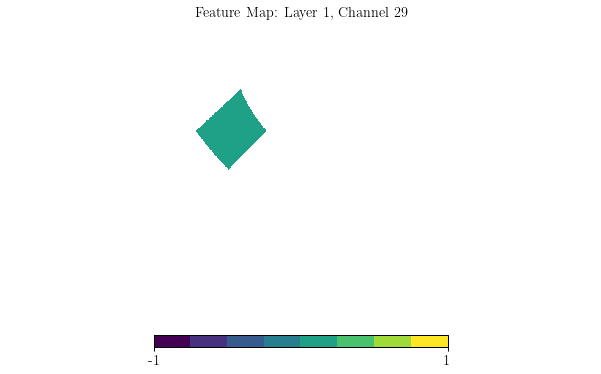

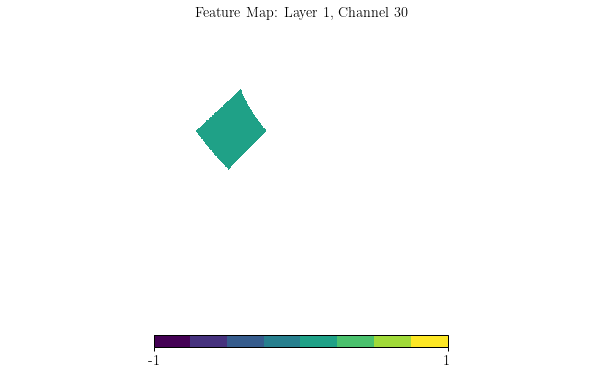

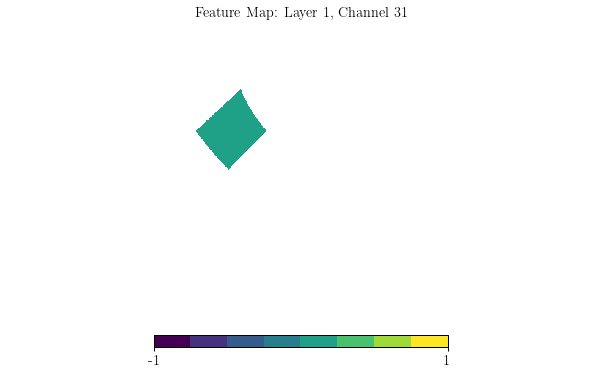

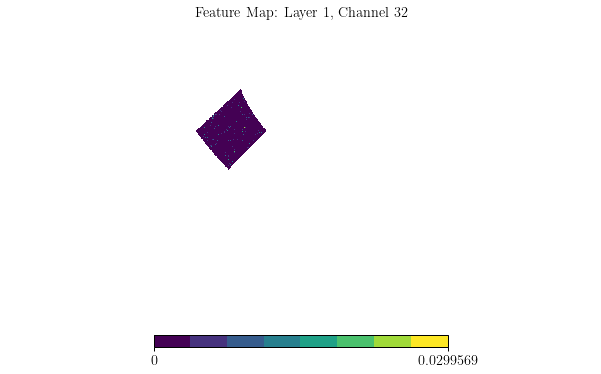

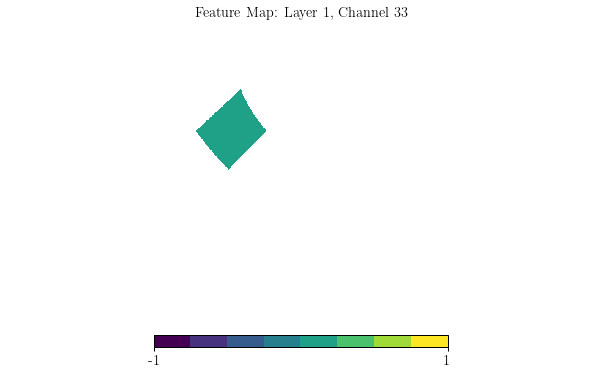

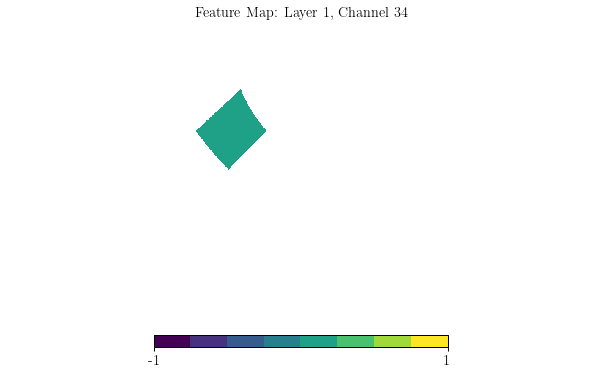

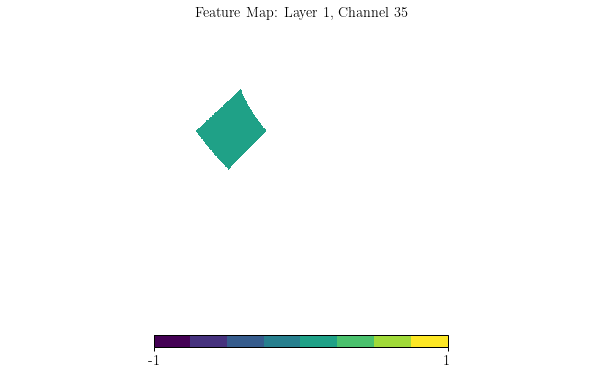

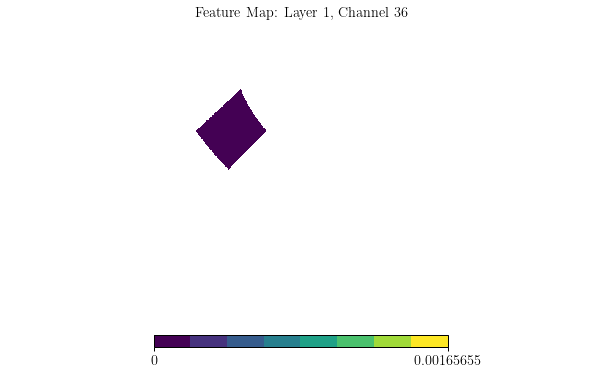

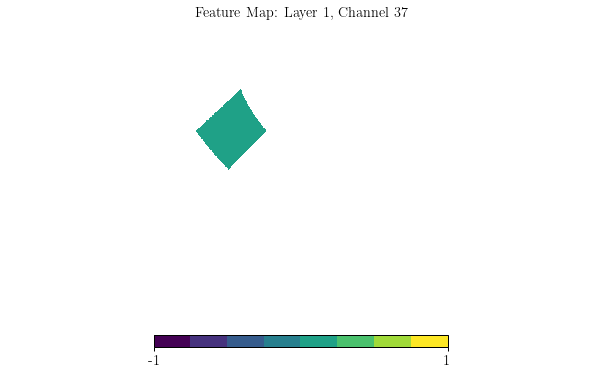

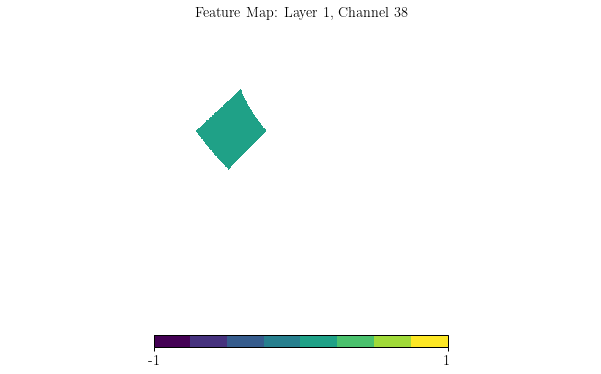

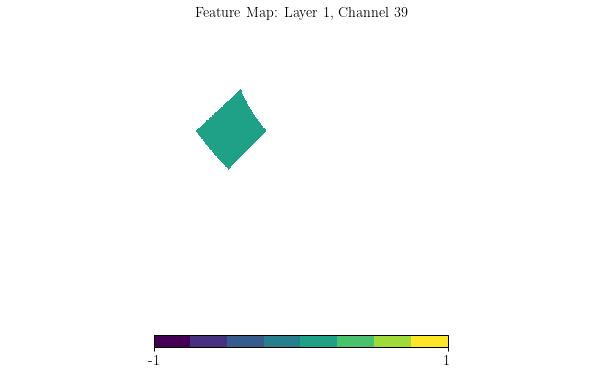

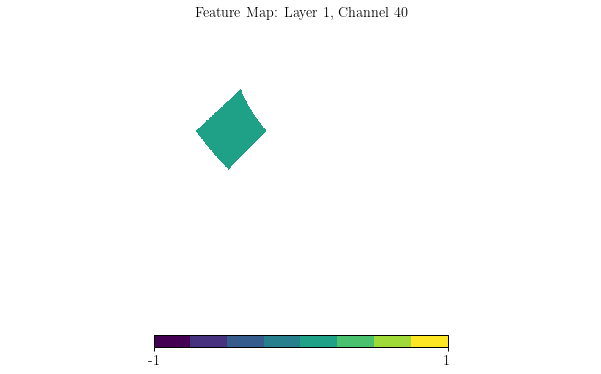

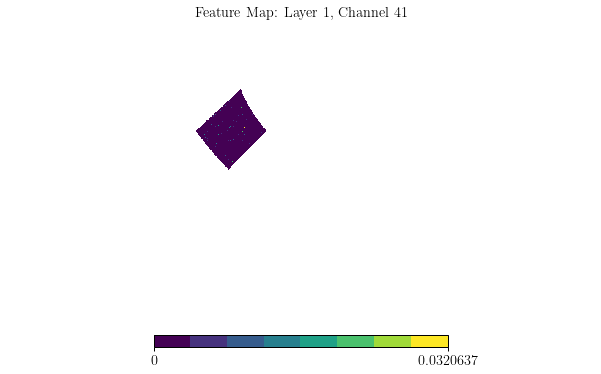

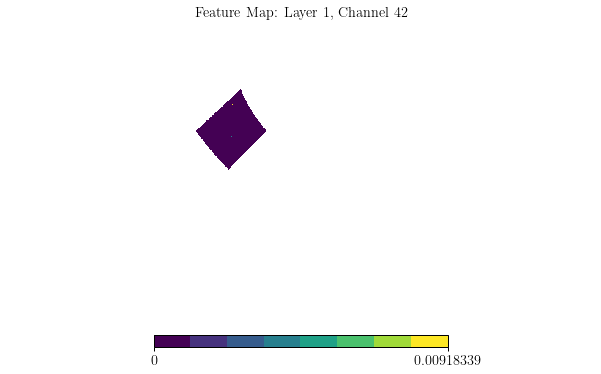

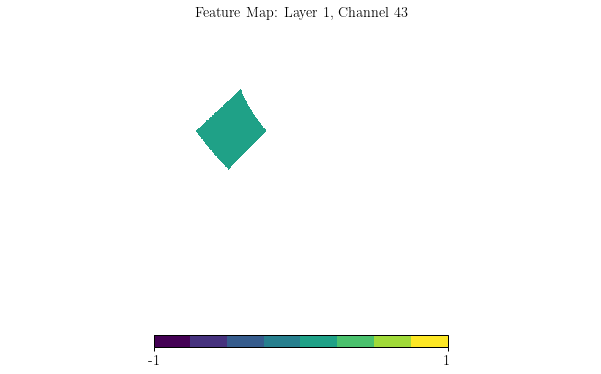

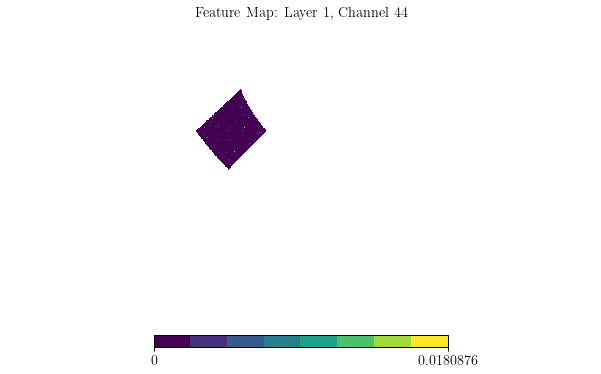

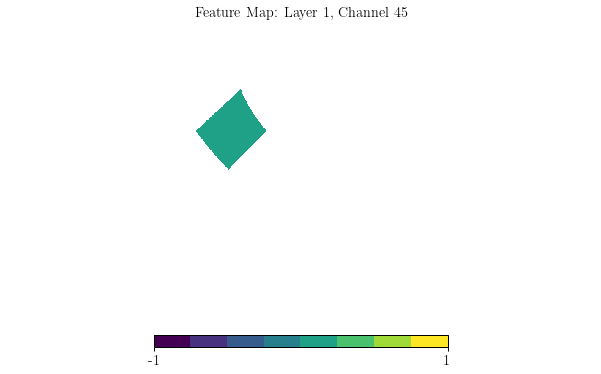

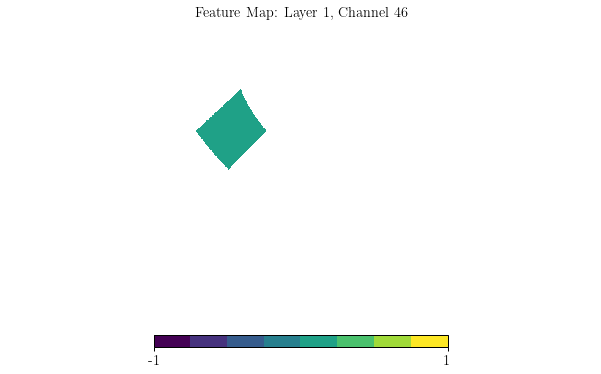

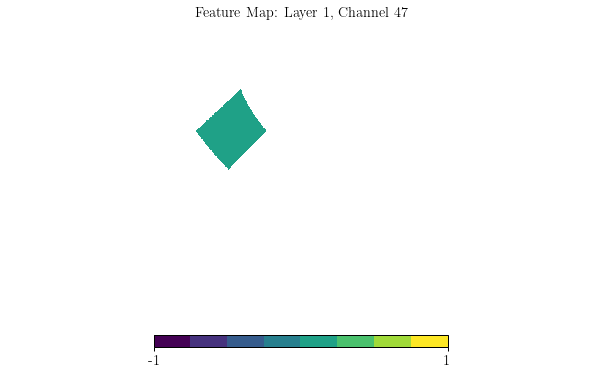

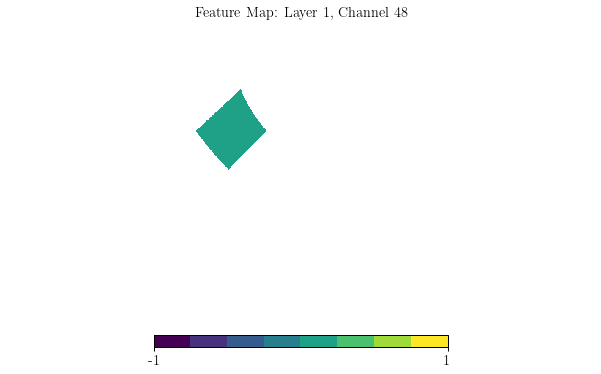

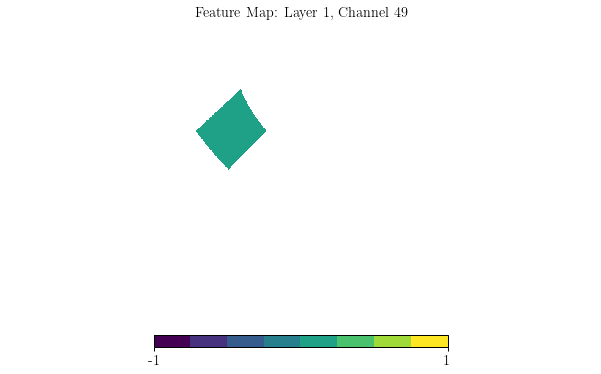

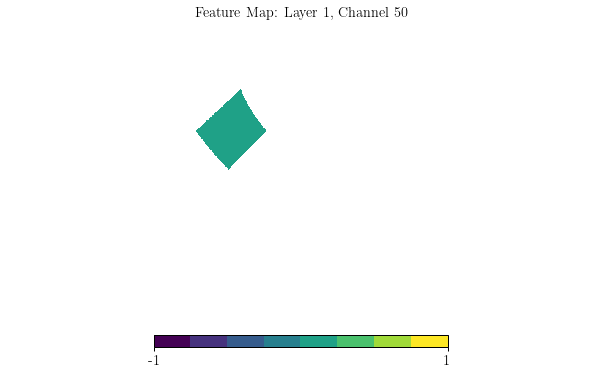

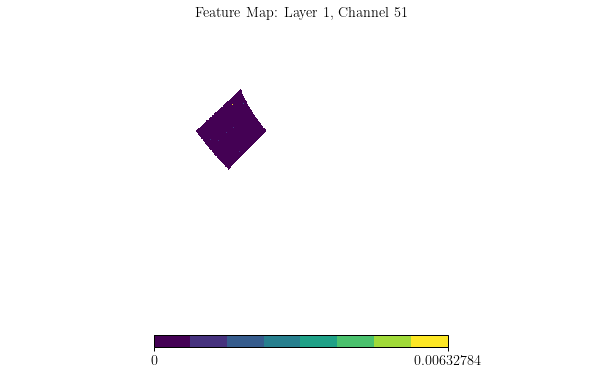

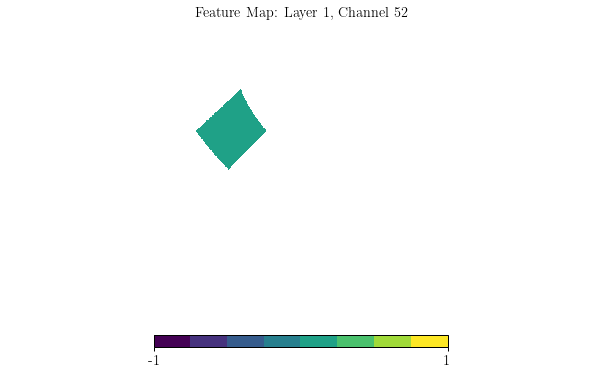

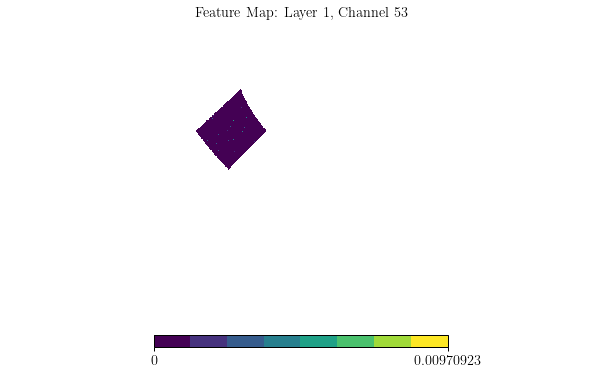

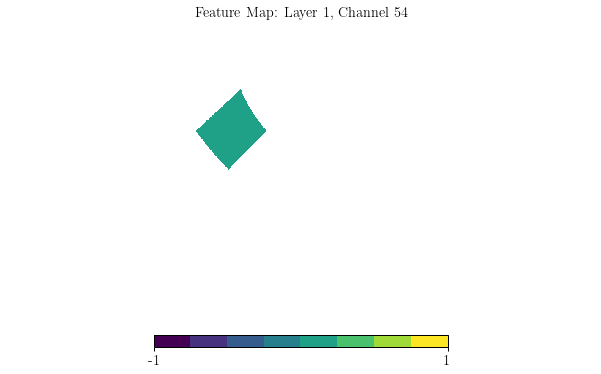

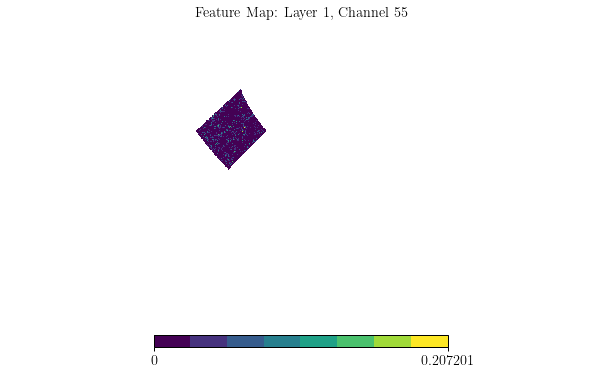

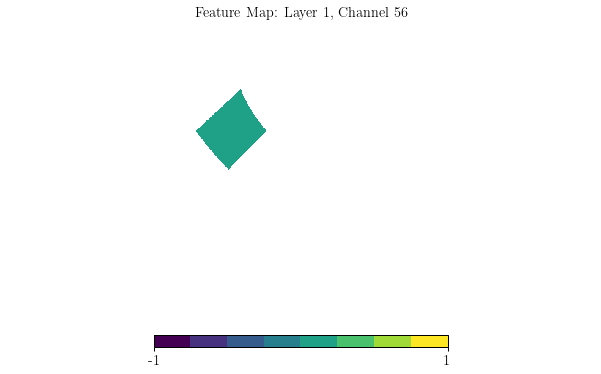

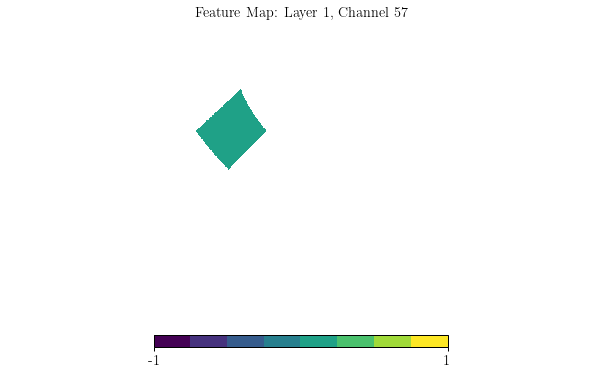

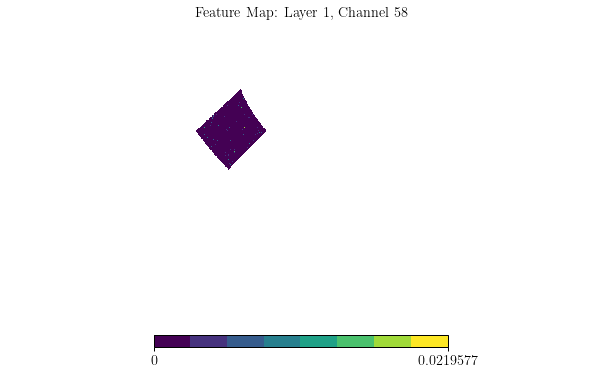

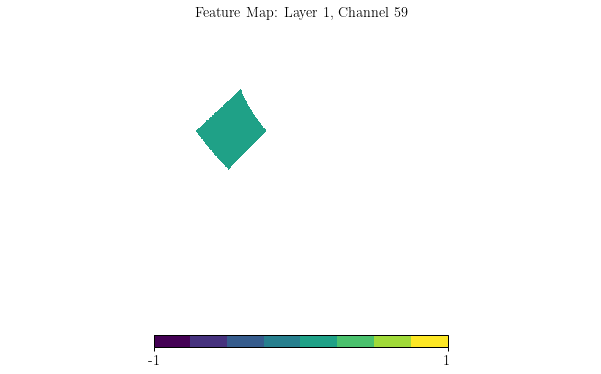

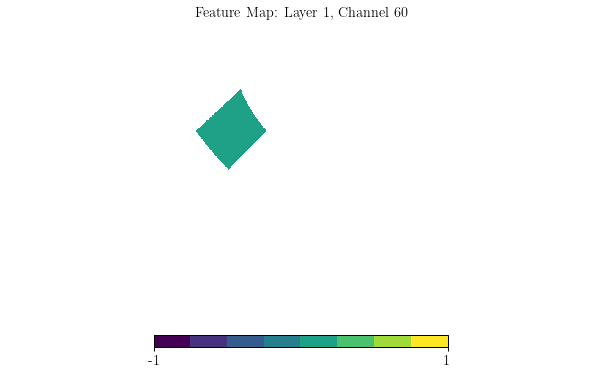

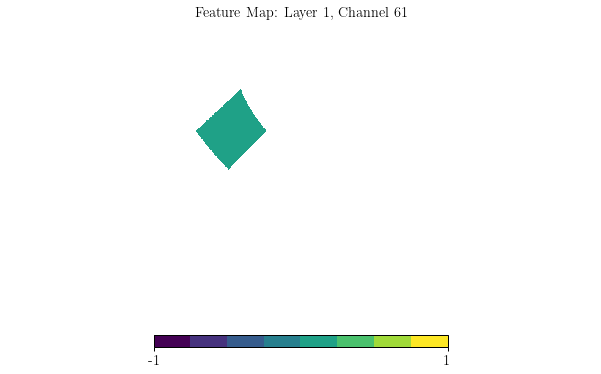

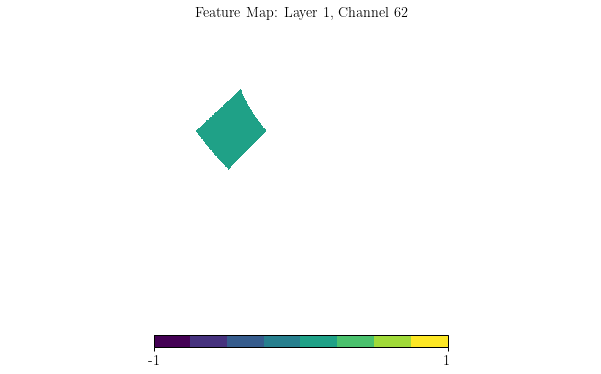

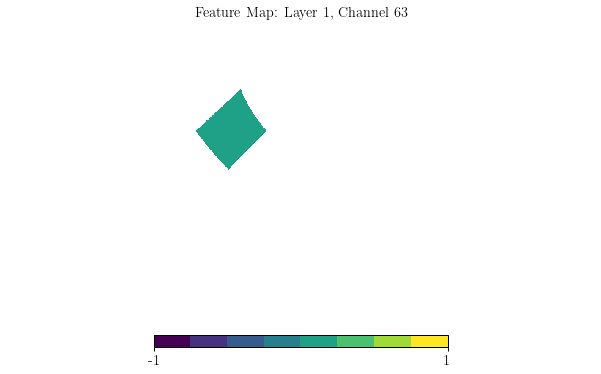

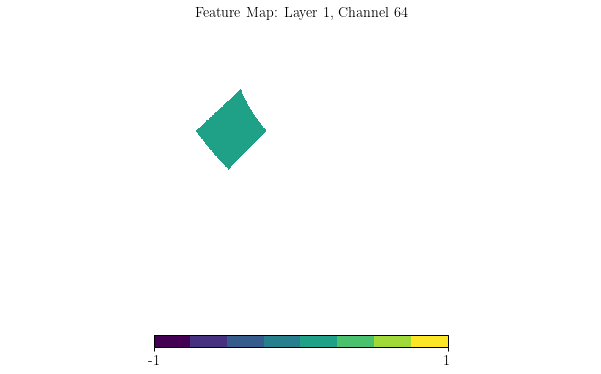

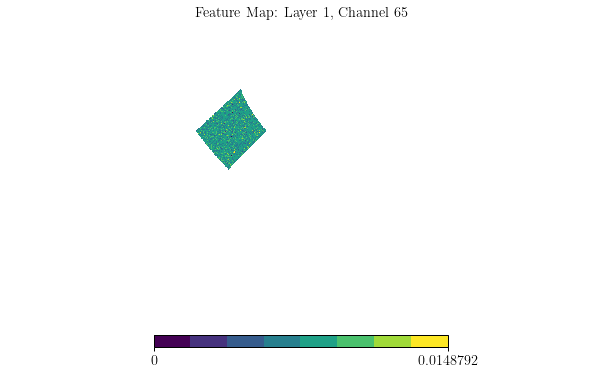

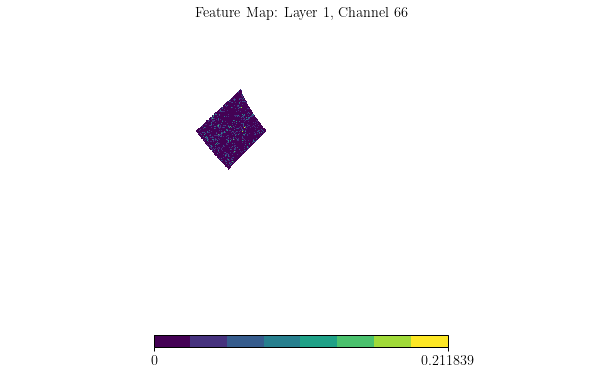

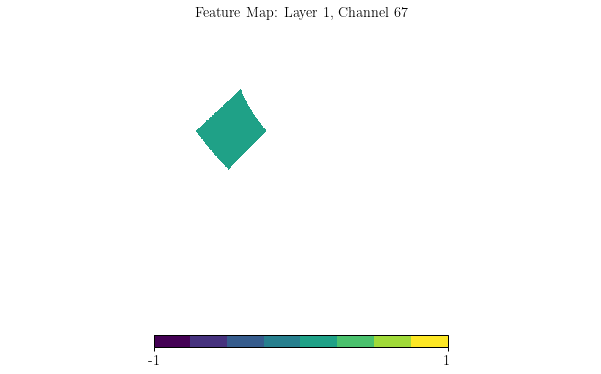

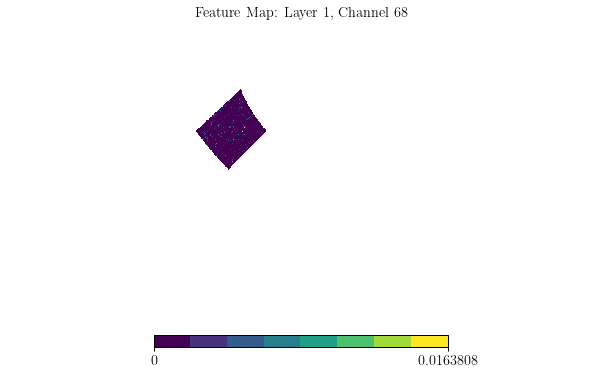

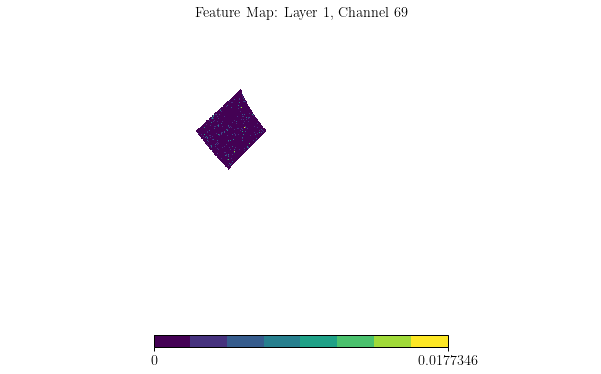

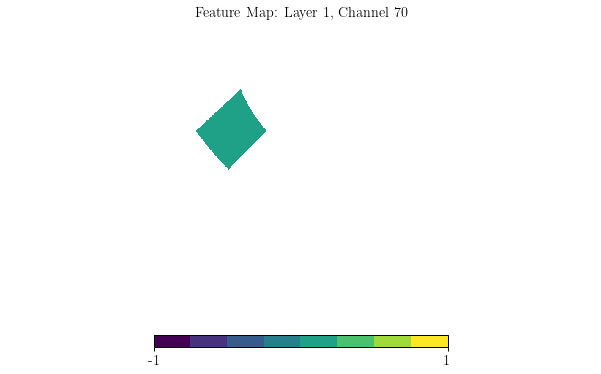

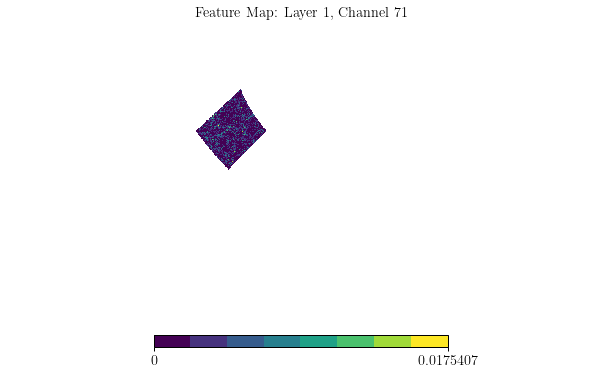

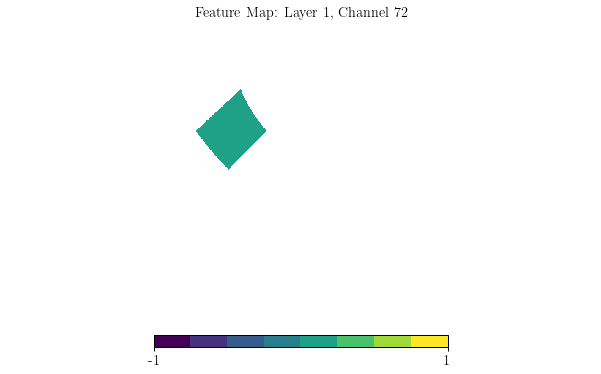

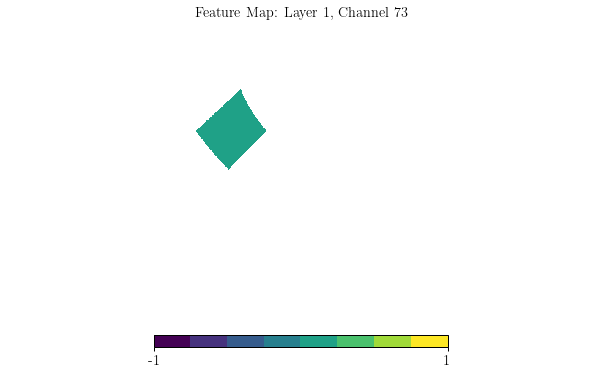

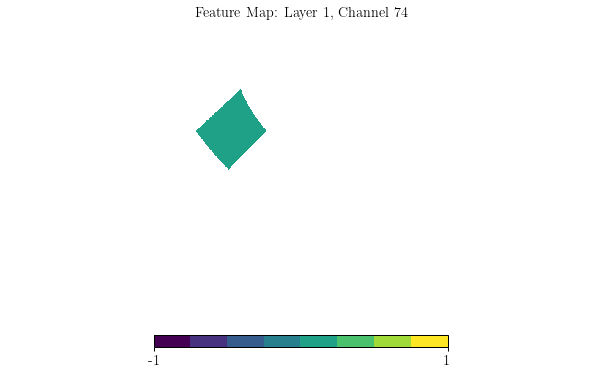

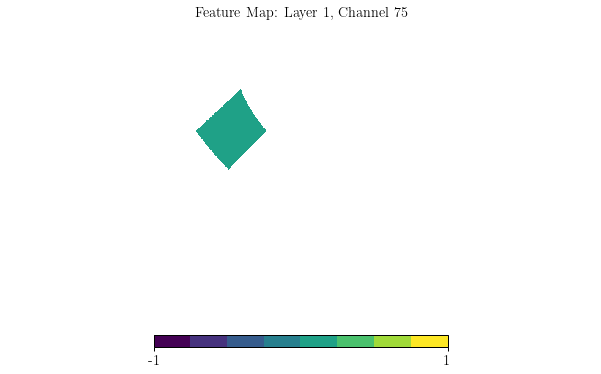

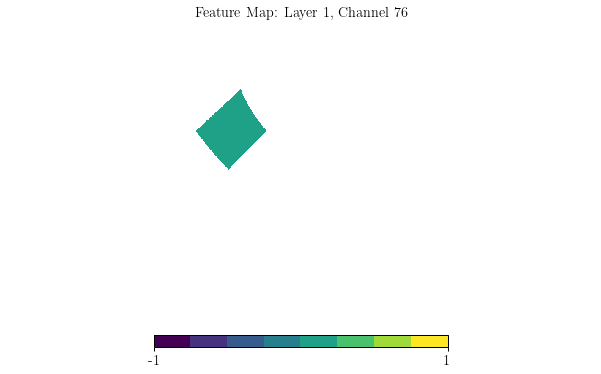

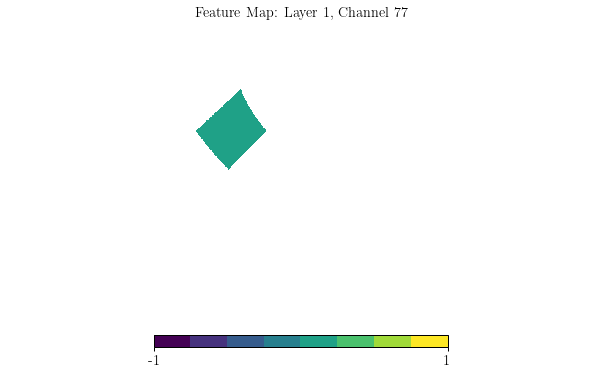

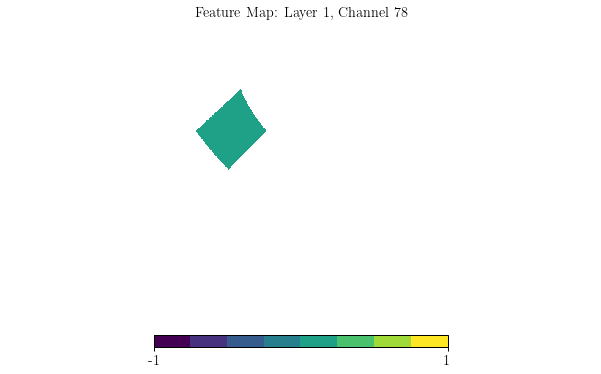

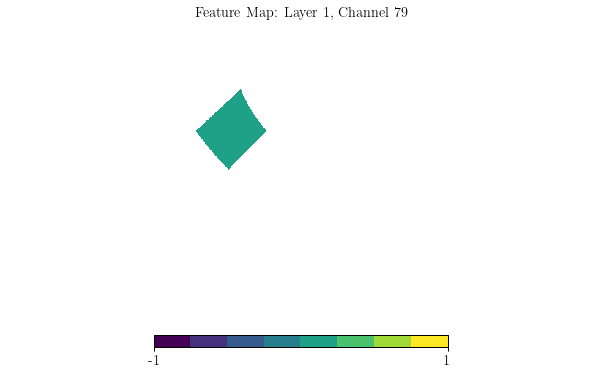

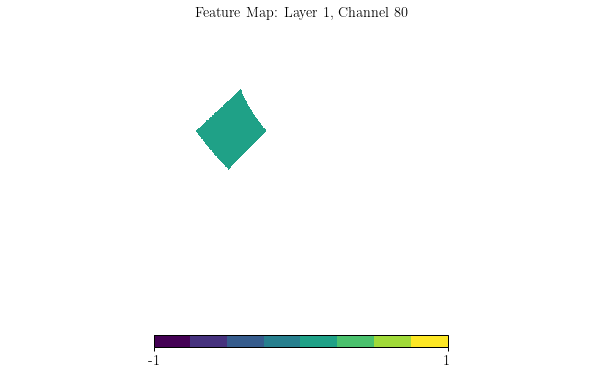

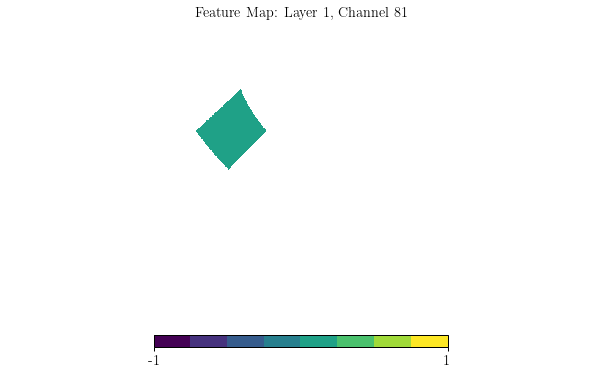

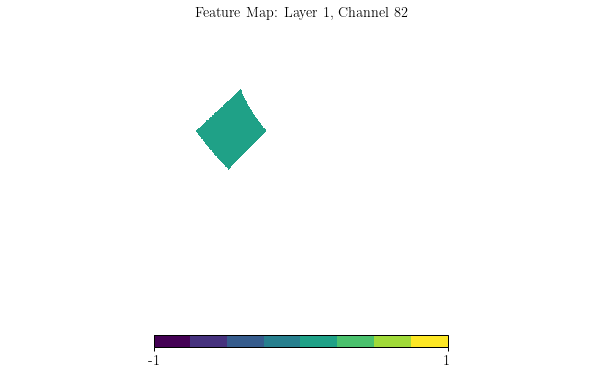

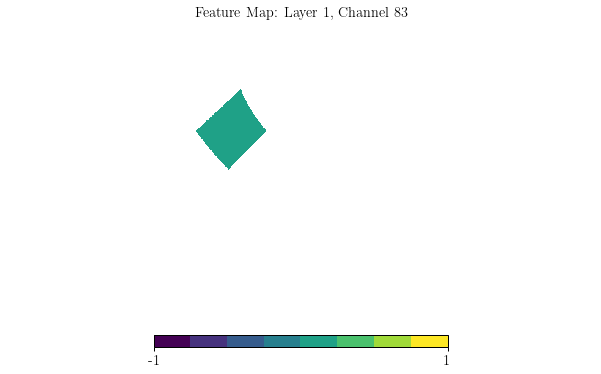

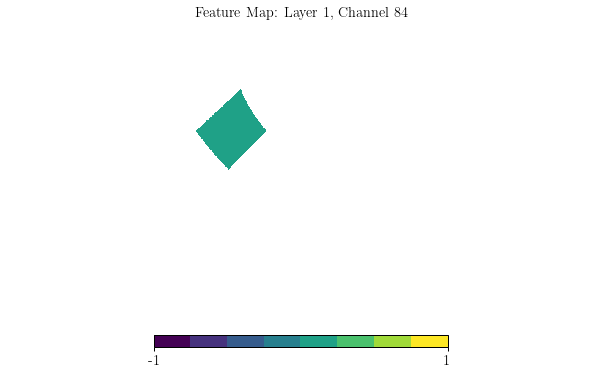

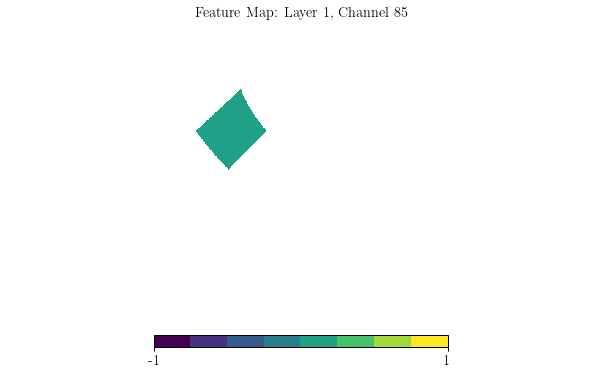

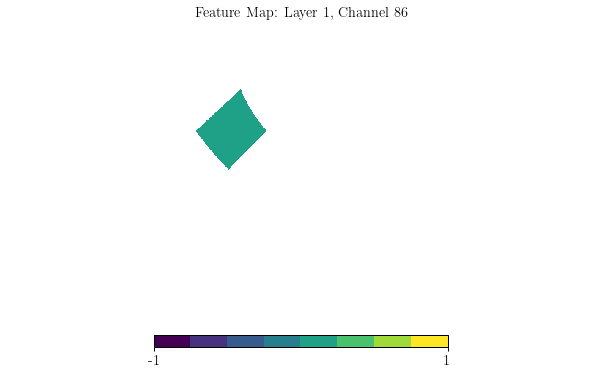

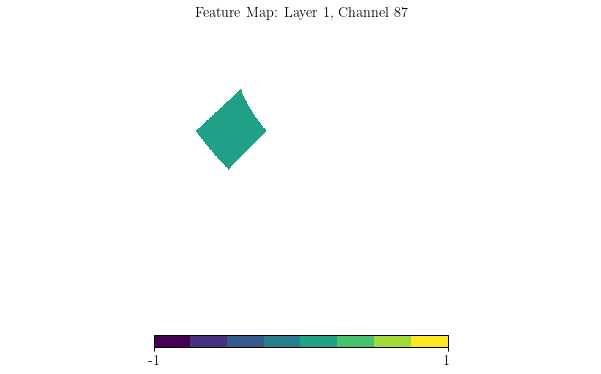

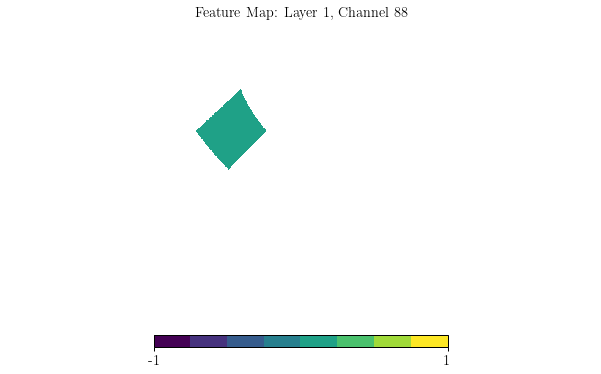

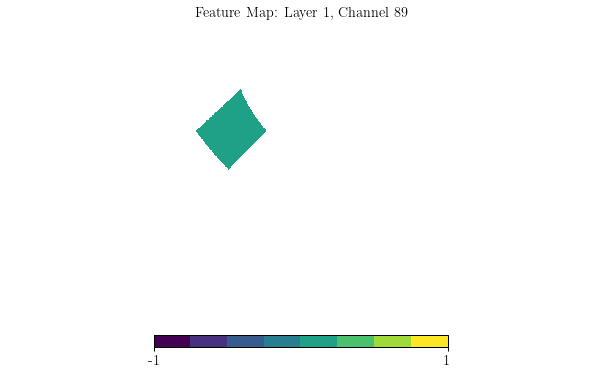

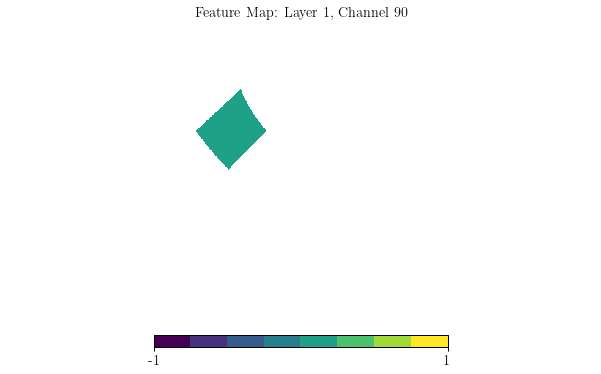

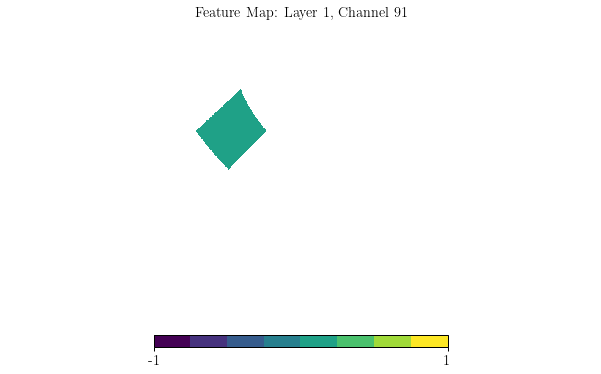

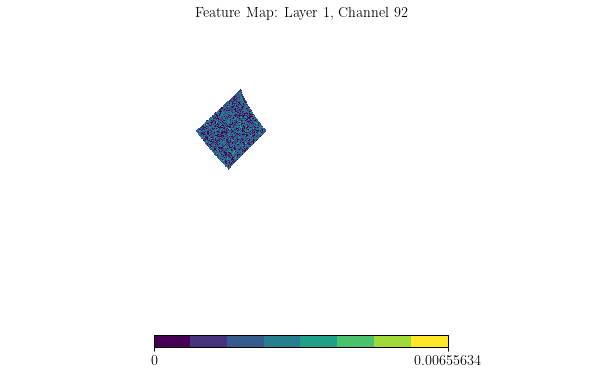

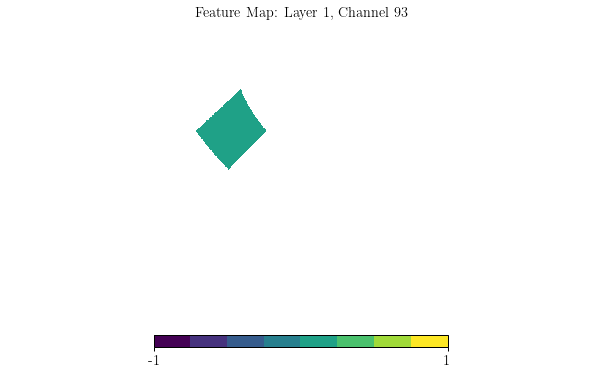

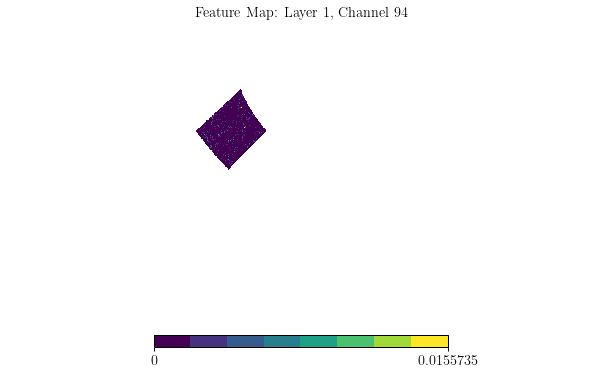

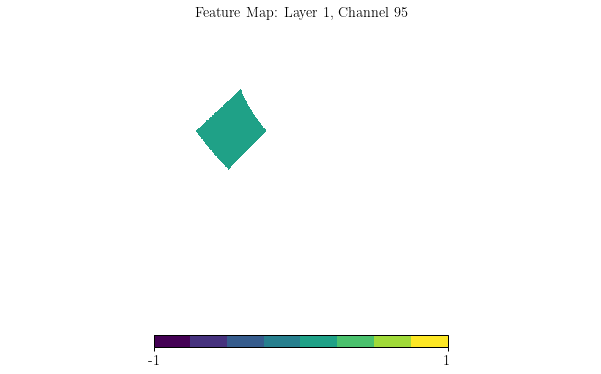

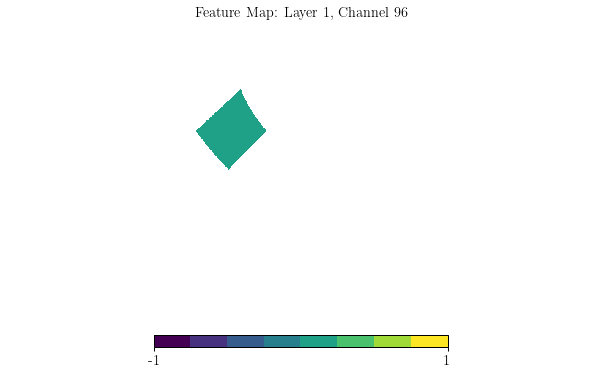

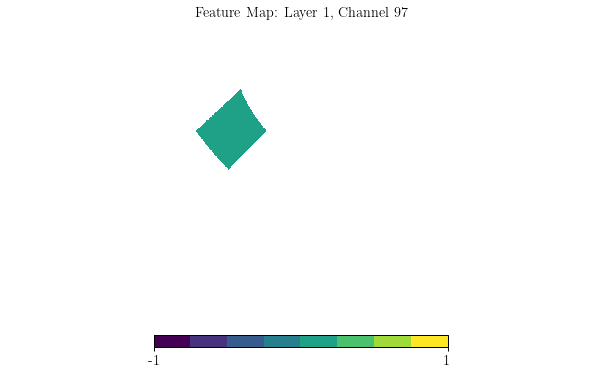

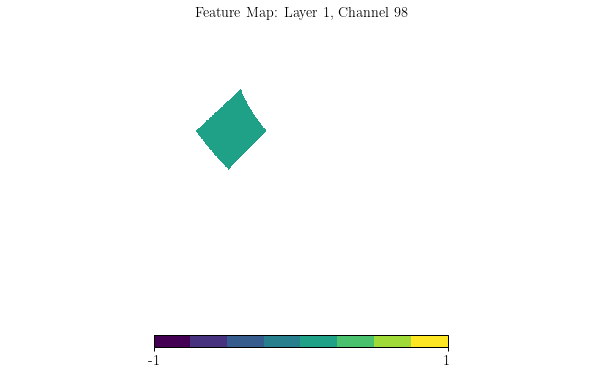

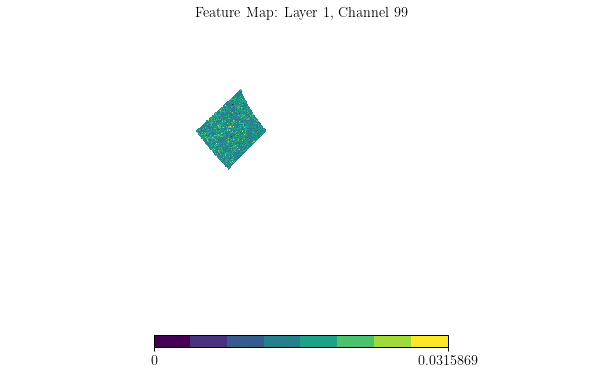

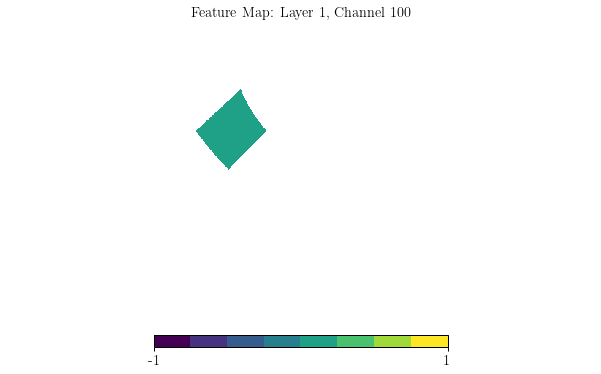

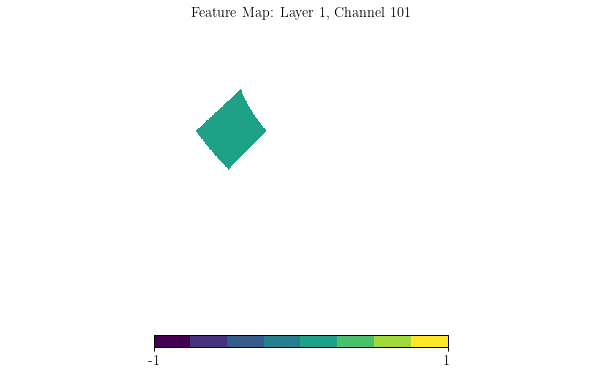

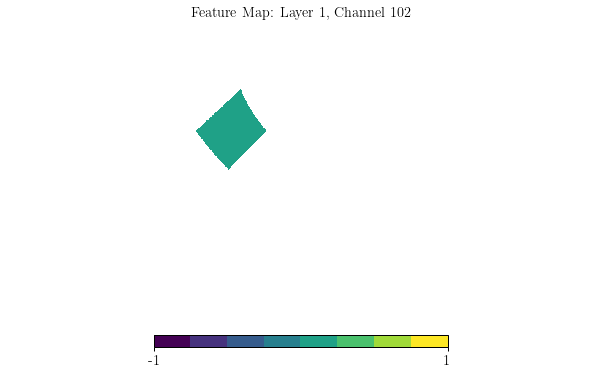

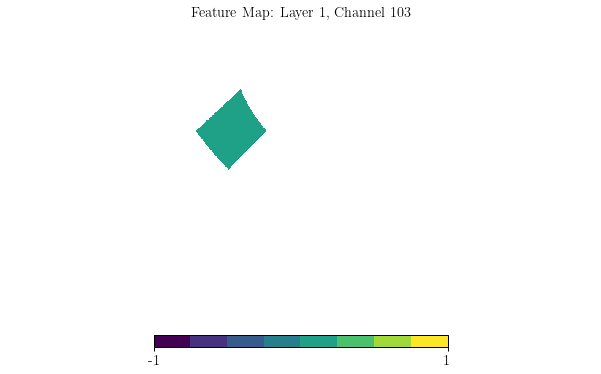

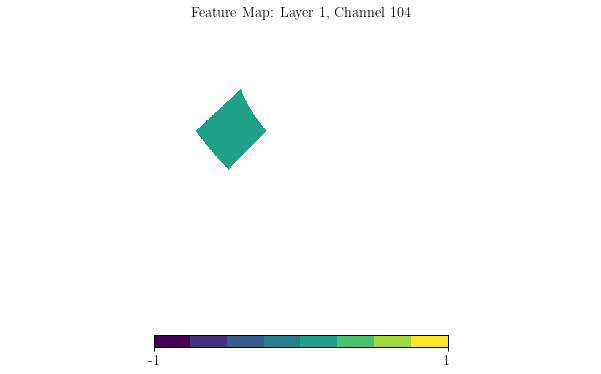

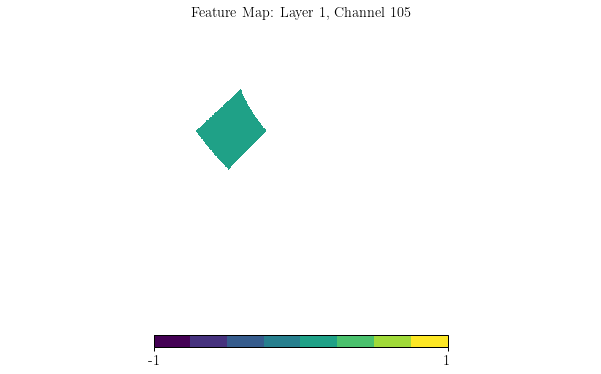

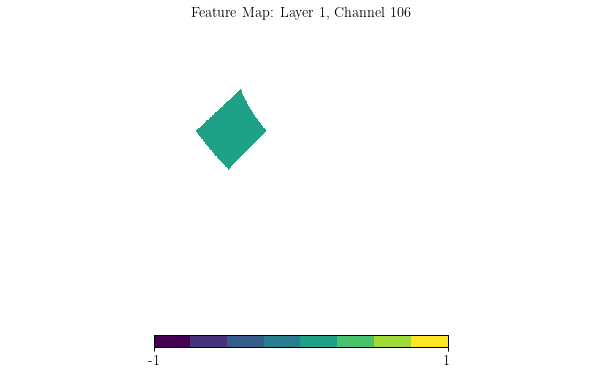

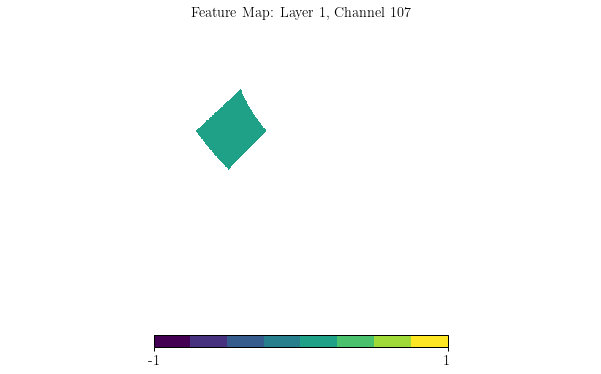

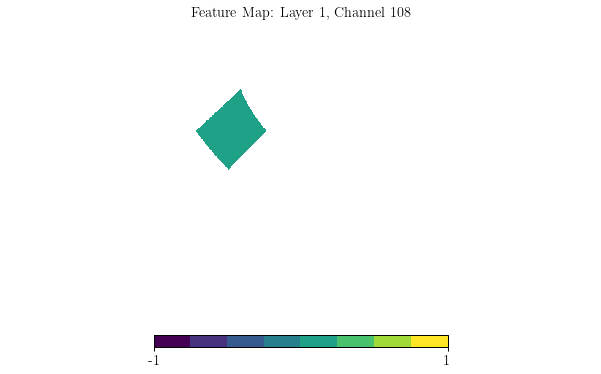

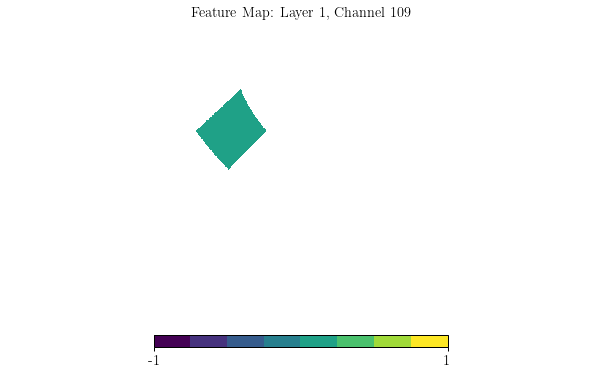

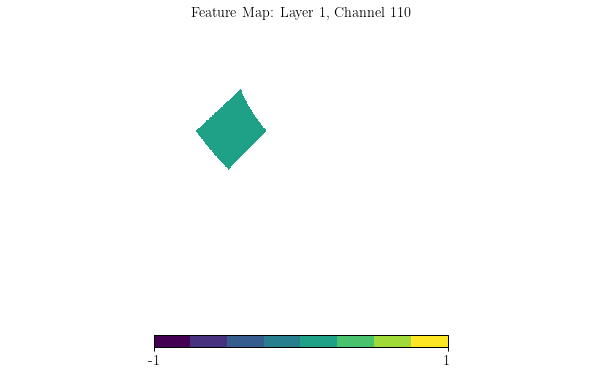

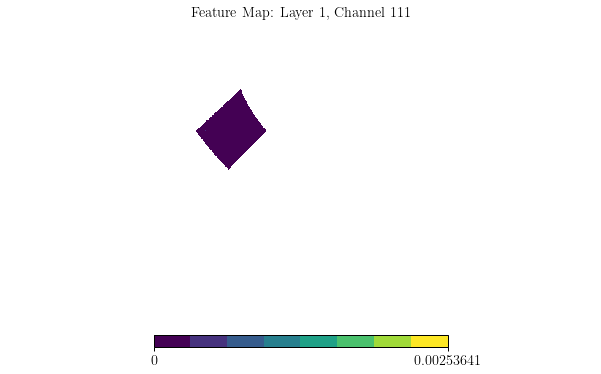

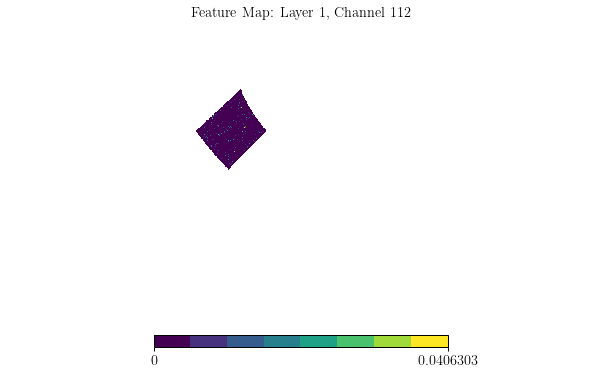

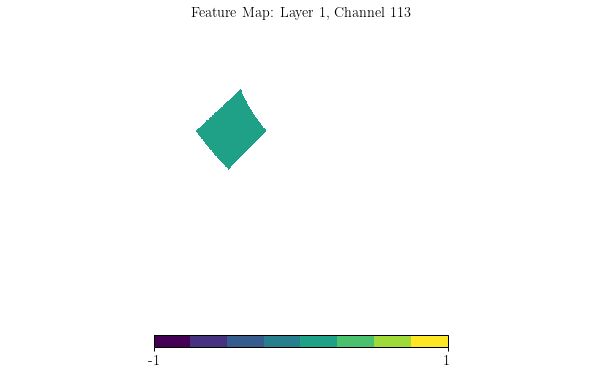

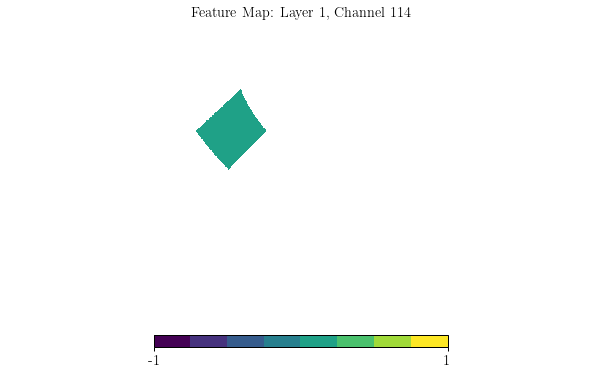

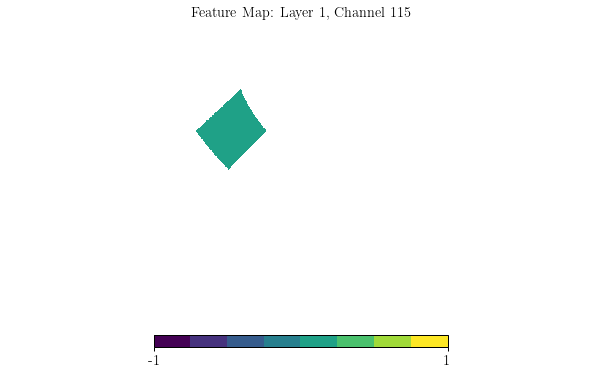

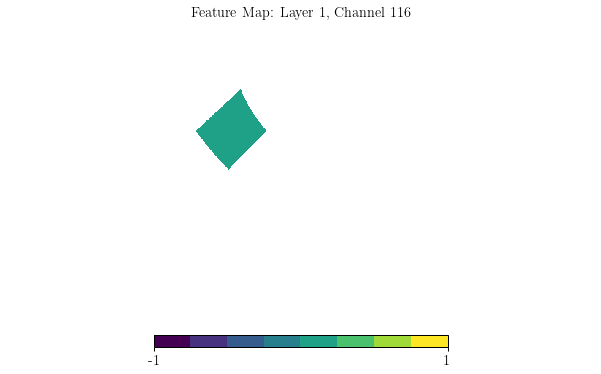

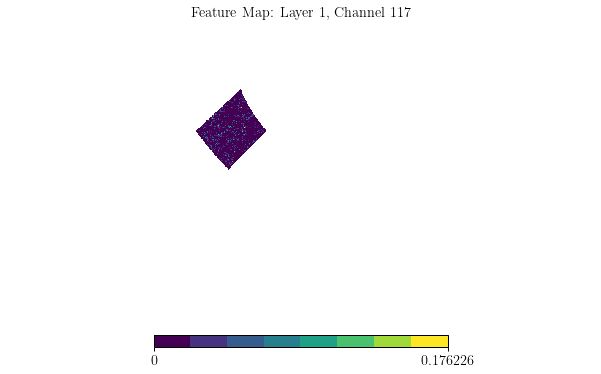

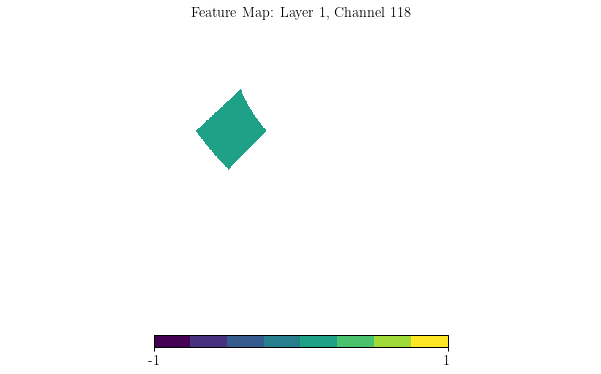

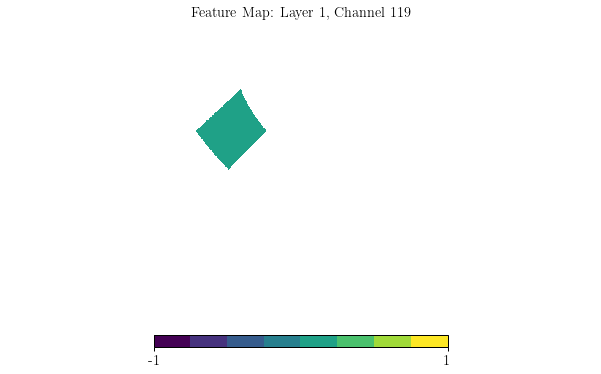

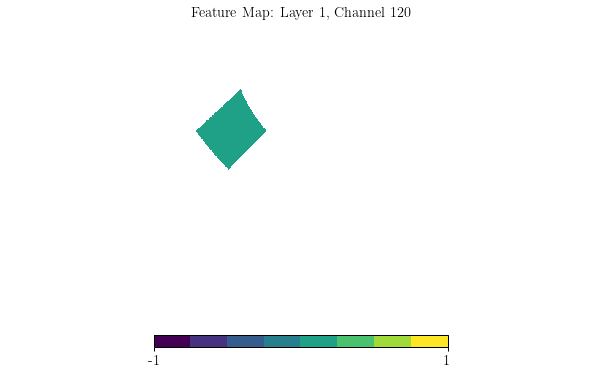

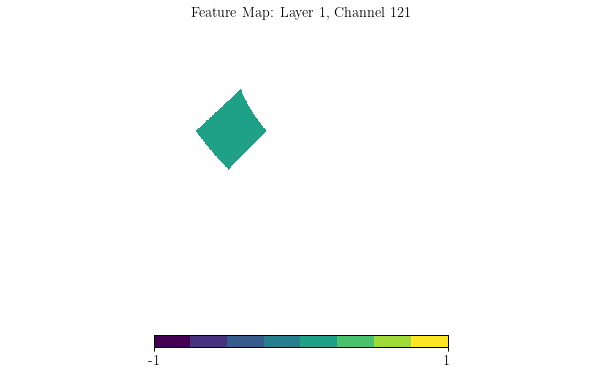

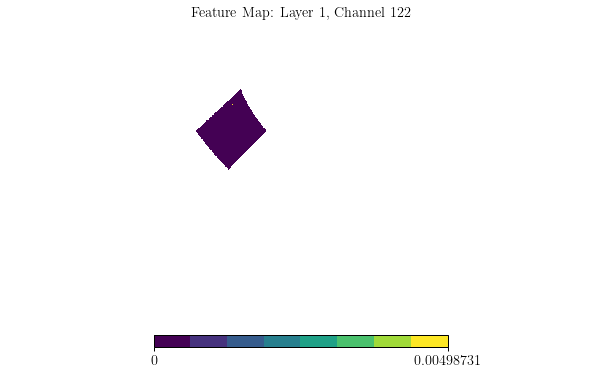

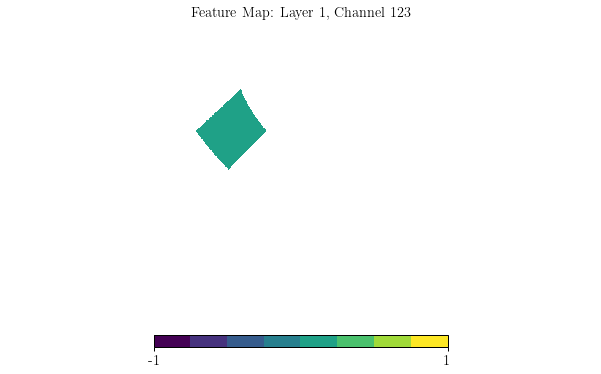

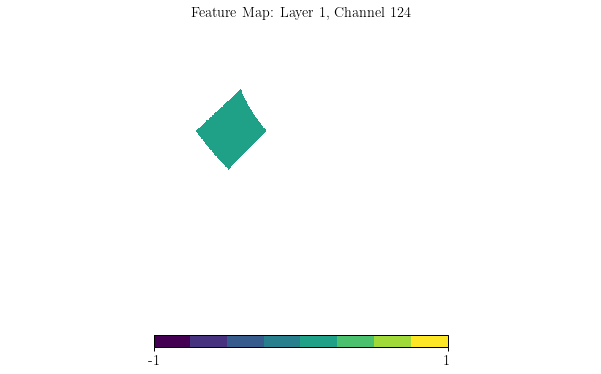

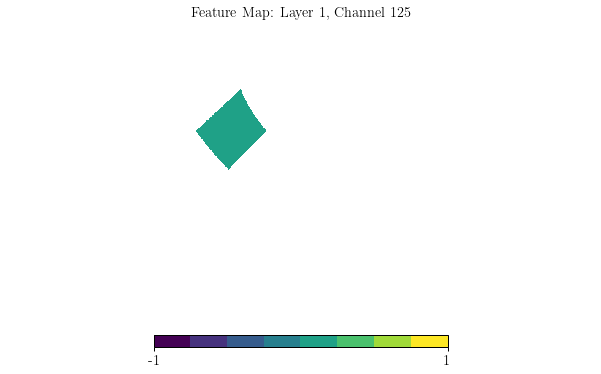

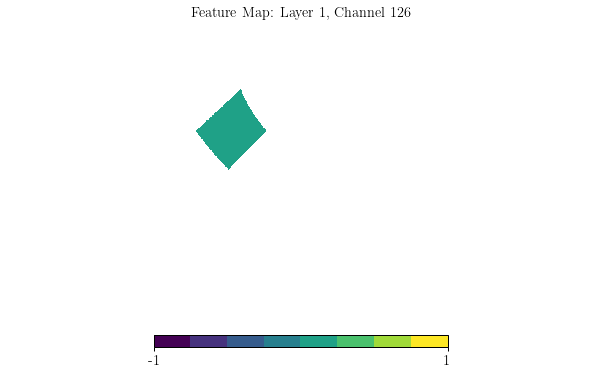

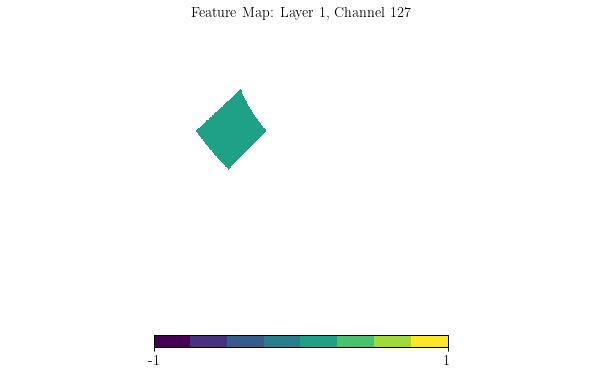

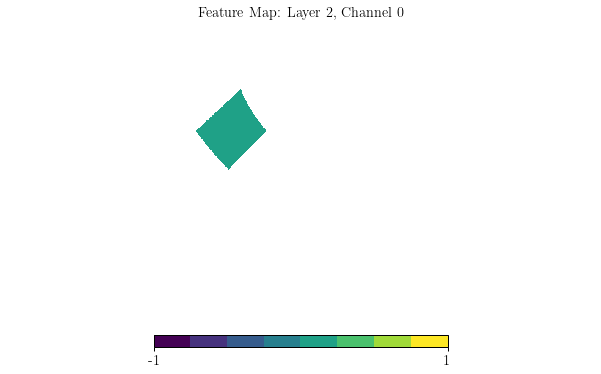

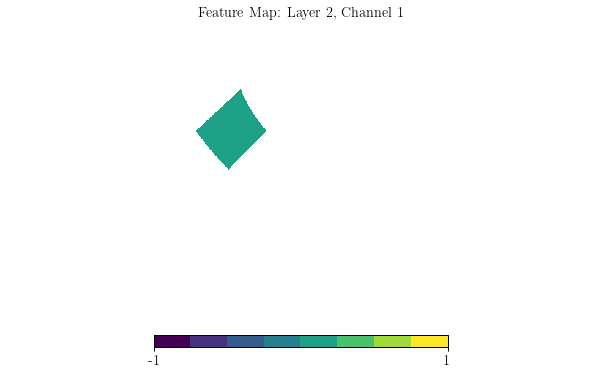

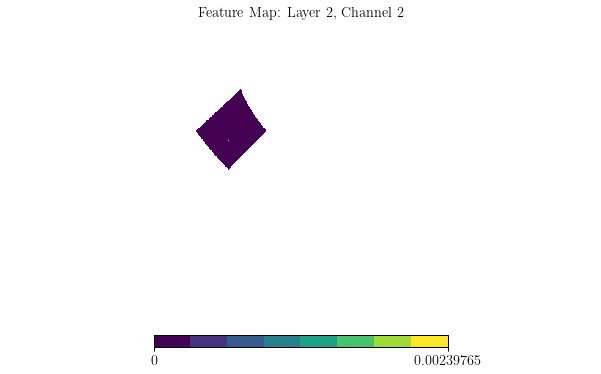

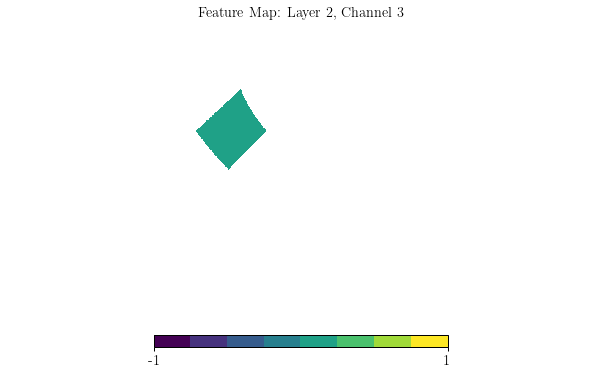

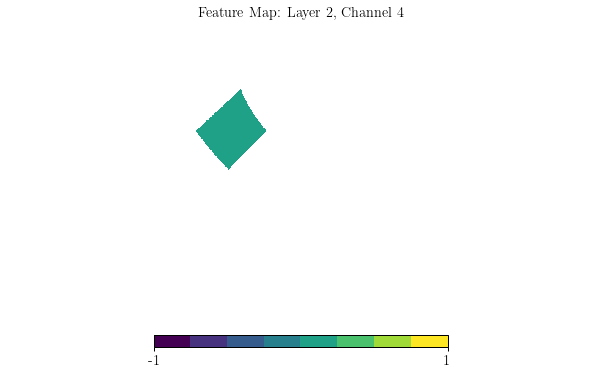

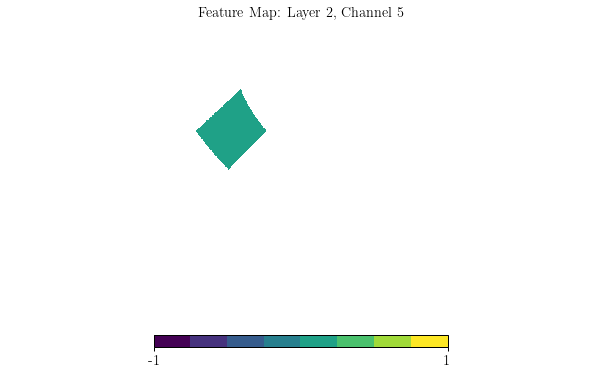

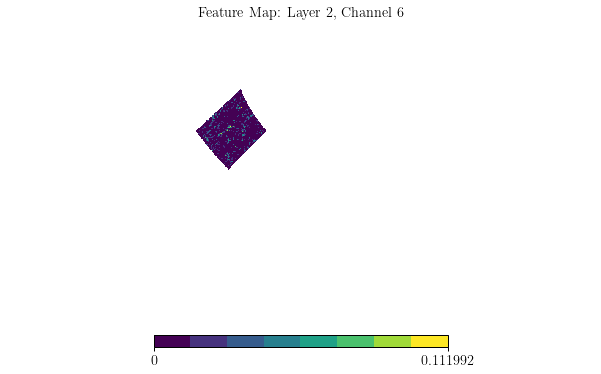

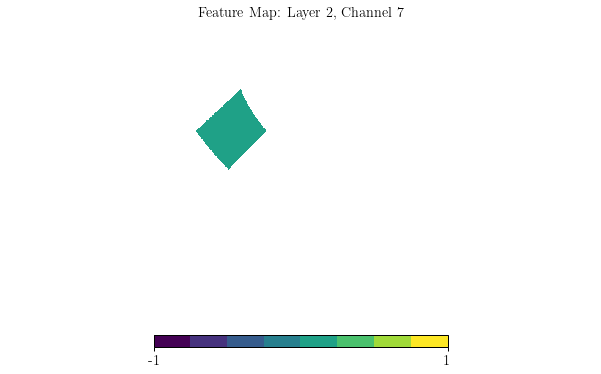

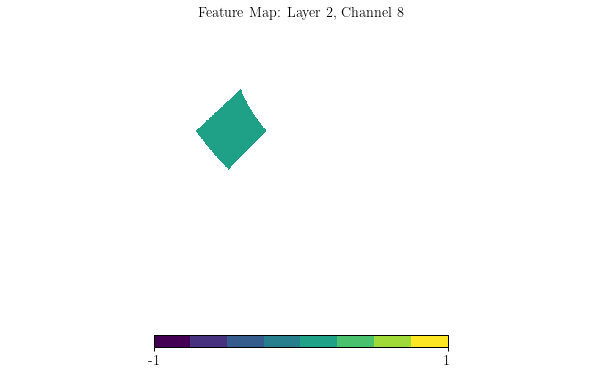

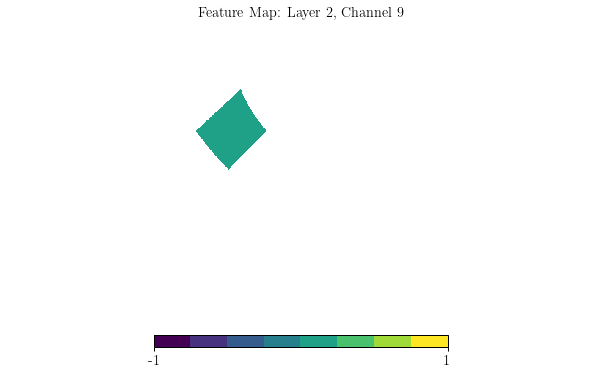

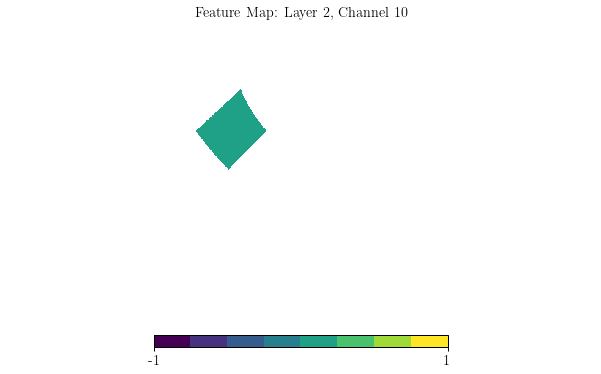

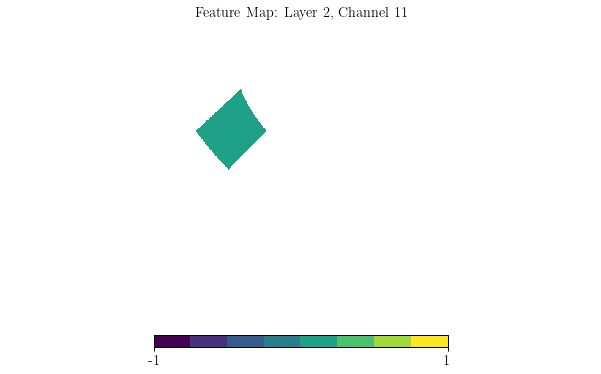

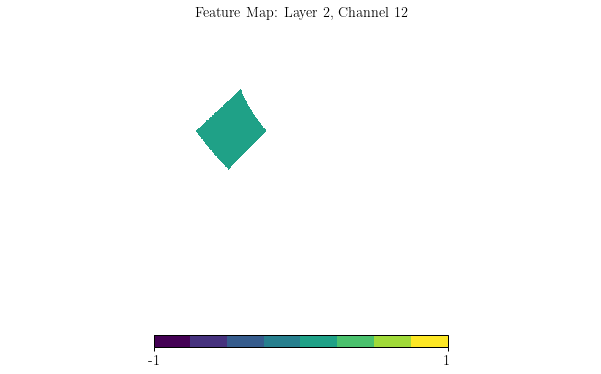

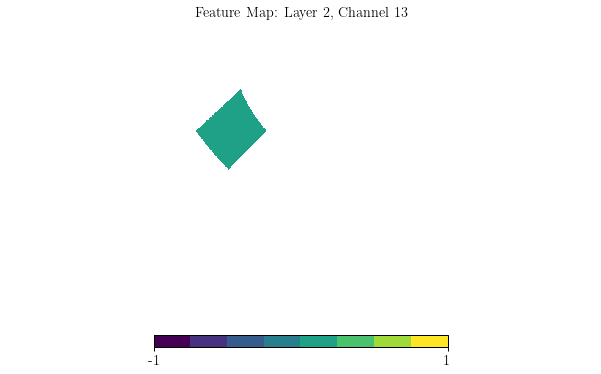

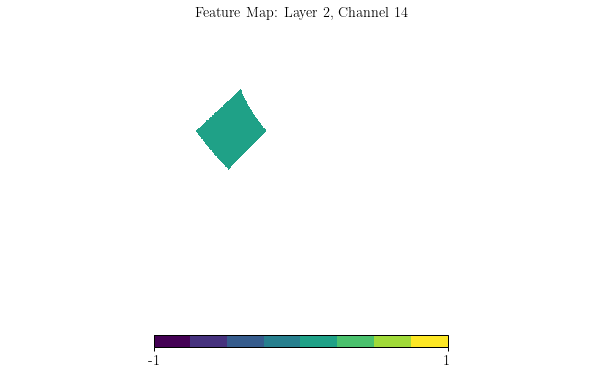

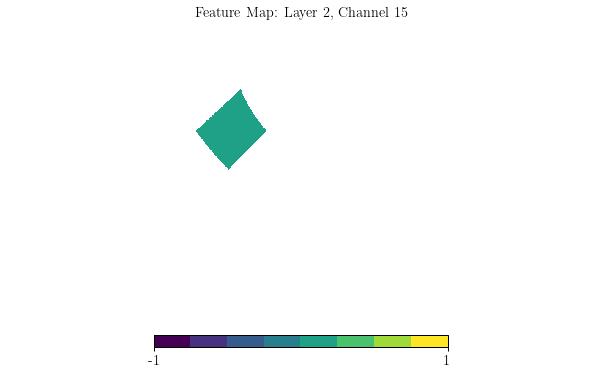

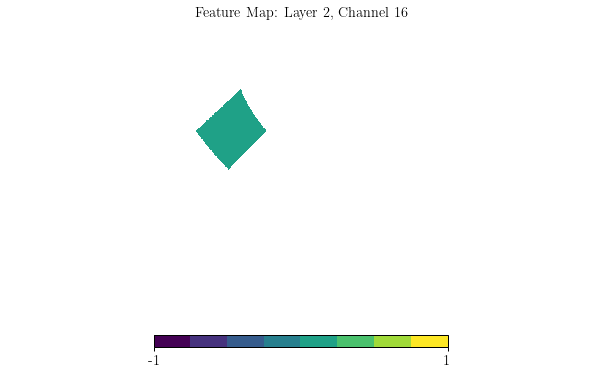

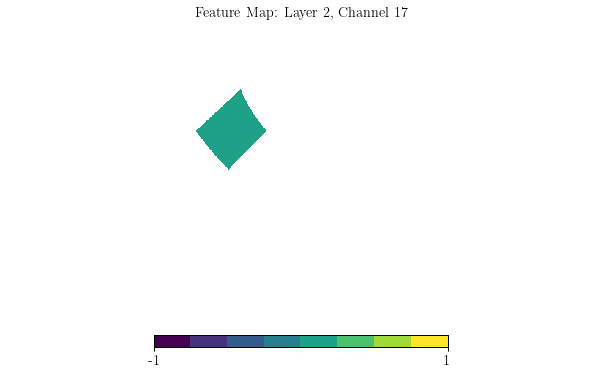

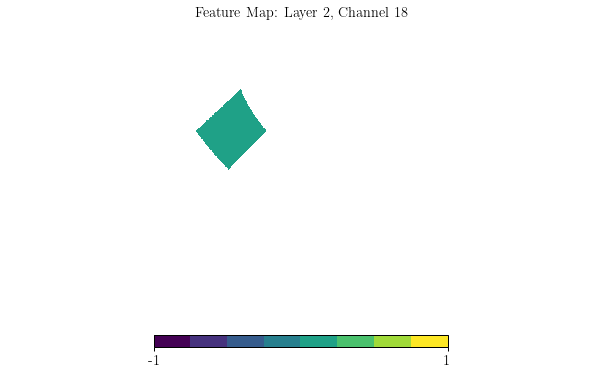

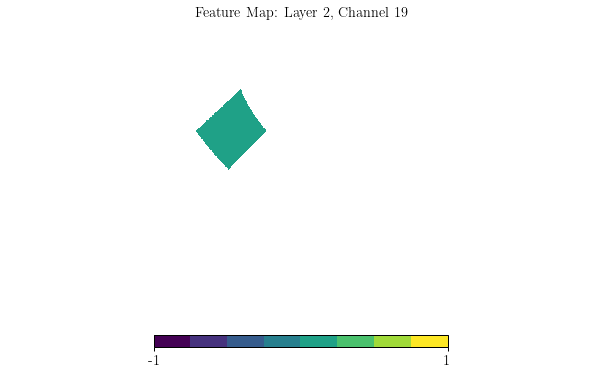

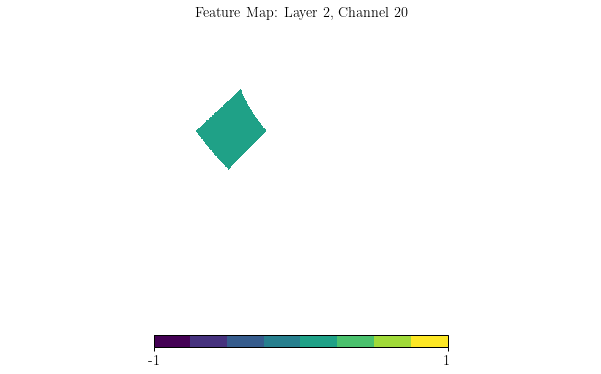

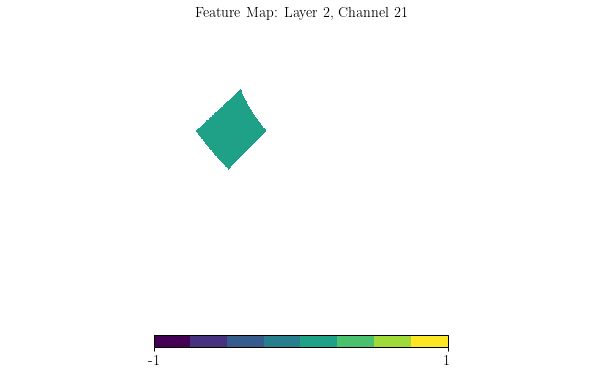

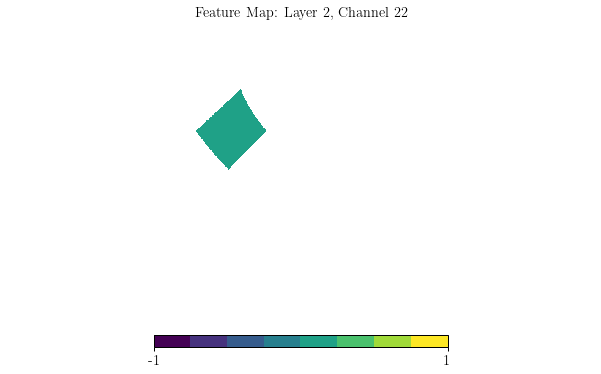

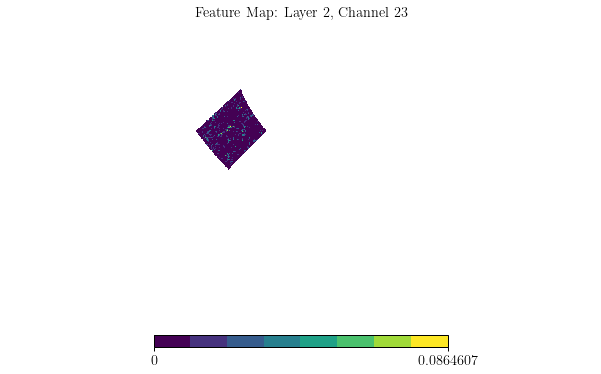

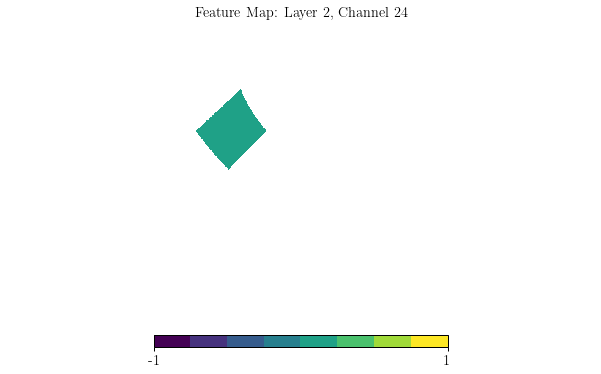

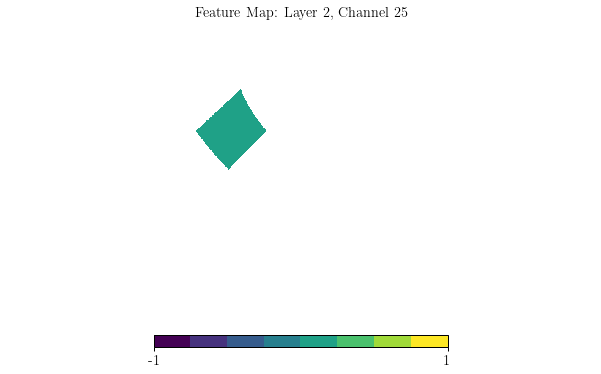

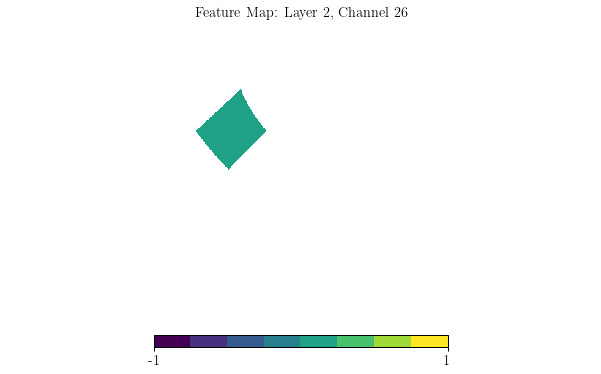

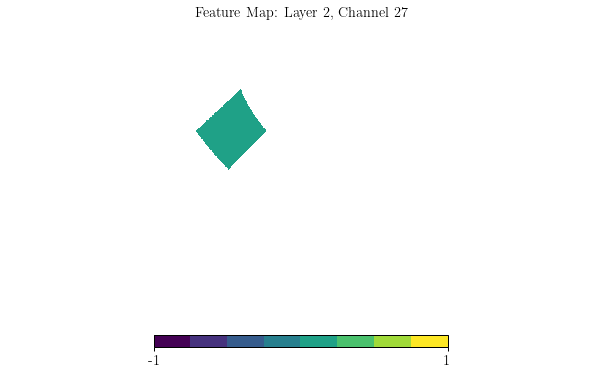

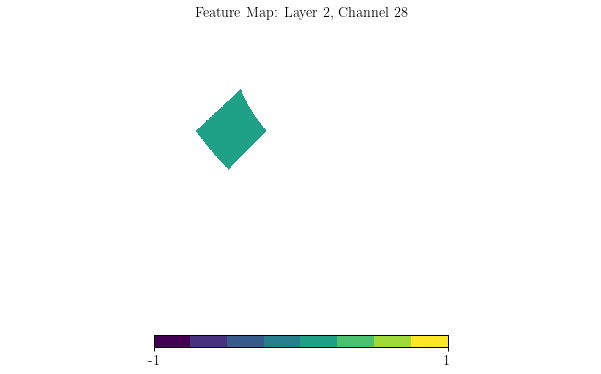

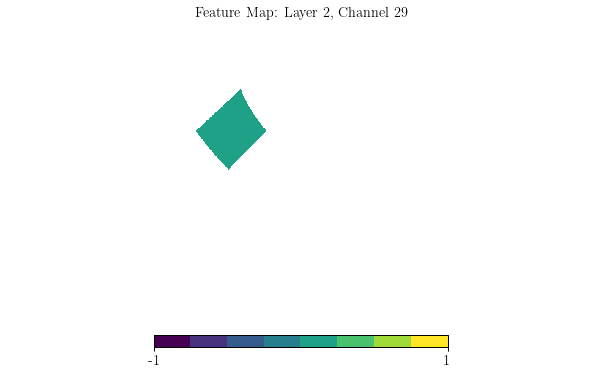

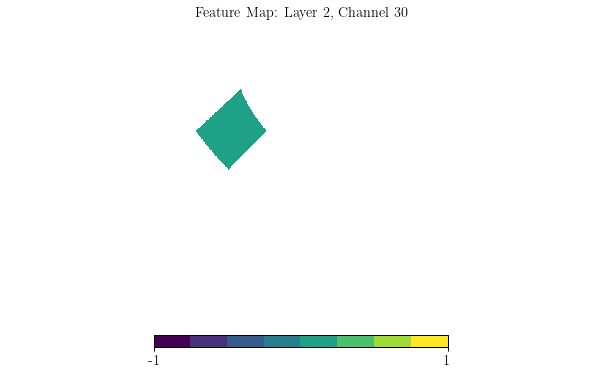

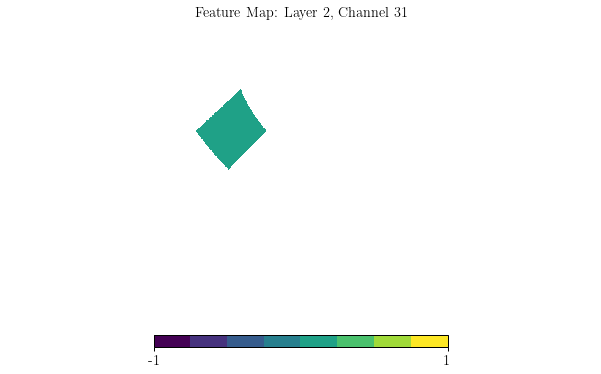

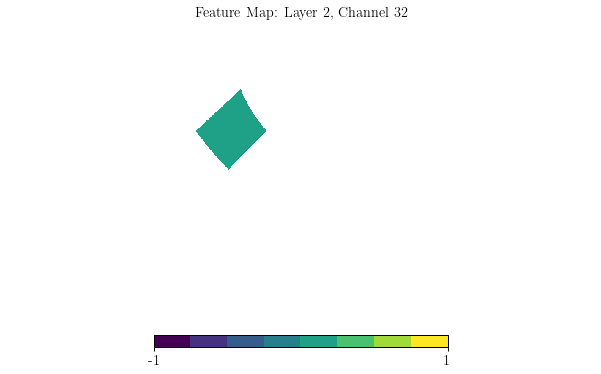

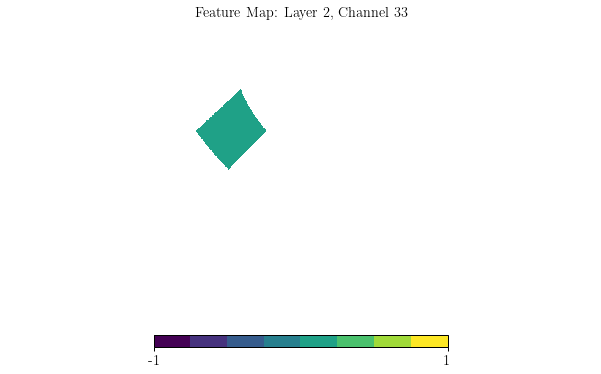

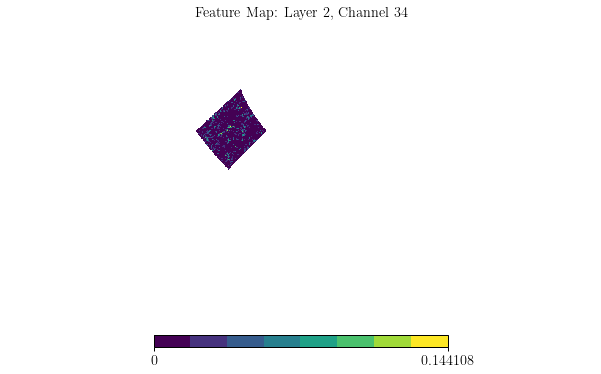

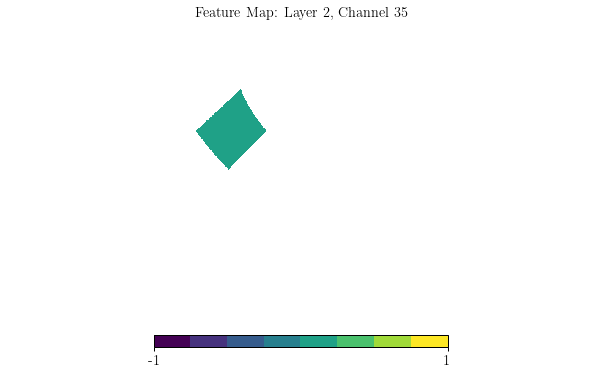

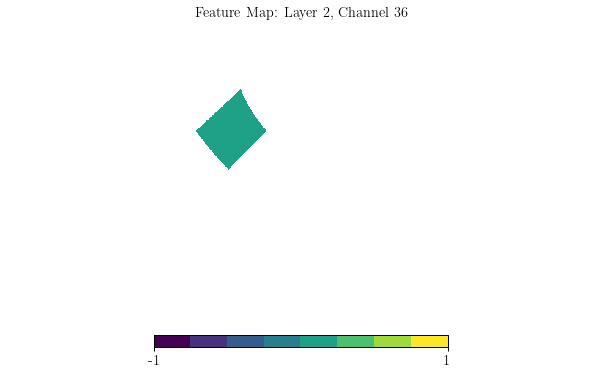

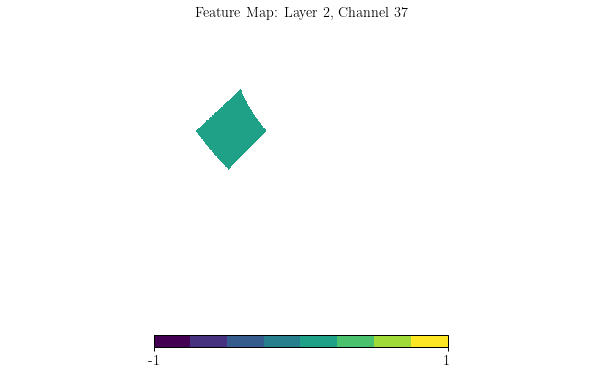

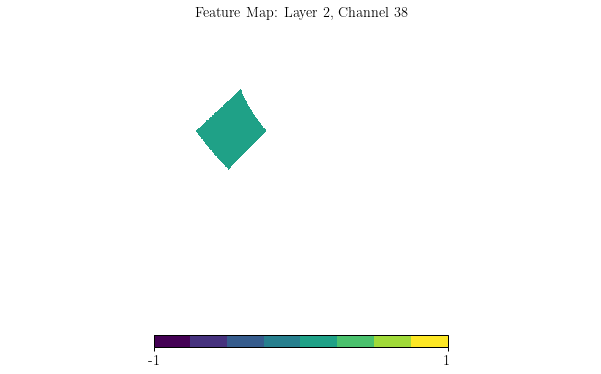

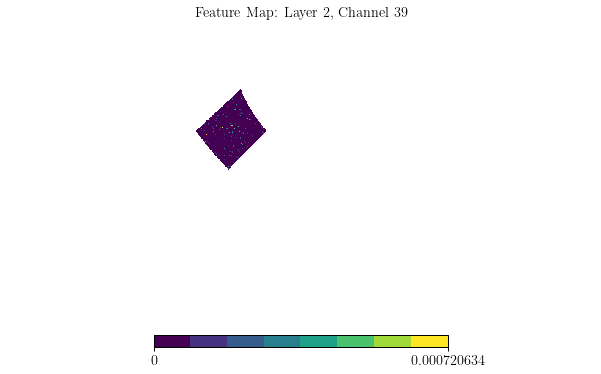

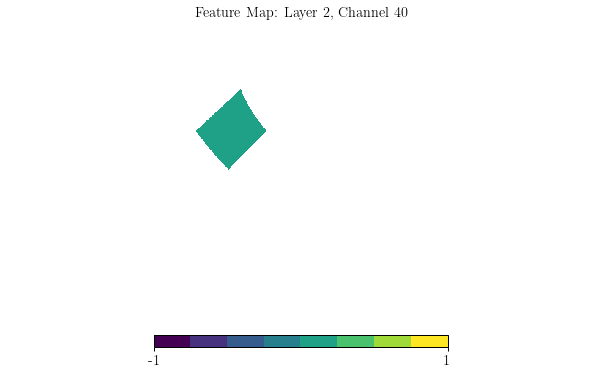

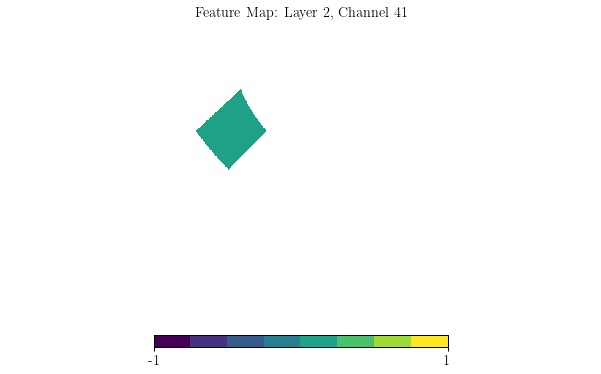

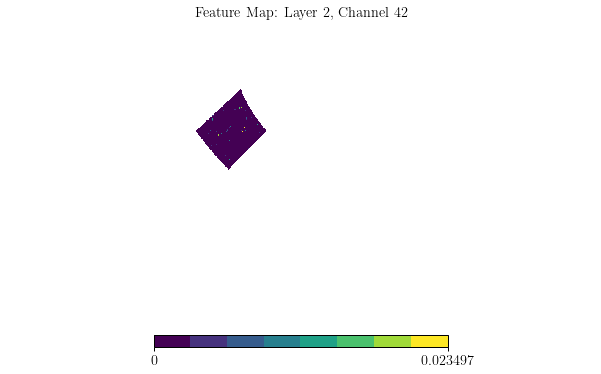

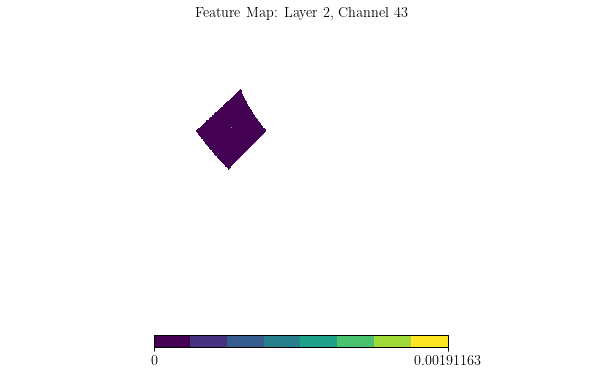

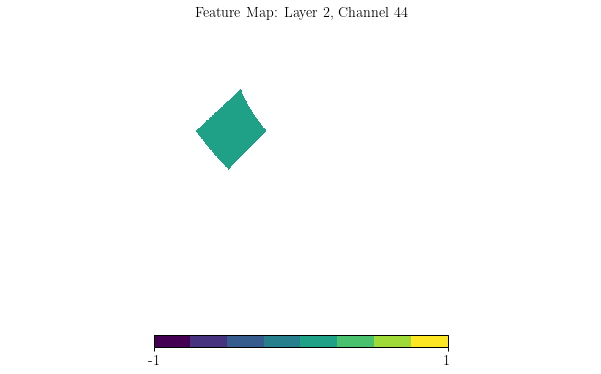

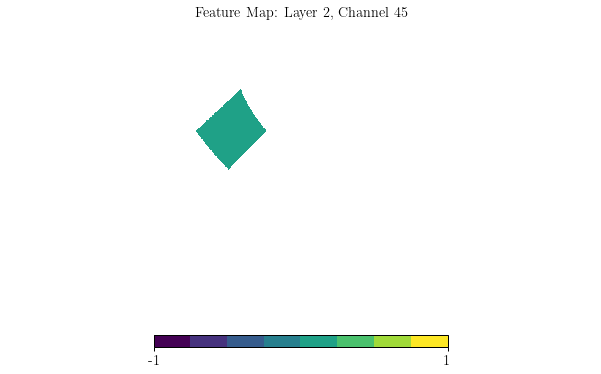

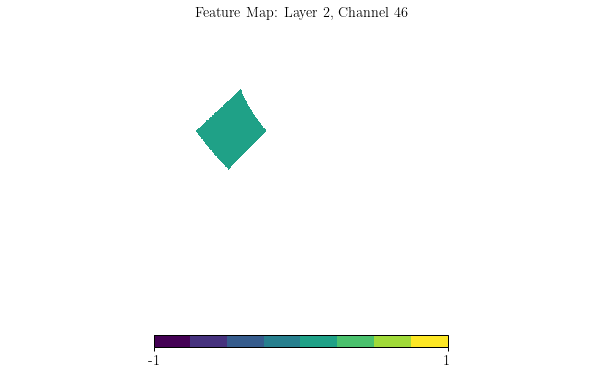

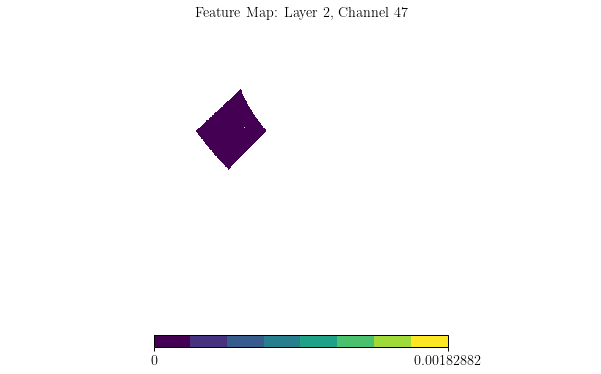

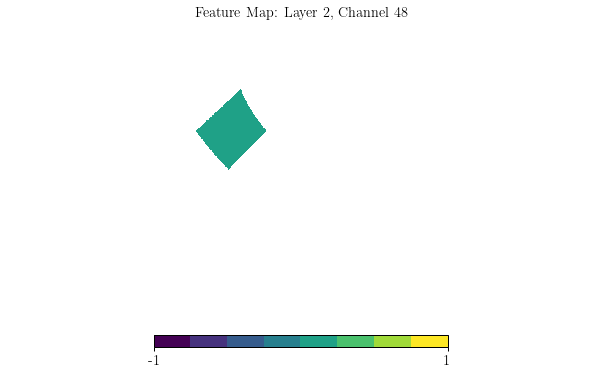

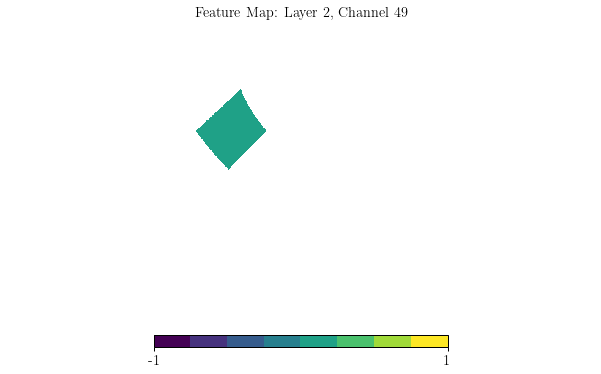

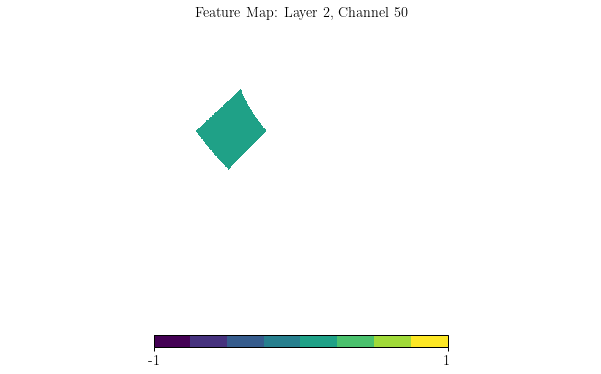

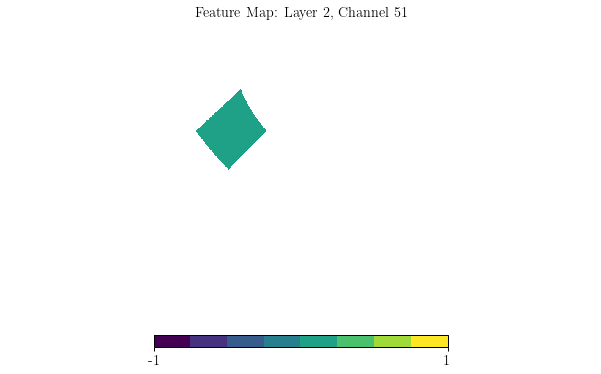

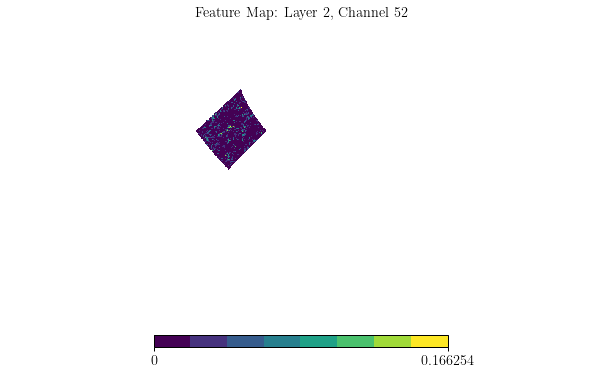

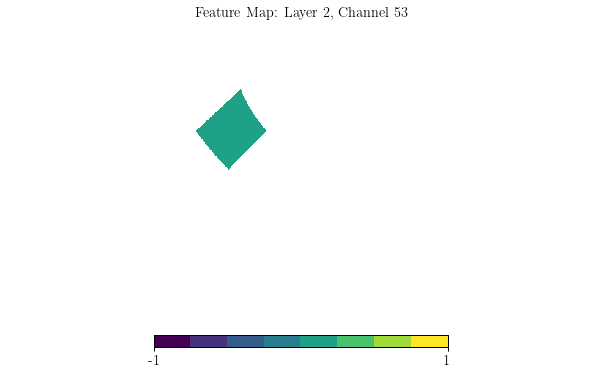

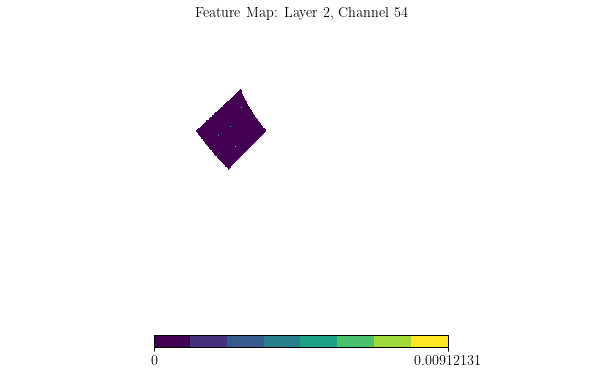

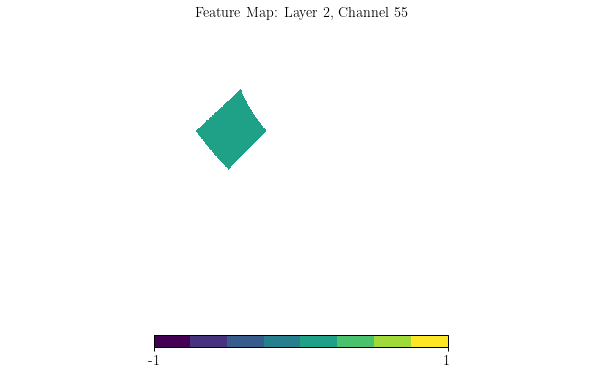

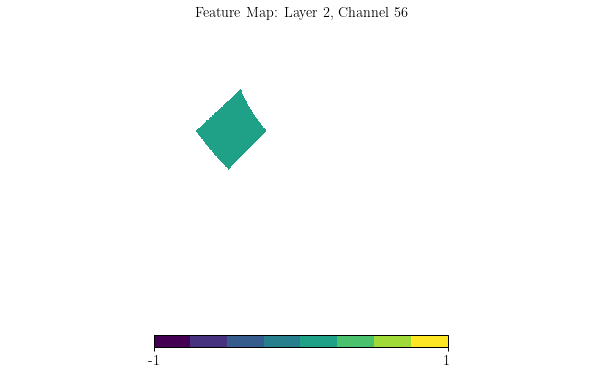

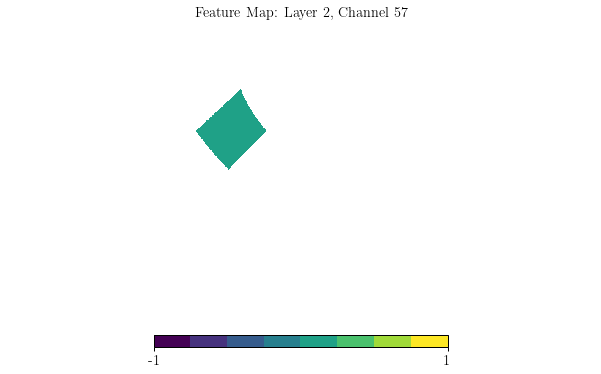

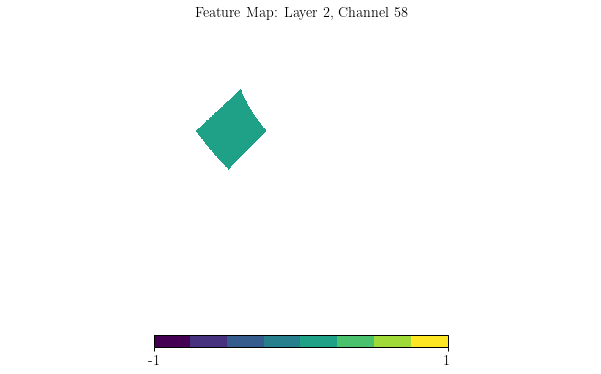

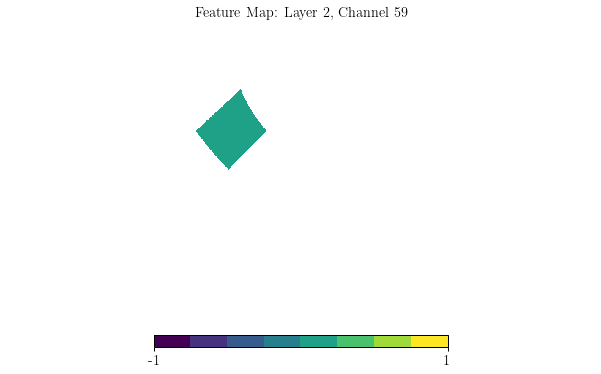

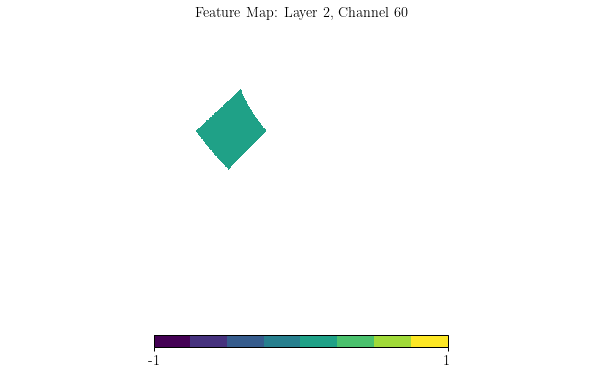

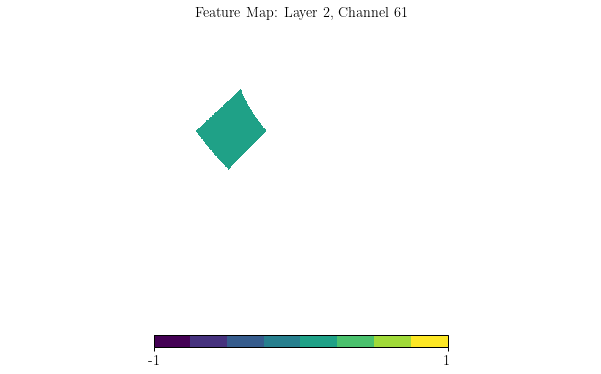

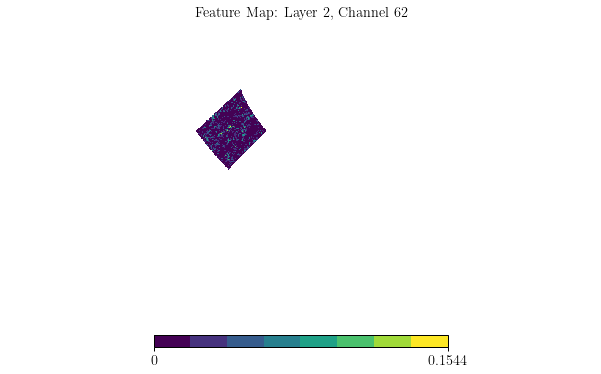

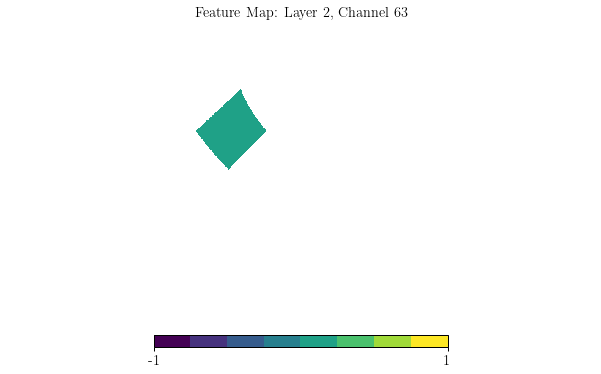

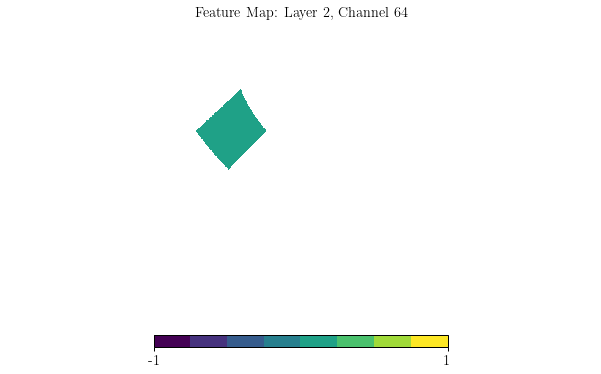

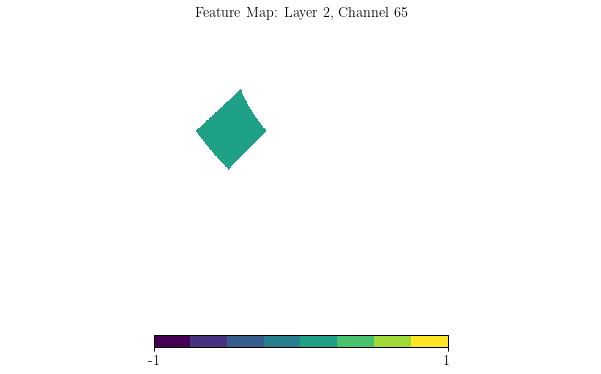

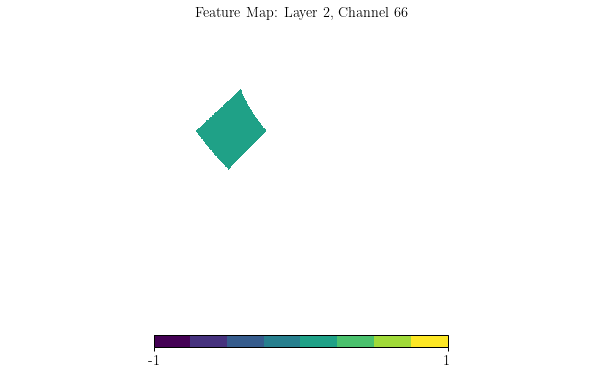

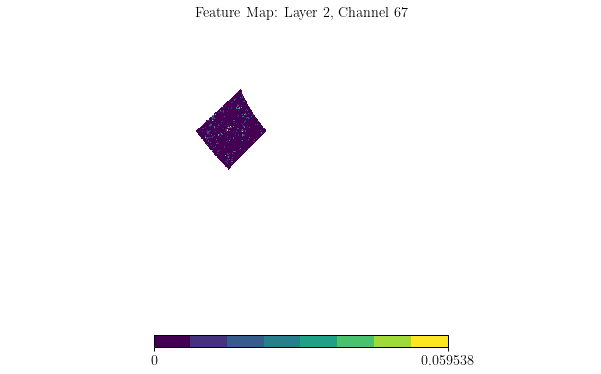

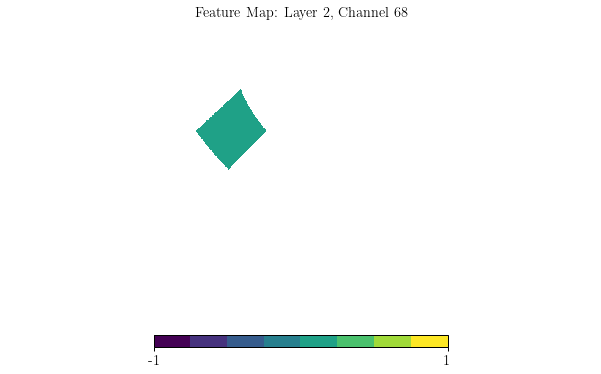

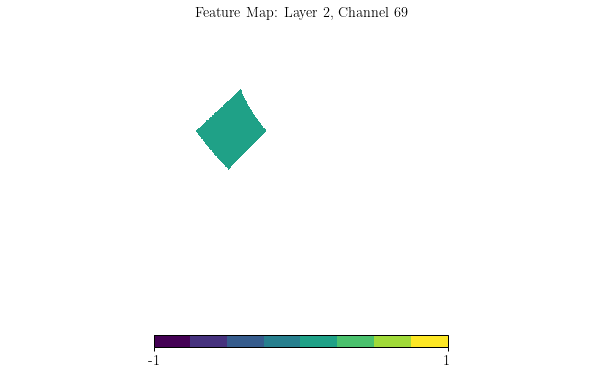

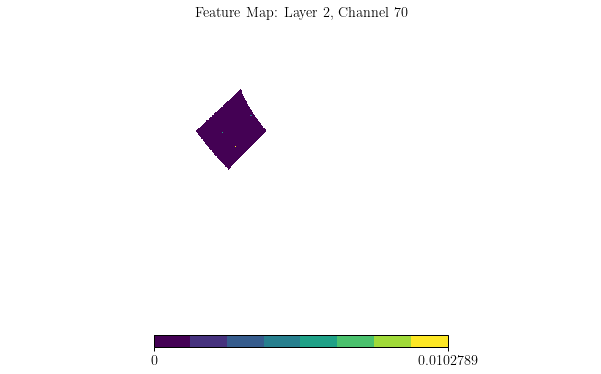

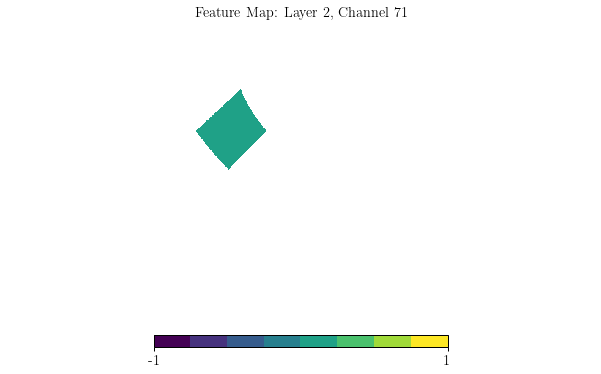

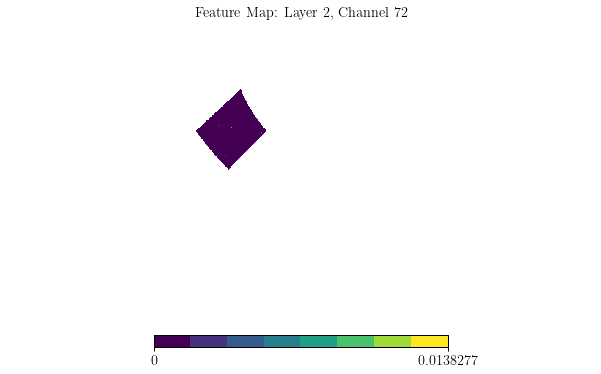

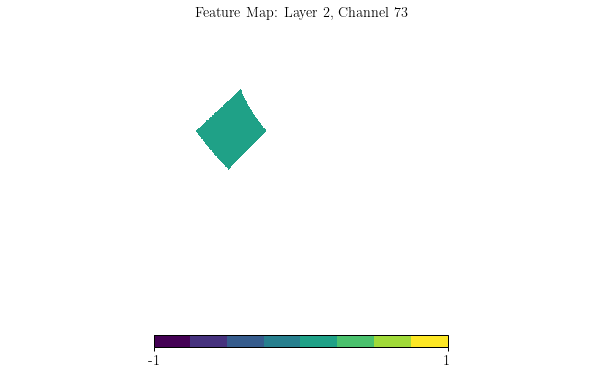

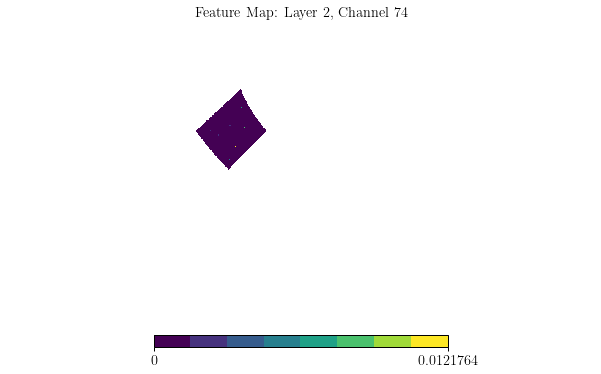

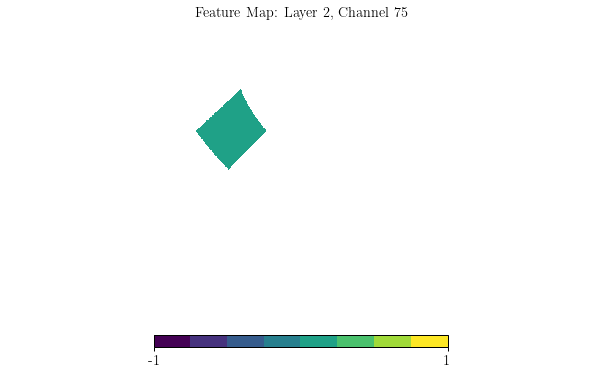

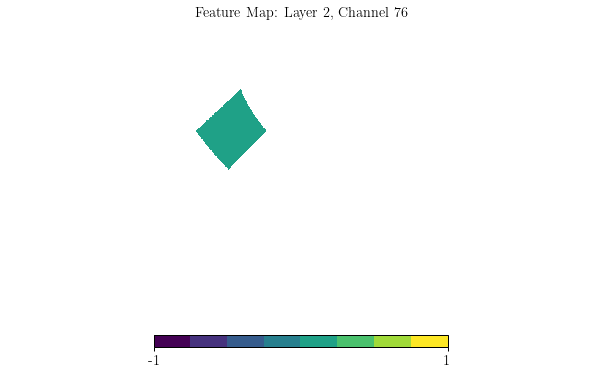

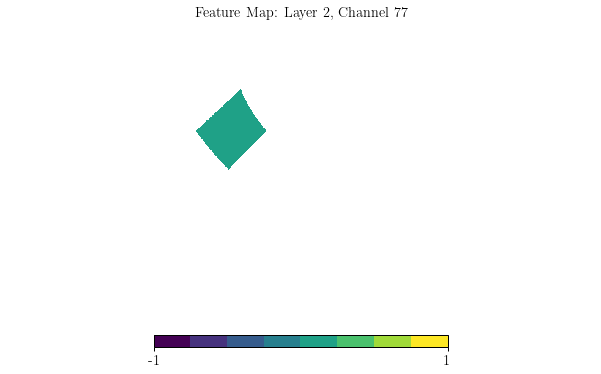

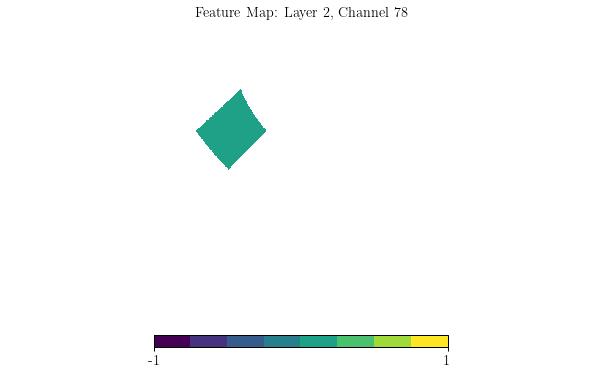

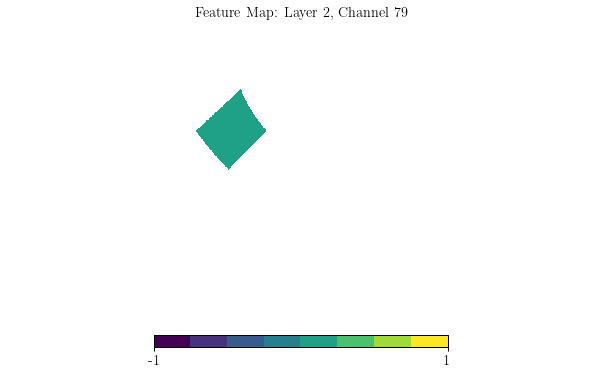

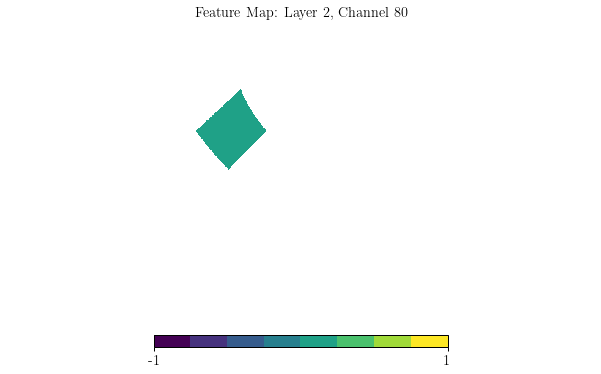

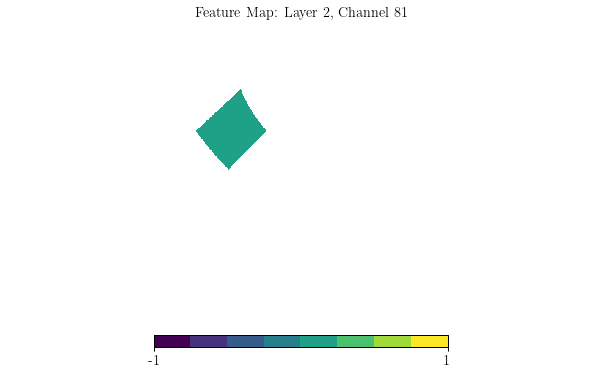

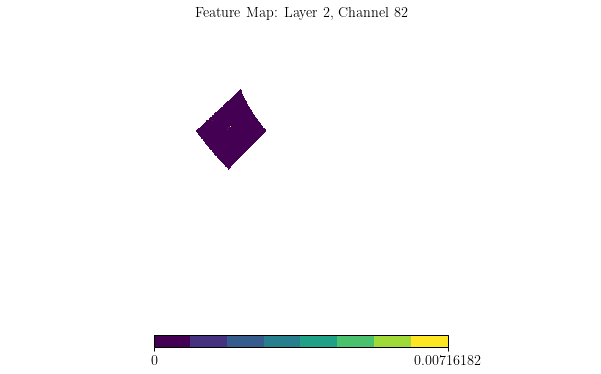

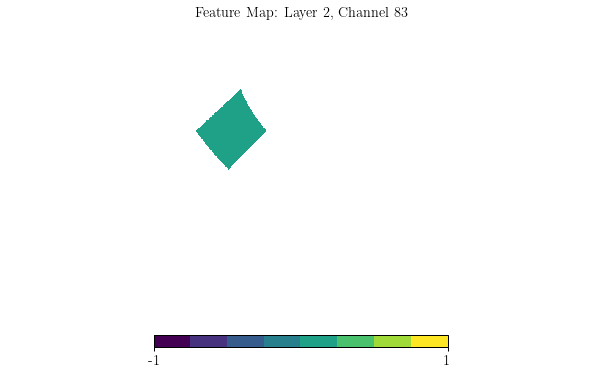

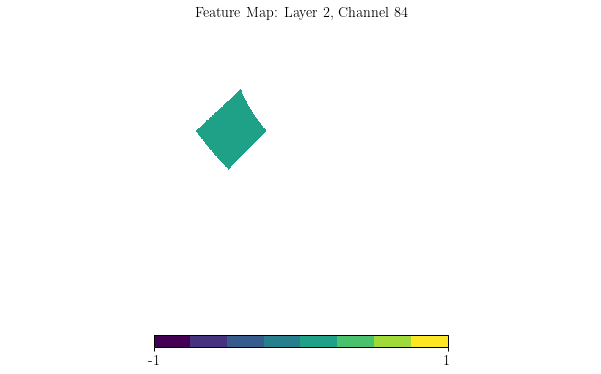

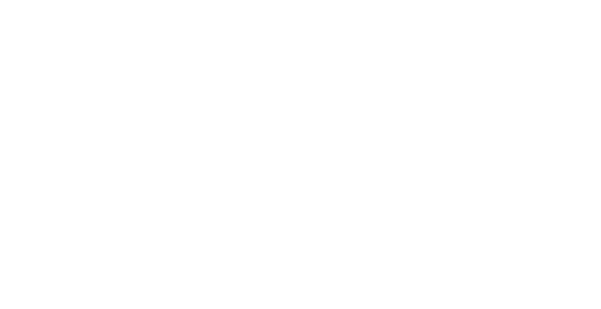

In [144]:
for i in range(9):
    for j in range(example_feature_maps[i].shape[2]):
        plot_partial_sky_map(example_feature_maps[i][0,:,j], 
                             title="Feature Map: Layer {0}, Channel {1}".format(i, j), nside=nside//(1<<(i+1)))

# Gradients and Saliency Scores

In [10]:
input_batch = tf.convert_to_tensor(data["x"][:32], dtype=tf.float32)
label_batch = tf.convert_to_tensor(data["y"][:32], dtype=tf.float32)
loss_function = tf.keras.losses.MeanAbsoluteError()

with tf.GradientTape() as tape:
    tape.watch(input_batch)
    output = model(input_batch)
    loss = loss_function(label_batch, output)
    
grads_by_input = tape.gradient(loss, input_batch)

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
grads_by_input

<tf.Tensor: shape=(32, 262144, 1), dtype=float32, numpy=
array([[[ 1.6507311e-08],
        [-1.8003703e-08],
        [-1.4229144e-08],
        ...,
        [-1.4877105e-05],
        [-1.6550632e-05],
        [-1.6118993e-05]],

       [[-4.6769287e-08],
        [ 3.1628268e-08],
        [ 2.6380679e-08],
        ...,
        [ 2.0647510e-08],
        [ 1.2475180e-08],
        [-8.3970981e-09]],

       [[ 1.4627561e-08],
        [-4.1577688e-09],
        [ 9.2000557e-10],
        ...,
        [ 1.1826164e-09],
        [ 1.1219289e-09],
        [-3.2184719e-09]],

       ...,

       [[ 2.4576703e-09],
        [-1.2174511e-09],
        [-9.8483577e-10],
        ...,
        [ 2.1920785e-05],
        [ 2.4124285e-05],
        [ 2.3804012e-05]],

       [[ 1.1024531e-08],
        [-5.0867257e-09],
        [-4.3396078e-09],
        ...,
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00]],

       [[ 1.8686115e-09],
        [ 2.6831006e-09],
        [-1.3236006e-08

In [12]:
scaled_grads_by_input = (grads_by_input - np.mean(grads_by_input))/np.std(grads_by_input)


for i in range(32):
    plot_partial_sky_map(scaled_grads_by_input[i,:,0], ncols=16, title="Example Gradients")

NameError: name 'plot_partial_sky_map' is not defined

In [ ]:
input_x_gradient = np.multiply(input_batch, grads_by_input)

In [ ]:
scaled_input_x_gradient = (input_x_gradient - np.mean(input_x_gradient))/np.std(input_x_gradient)

In [ ]:
for i in range(32):
    plot_partial_sky_map(scaled_input_x_gradient[i,:,0], ncols=16, title="Example Input x Gradient")